# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [102]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from copy import copy
import random
import time

In [103]:
sns.set(rc={"figure.dpi": 200, 'savefig.dpi': 200})

# Pomocnicze funkcje

## Obliczenia

### Budowanie macierzy wypełnionej zgodnie ze wzorem

#### Macierz kwadratowa

In [104]:
def create_matrix(fn, n, m, dtype=np.float64):
    A = np.empty((n, m), dtype)
    
    for i in range(n):
        for j in range(m):
            A[i, j] = fn(i + 1, j + 1)
            
    return A

#### Macierz o 3 przekątnych (jako 3 kolumny)
##### (Taki sposób przechowywania macierzy pozwala na zmniejszenie złożoności pamięciowej algorytmu Thomasa)

In [105]:
def create_thomas_matrix(fn, n, _=None, dtype=np.float64):
    A = np.empty((n, 3), dtype)
    
    for i in range(n):
        for k in range(3):
            j = i + k - 1
            if j < 0 or j >= n:
                A[i, k] = 0
            else:
                A[i, k] = fn(i + 1, j + 1)
            
    return A

### Tworzenie wektorów

#### Tworzenie wektora wypełnionego wartościami zgodnie z zadaną funkcją

In [106]:
def create_vector(fn, n, dtype=np.float64):
    return np.array([fn(i) for i in range(n)], dtype)

### Pomiar czasu wykonywania kodu

#### Dekorator, pozwalający na pomiar czasu wykonania kodu

In [107]:
def print_duration(sec):
    t = int(sec)
    ms = int((sec - t) * 1000)
    s = t % 60
    t //= 60
    m = t % 60
    t //= 60
    print(f'Łączny czas wykonania: {t:>02}:{m:>02}:{s:>02}.{ms:<03}')

def timed(*, save_fn=None, save_dict=None):
    def decorator(fn):
        def inner(*args, **kwargs):
            start_time = time.perf_counter()
            res = fn(*args, **kwargs)
            duration = time.perf_counter() - start_time
    
            if save_dict is not None and save_fn: 
                save_dict[save_fn(*args, **kwargs)] = duration
            return res
        
        return inner
    return decorator

### Porównywanie wartości obliczonego wektora do rzeczywistego

#### Norma maksimum

In [108]:
max_err = lambda v1, v2: max(abs(v1 - v2))

# Zadanie 1

## Opis problemu

Elementy macierzy $A$ dane są wzorem:

$
\begin{cases} 
    a_{1, j} = 1 \\ 
    a_{i, j} = \frac{1}{i \hspace{5px} + \hspace{5px} j \hspace{5px} - \hspace{5px} 1}, & dla \hspace{10px} i \neq 1 \\
\end{cases}
$

gdzie $i, j \in \{1, 2, ..., n\}$

## Tworzenie macierzy

### Implementacja funkcji, zgodnie z którą wypełnione są wartości macierzy

In [109]:
def fn(i: int, j: int) -> float:
    if i == 1:
        return 1
    return 1 / (i + j - 1)

###### Test

In [110]:
n = 4
A = create_matrix(fn, n, n)
A

array([[1.        , 1.        , 1.        , 1.        ],
       [0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.25      , 0.2       , 0.16666667, 0.14285714]])

## Implementacja algorytmu eliminacji Gaussa

In [111]:
times = {}

In [112]:
@timed(
    save_fn=lambda A, *args, **kwargs: len(A),
    save_dict=times
)
def gauss(A: np.ndarray, B: np.ndarray, dtype=np.float64) -> np.ndarray:
    n = len(A)
    AB = np.hstack([A, B.reshape((n, 1))]).astype(dtype)
    
    for i in range(n):
        pivot = AB[i, i]
        for j in range(i + 1, n):
            base = AB[j, i] / pivot          
            AB[j] -= base * AB[i]

    X = AB[:, n]
    X[n - 1] /= AB[n - 1, n - 1]
    for i in range(n - 2, -1, -1):
        pivot = AB[i, i]
        X[i] -= (AB[i, i+1:n] * X[i+1:n]).sum()
        X[i] /= pivot
        
    return X

###### Test

In [113]:
random.seed(0)

n = 8
A = create_matrix(fn, n, n)
X = create_vector(lambda i: 1 if random.random() > .5 else -1, n)
B = A @ X
X_res = gauss(A, B)
X, X_res

(array([ 1.,  1., -1., -1.,  1., -1.,  1., -1.]),
 array([ 1.        ,  1.        , -1.00000001, -0.99999997,  0.99999993,
        -0.99999991,  0.99999995, -0.99999999]))

## Rozwiązanie zadania

### Pomocnicza funkcja

In [114]:
def calculate_helper(ns, prec, create_matrix_method, calc_method, seed=0, err_calc_fn=max_err, log_every=10):
    results = {}
    expected = {}
    errors = {}
    
    for i, n in enumerate(ns):
        A = create_matrix(fn, n, n, prec)
        expected[n] = X = create_vector(lambda i: 1 if i % 2 else -1, n, prec)
        # Calculate the B vector based on the known value of X
        B = A @ X
        
        # Create A amtrix again using the specified create function
        # (this ensures that A matrix will be appropriate when using modified Thomas algorithm)
        A = create_matrix_method(fn, n, n, prec)
        # Calculate the X vector bsed on the A nad B matrix values
        results[n] = X_calc = calc_method(A, B, prec)
        # Calculate errors using the specified error calculationg function
        errors[n] = err_calc_fn(X, X_calc)
        
        if not (i + 1) % log_every: 
            print(f'Obliczono {i + 1} układów równań')
            
    return results, expected, errors

### Obliczenia dla dwóch różnych precyzji (float32 i float64)

In [115]:
@timed(
    save_fn=lambda *args, **kwargs: 'total',
    save_dict=times
)
def calculate(ns, precs, create_matrix_method=create_matrix, calc_method=gauss):
    results = {}
    
    for name, prec in precs.items():
        print(f'{"=" * 10} {name} {"=" * 10}')
        res, expected, errors = calculate_helper(ns, prec, create_matrix_method, calc_method, log_every=25)
        results[name] = {
            'results': res,
            'expected': expected,
            'errors': errors,
            'times': copy(times)
        }
        print()
    
    return results

In [116]:
ns = range(2, 201)
precs = {
    'float32': np.float32, 
    'float64': np.float64
}
results1 = calculate(ns, precs)
print_duration(times['total'])

========== float32 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań

========== float64 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań

Łączny czas wykonania: 00:00:12.733


### Wykresy

#### Pomocnicza funkcja

In [117]:
def scatter(results, attr, label, ylabel, scale=None, ns=None):
    err32 = results['float32'][attr]
    err64 = results['float64'][attr]
    
    if ns is not None:
        err32 = {i: err32[i] for i in ns}
        err64 = {i: err64[i] for i in ns}

    fig, ax = plt.subplots(figsize=(15, 7.5))
    if scale: ax.set_yscale(scale)
    plt.scatter(x=err32.keys(), y=err32.values(), c='#EA6A00', label='float32')
    plt.scatter(x=err64.keys(), y=err64.values(), c='#008C8C', label='float64')
    plt.title(label)
    plt.xlabel('wartość n')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

#### Błędy obliczeń

##### Skala liniowa

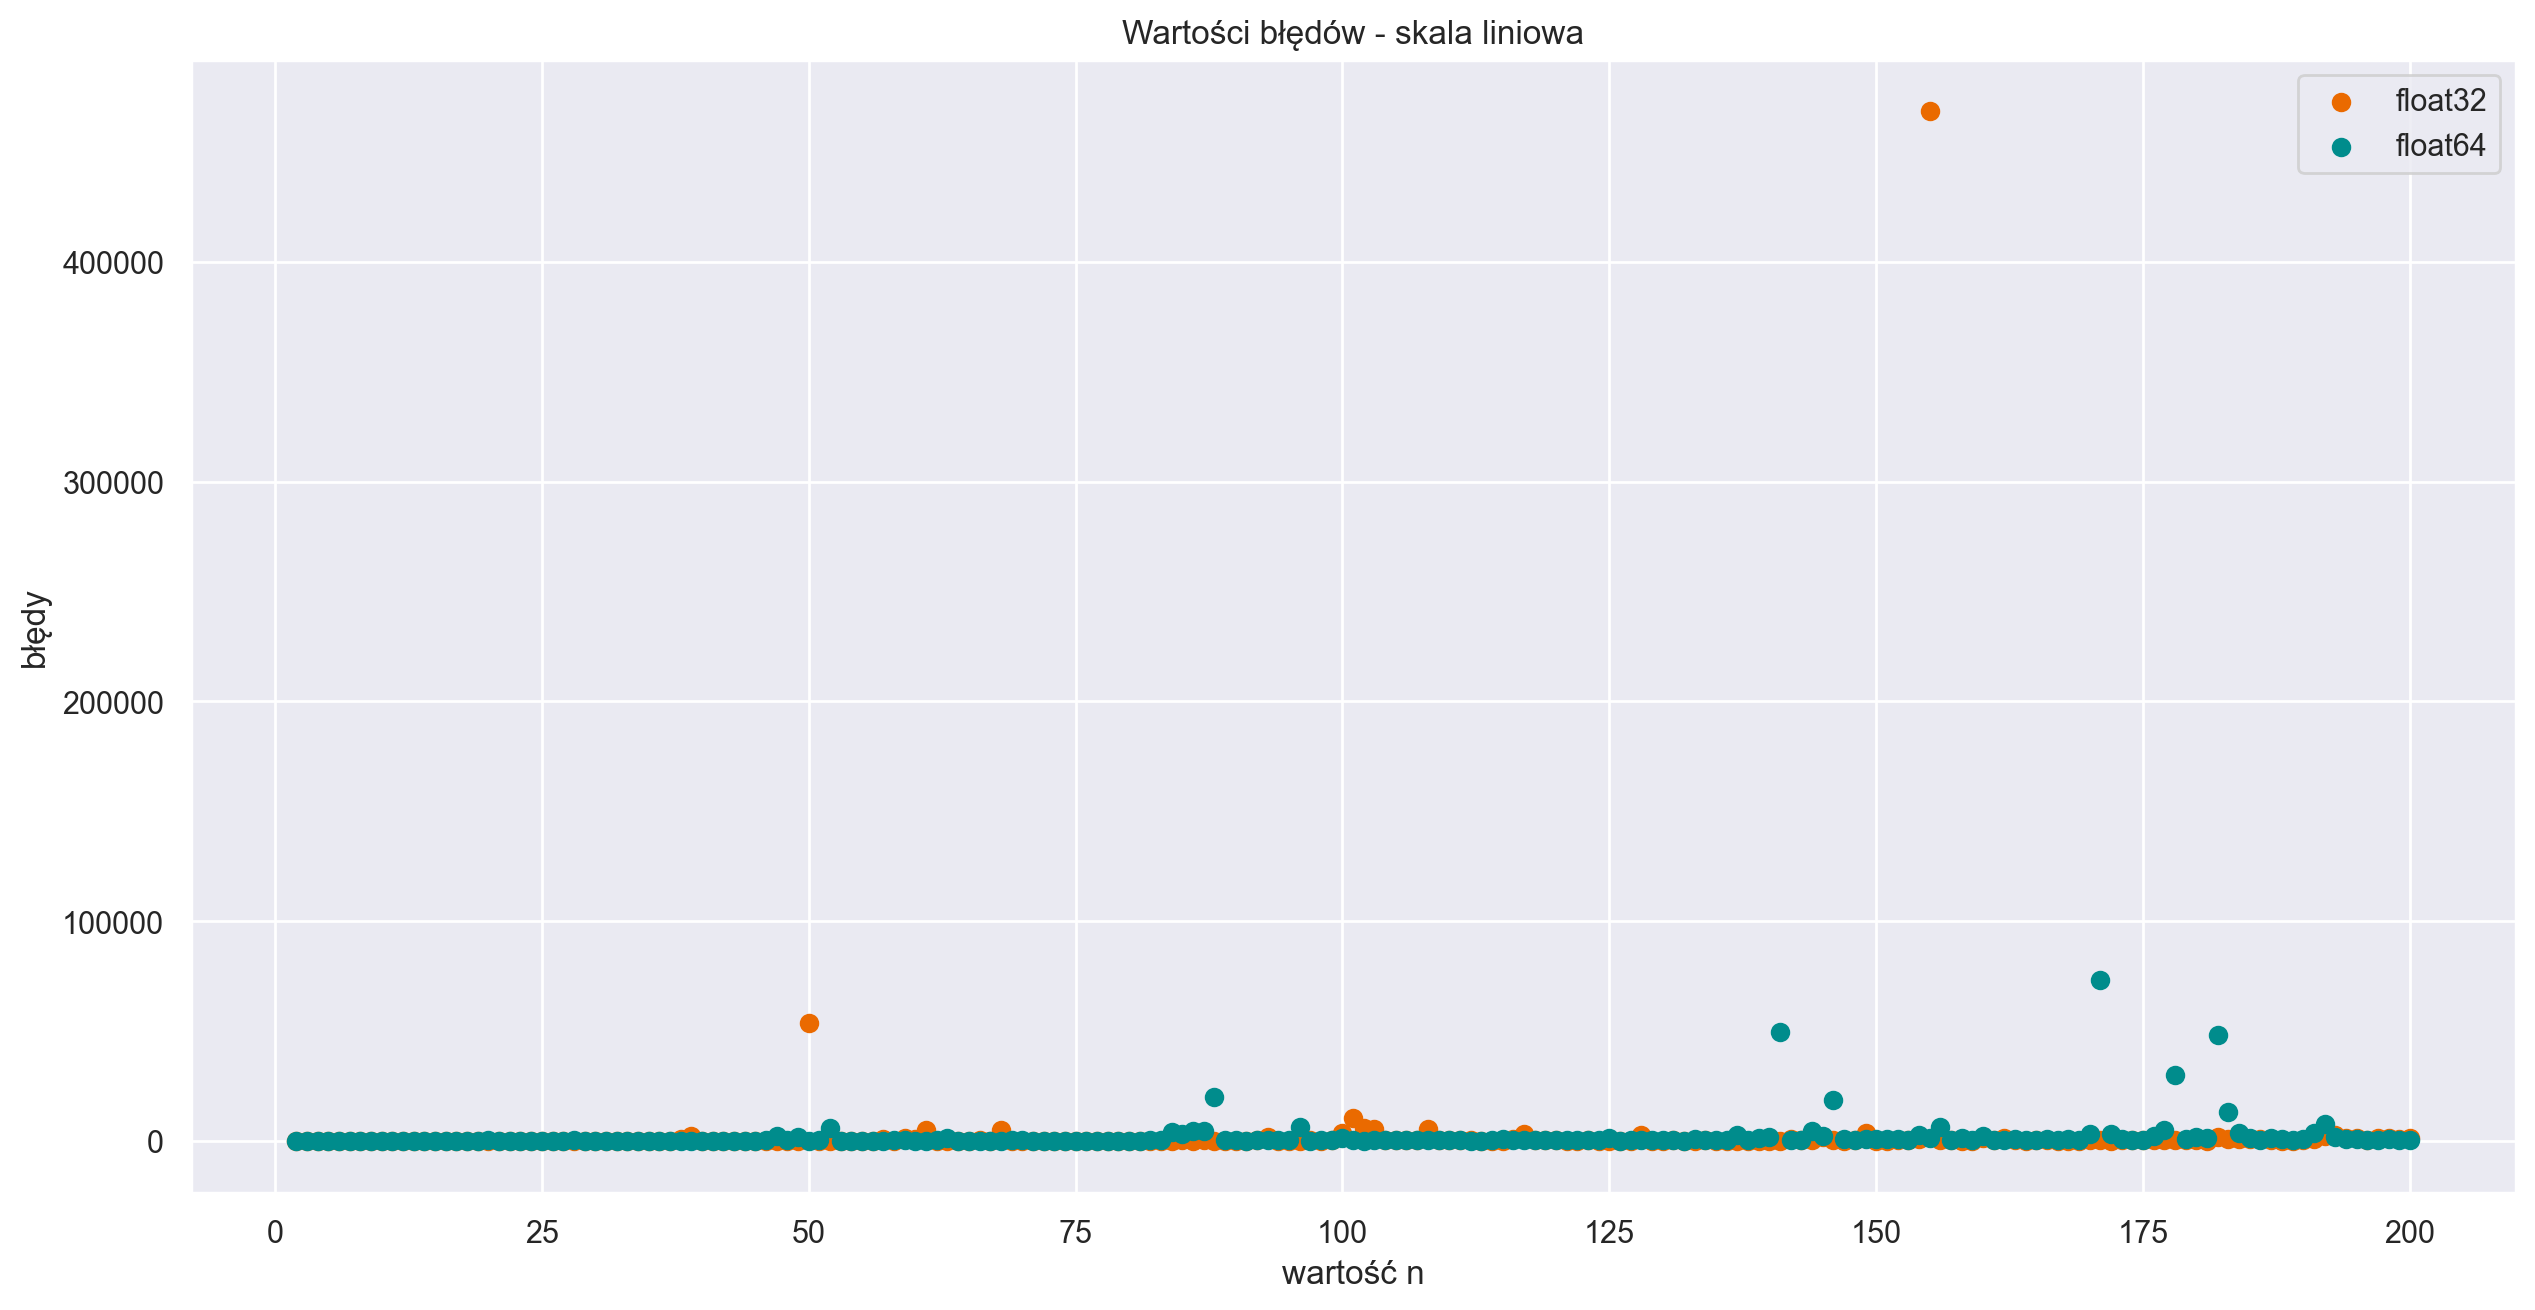

In [118]:
scatter(results1, 'errors', 'Wartości błędów - skala liniowa', 'błędy')

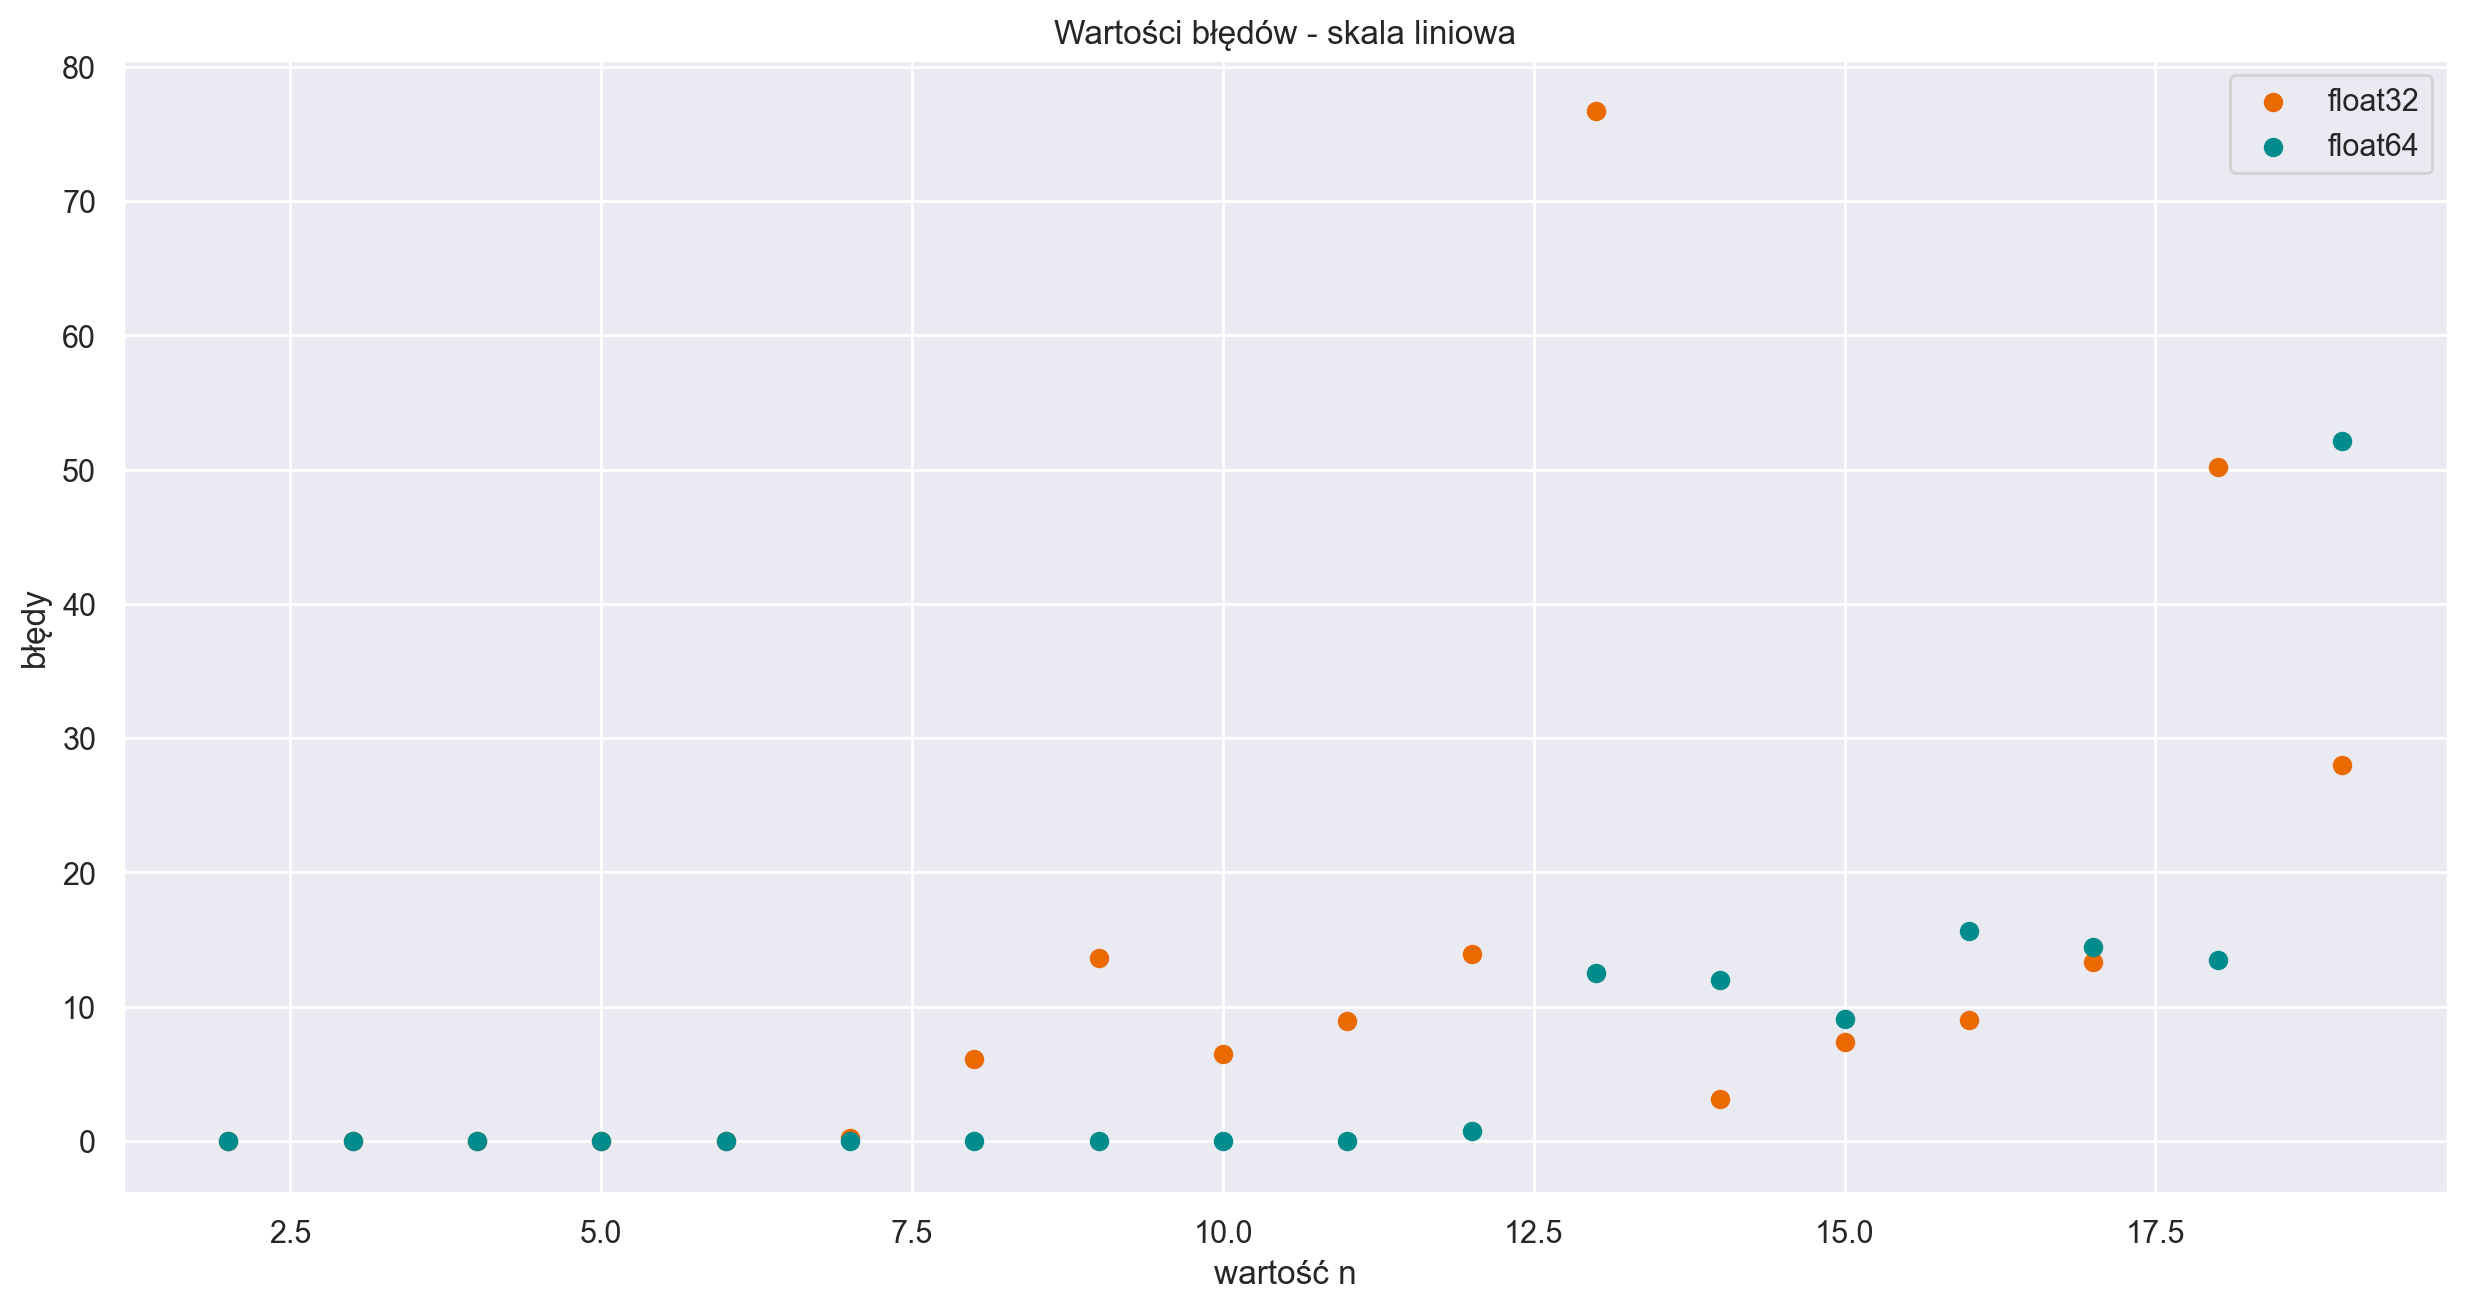

In [119]:
scatter(results1, 'errors', 'Wartości błędów - skala liniowa', 'błędy', ns=list(range(2, 20)))

##### Skala logarytmiczna

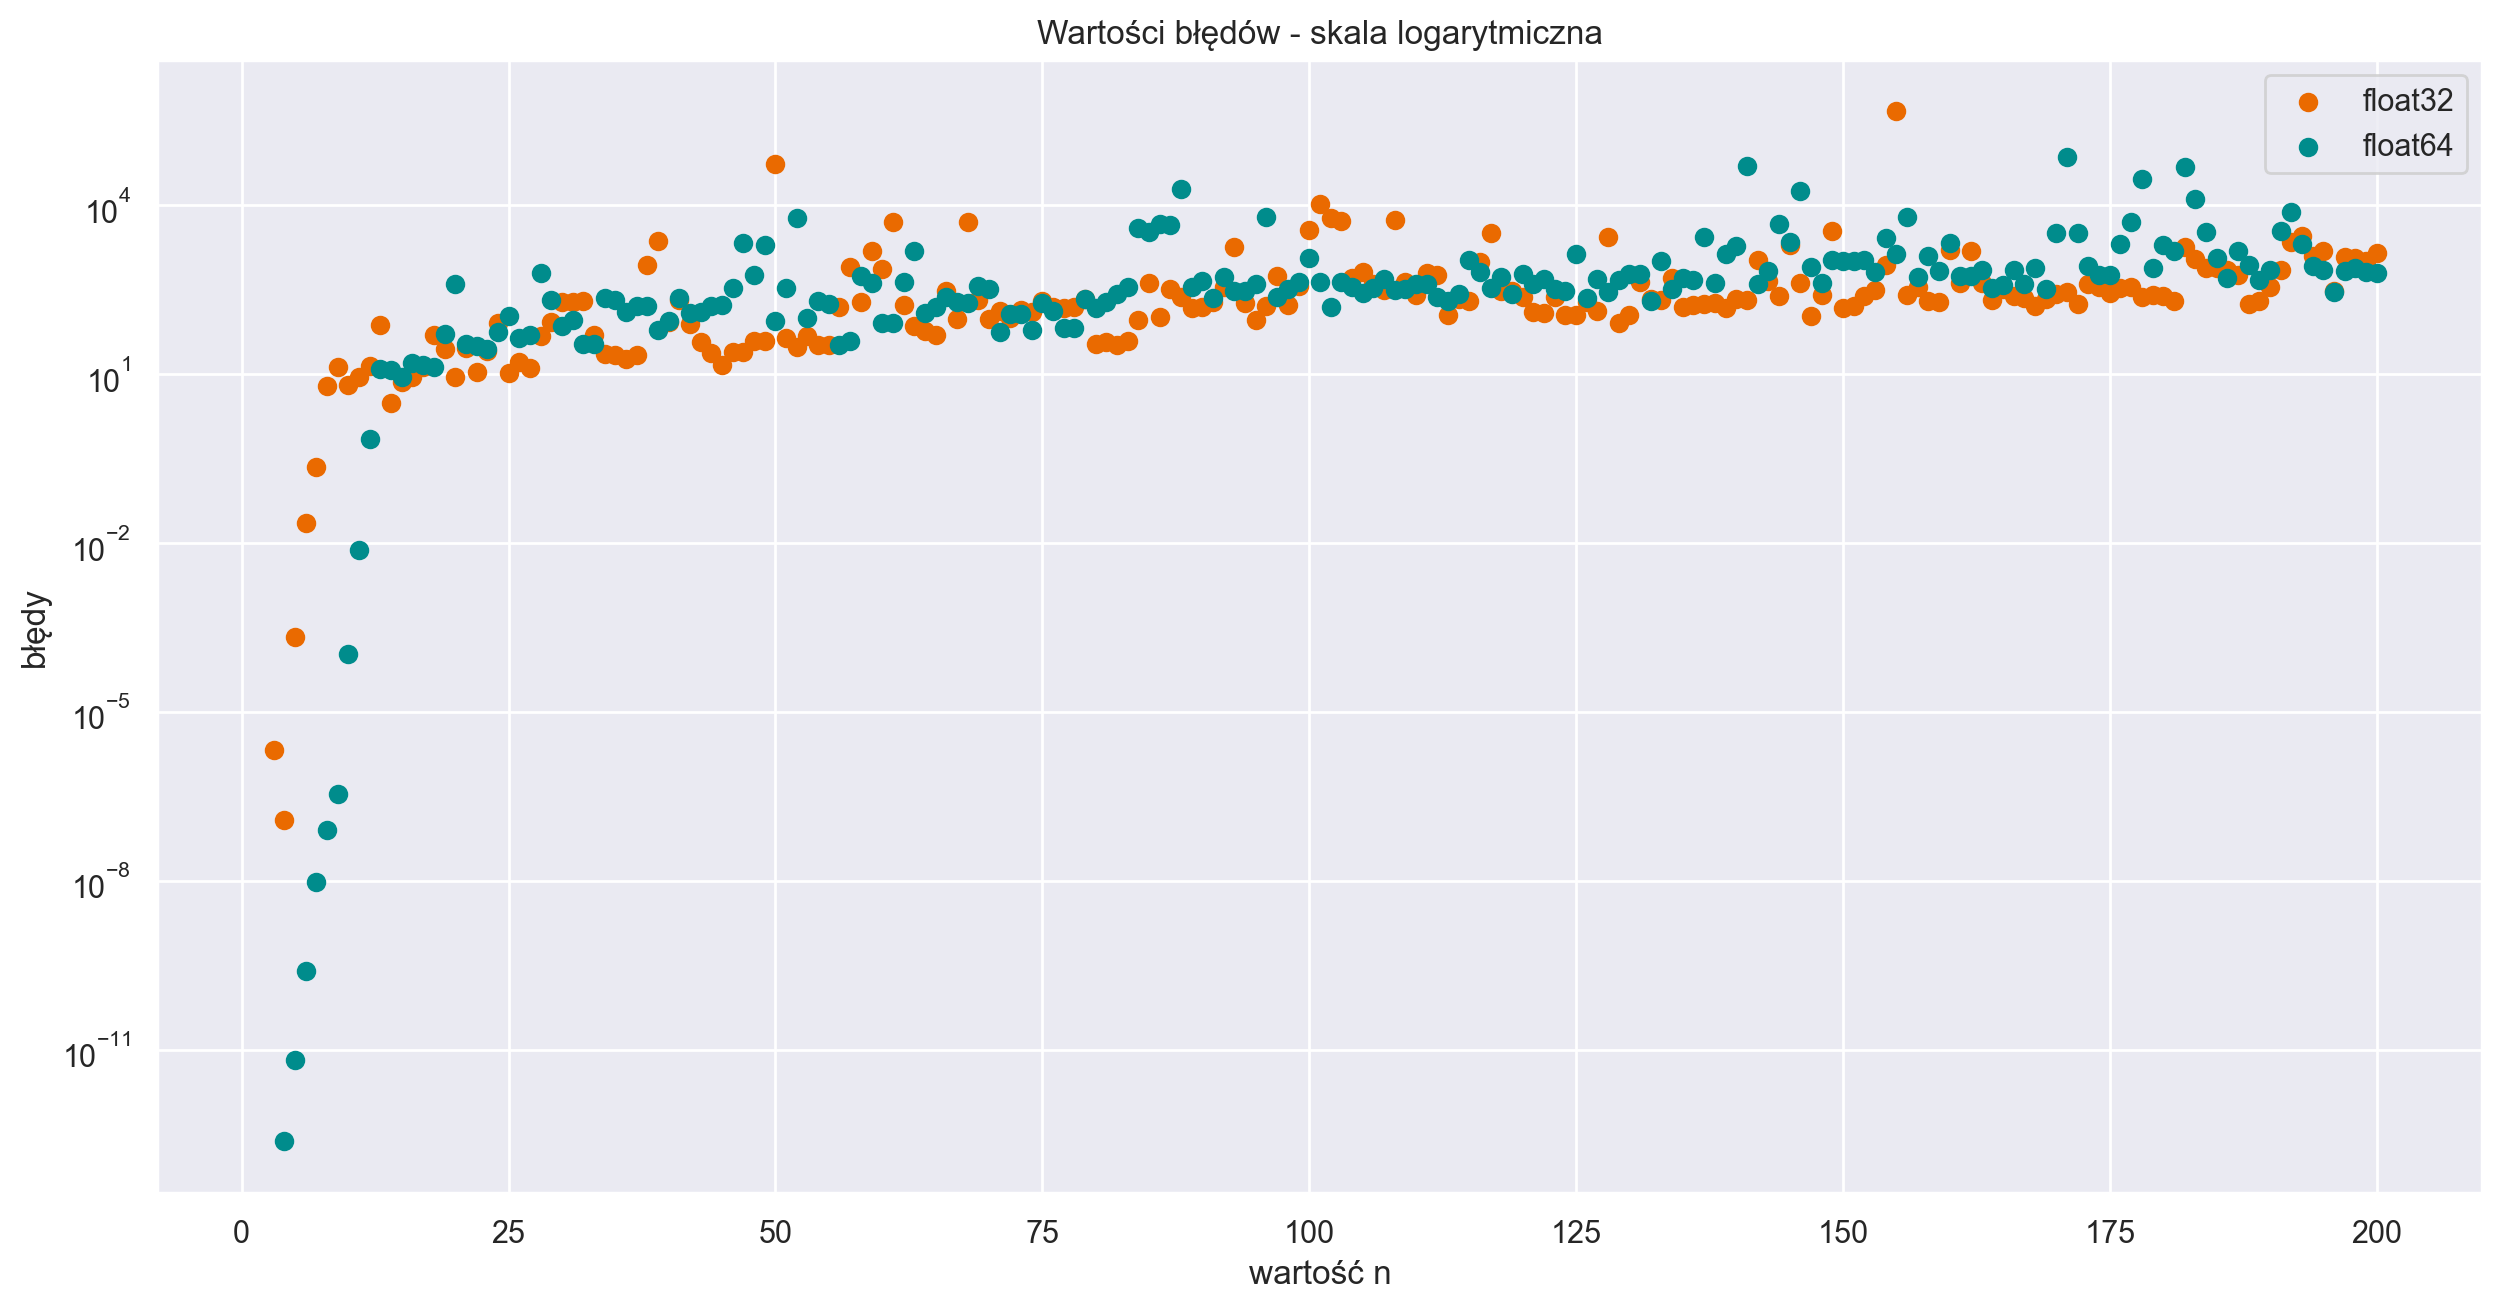

In [120]:
scatter(results1, 'errors', 'Wartości błędów - skala logarytmiczna', 'błędy', 'log')

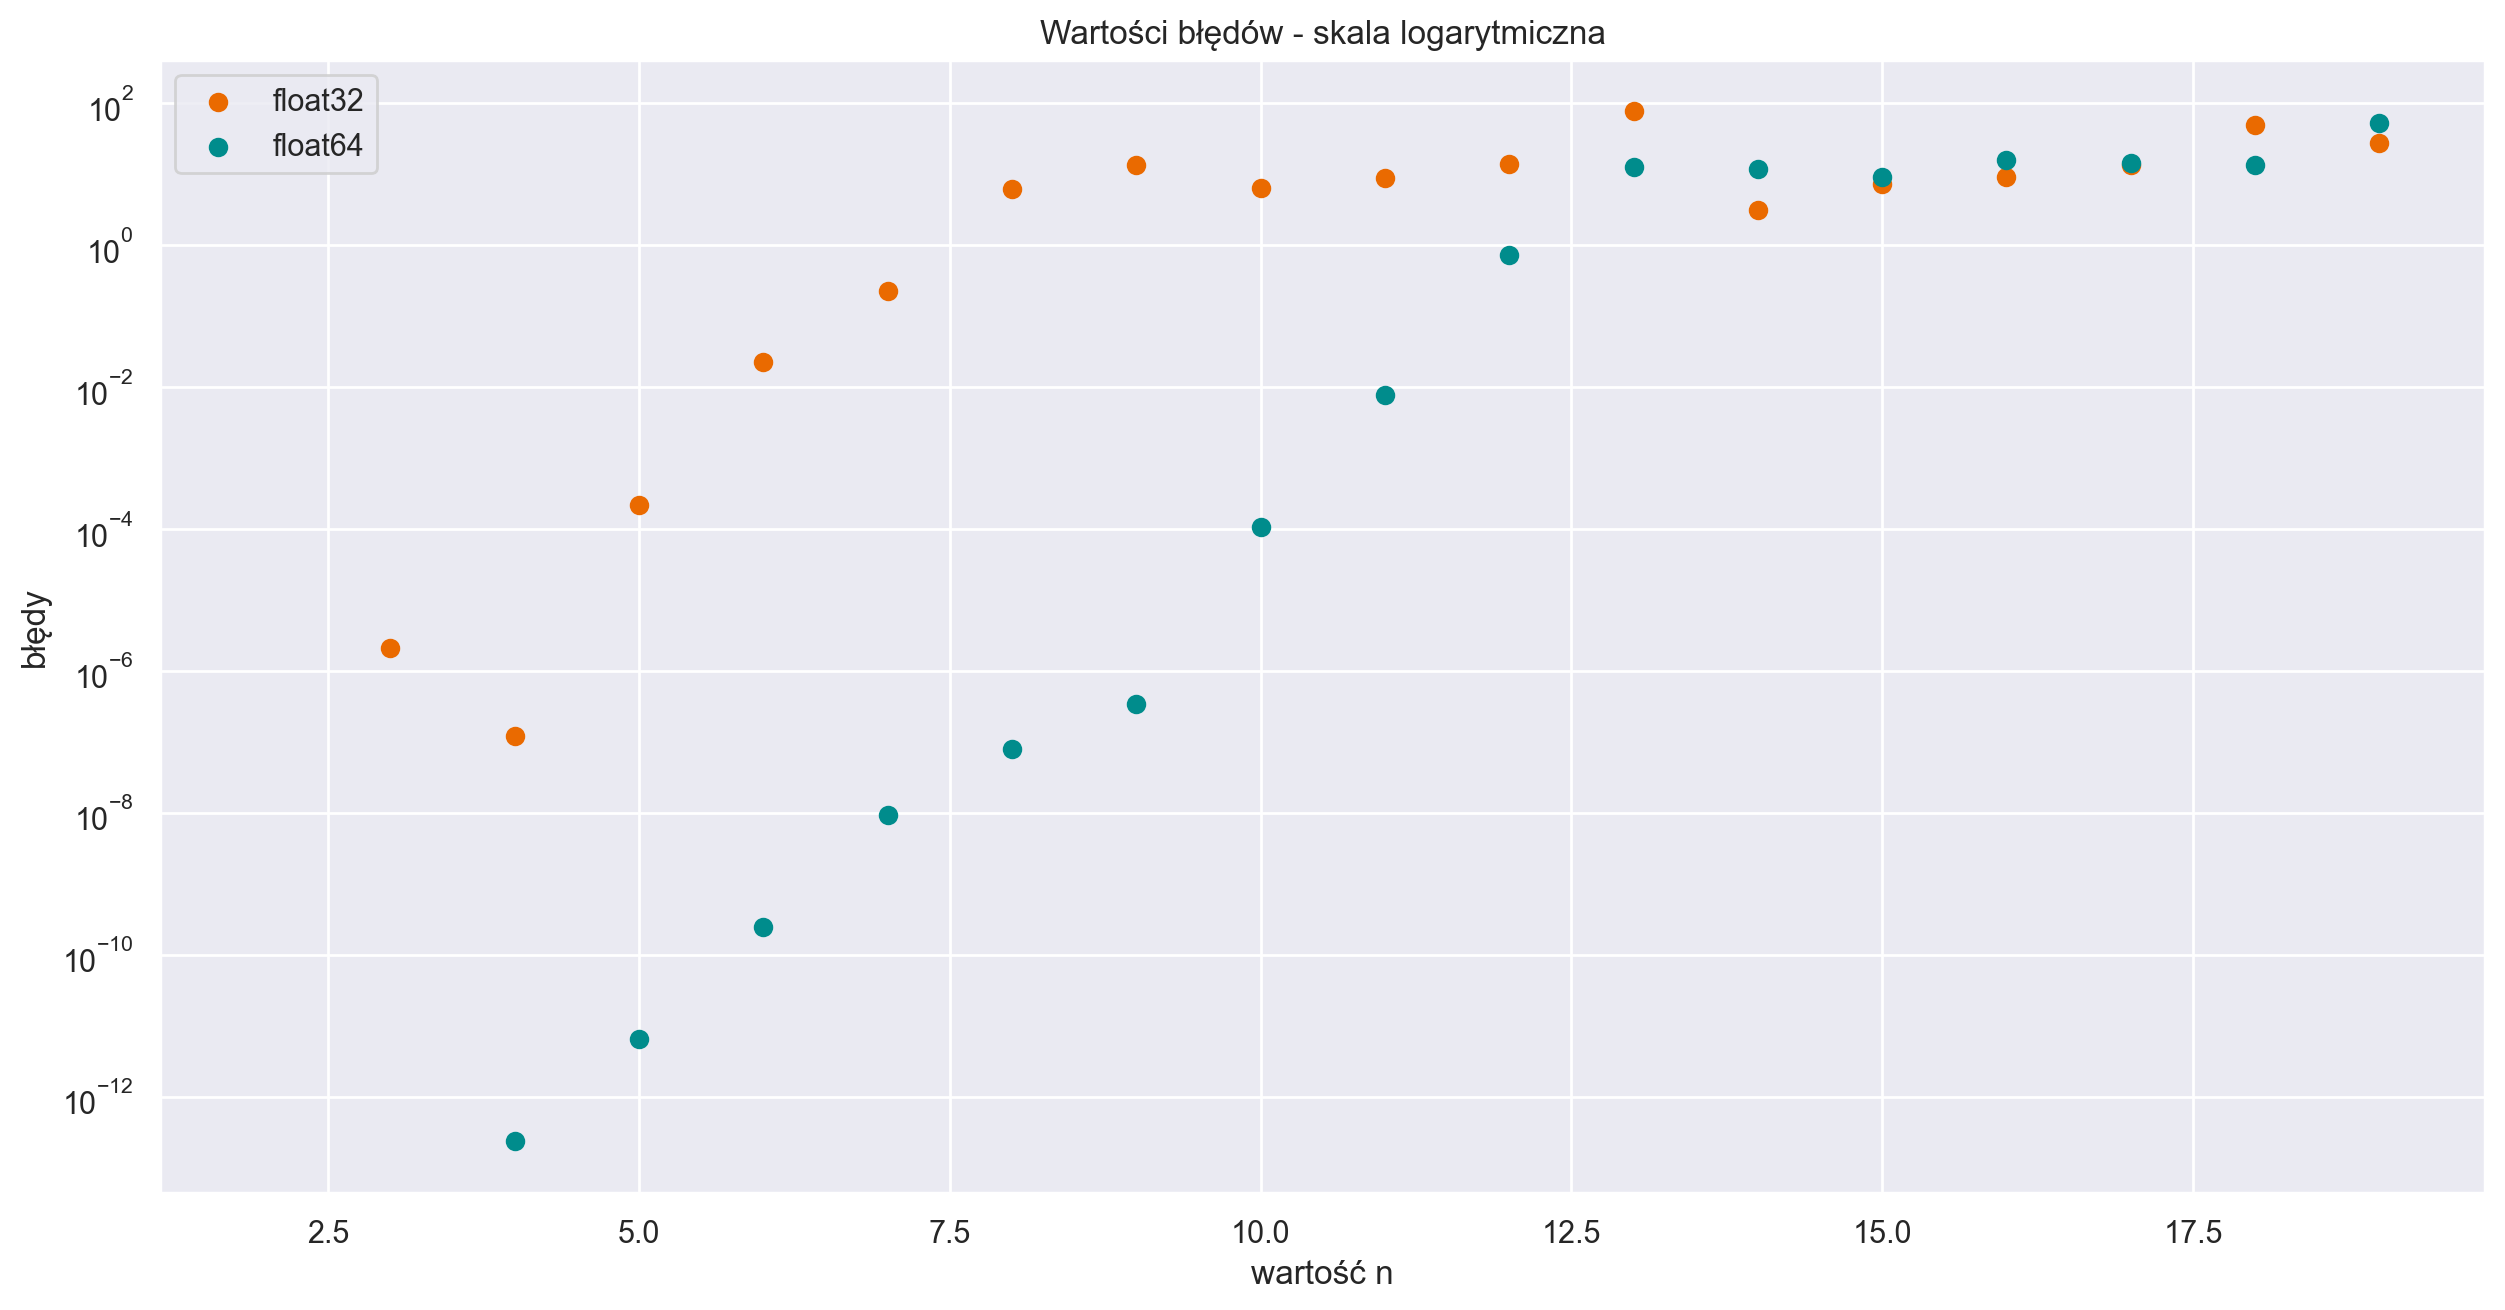

In [121]:
scatter(results1, 'errors', 'Wartości błędów - skala logarytmiczna', 'błędy', 'log', range(2, 20))

#### Czasy obliczeń

##### Skala liniowa

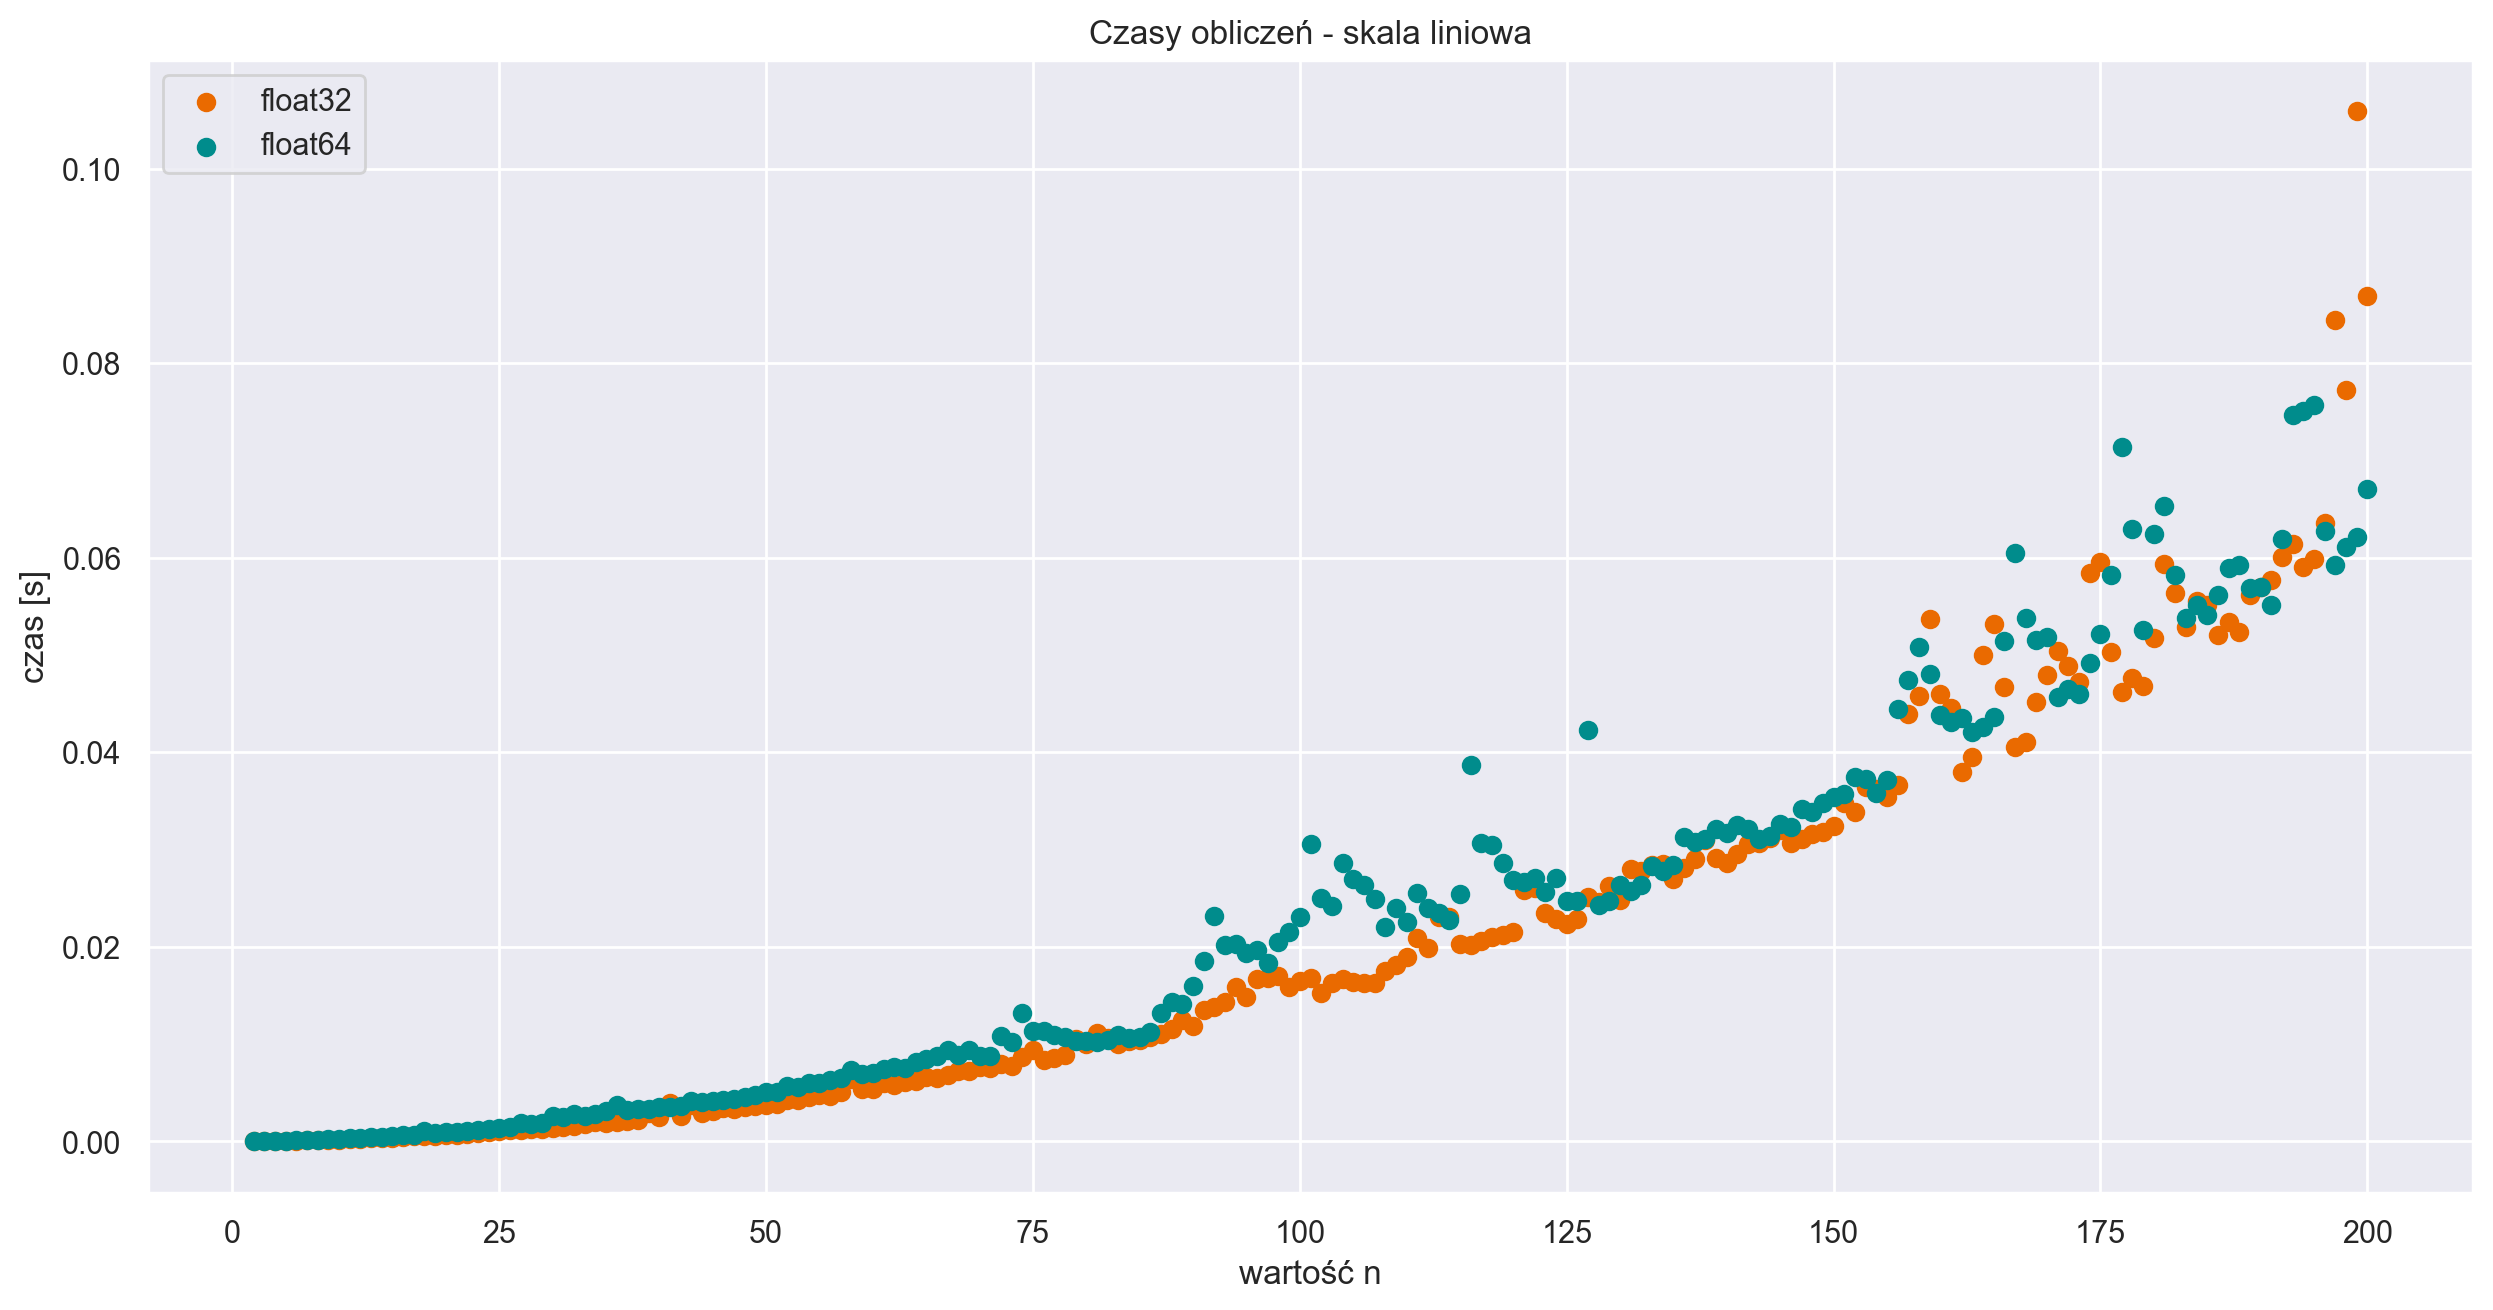

In [122]:
scatter(results1, 'times', 'Czasy obliczeń - skala liniowa', 'czas [s]')

##### Skala logarytmiczna

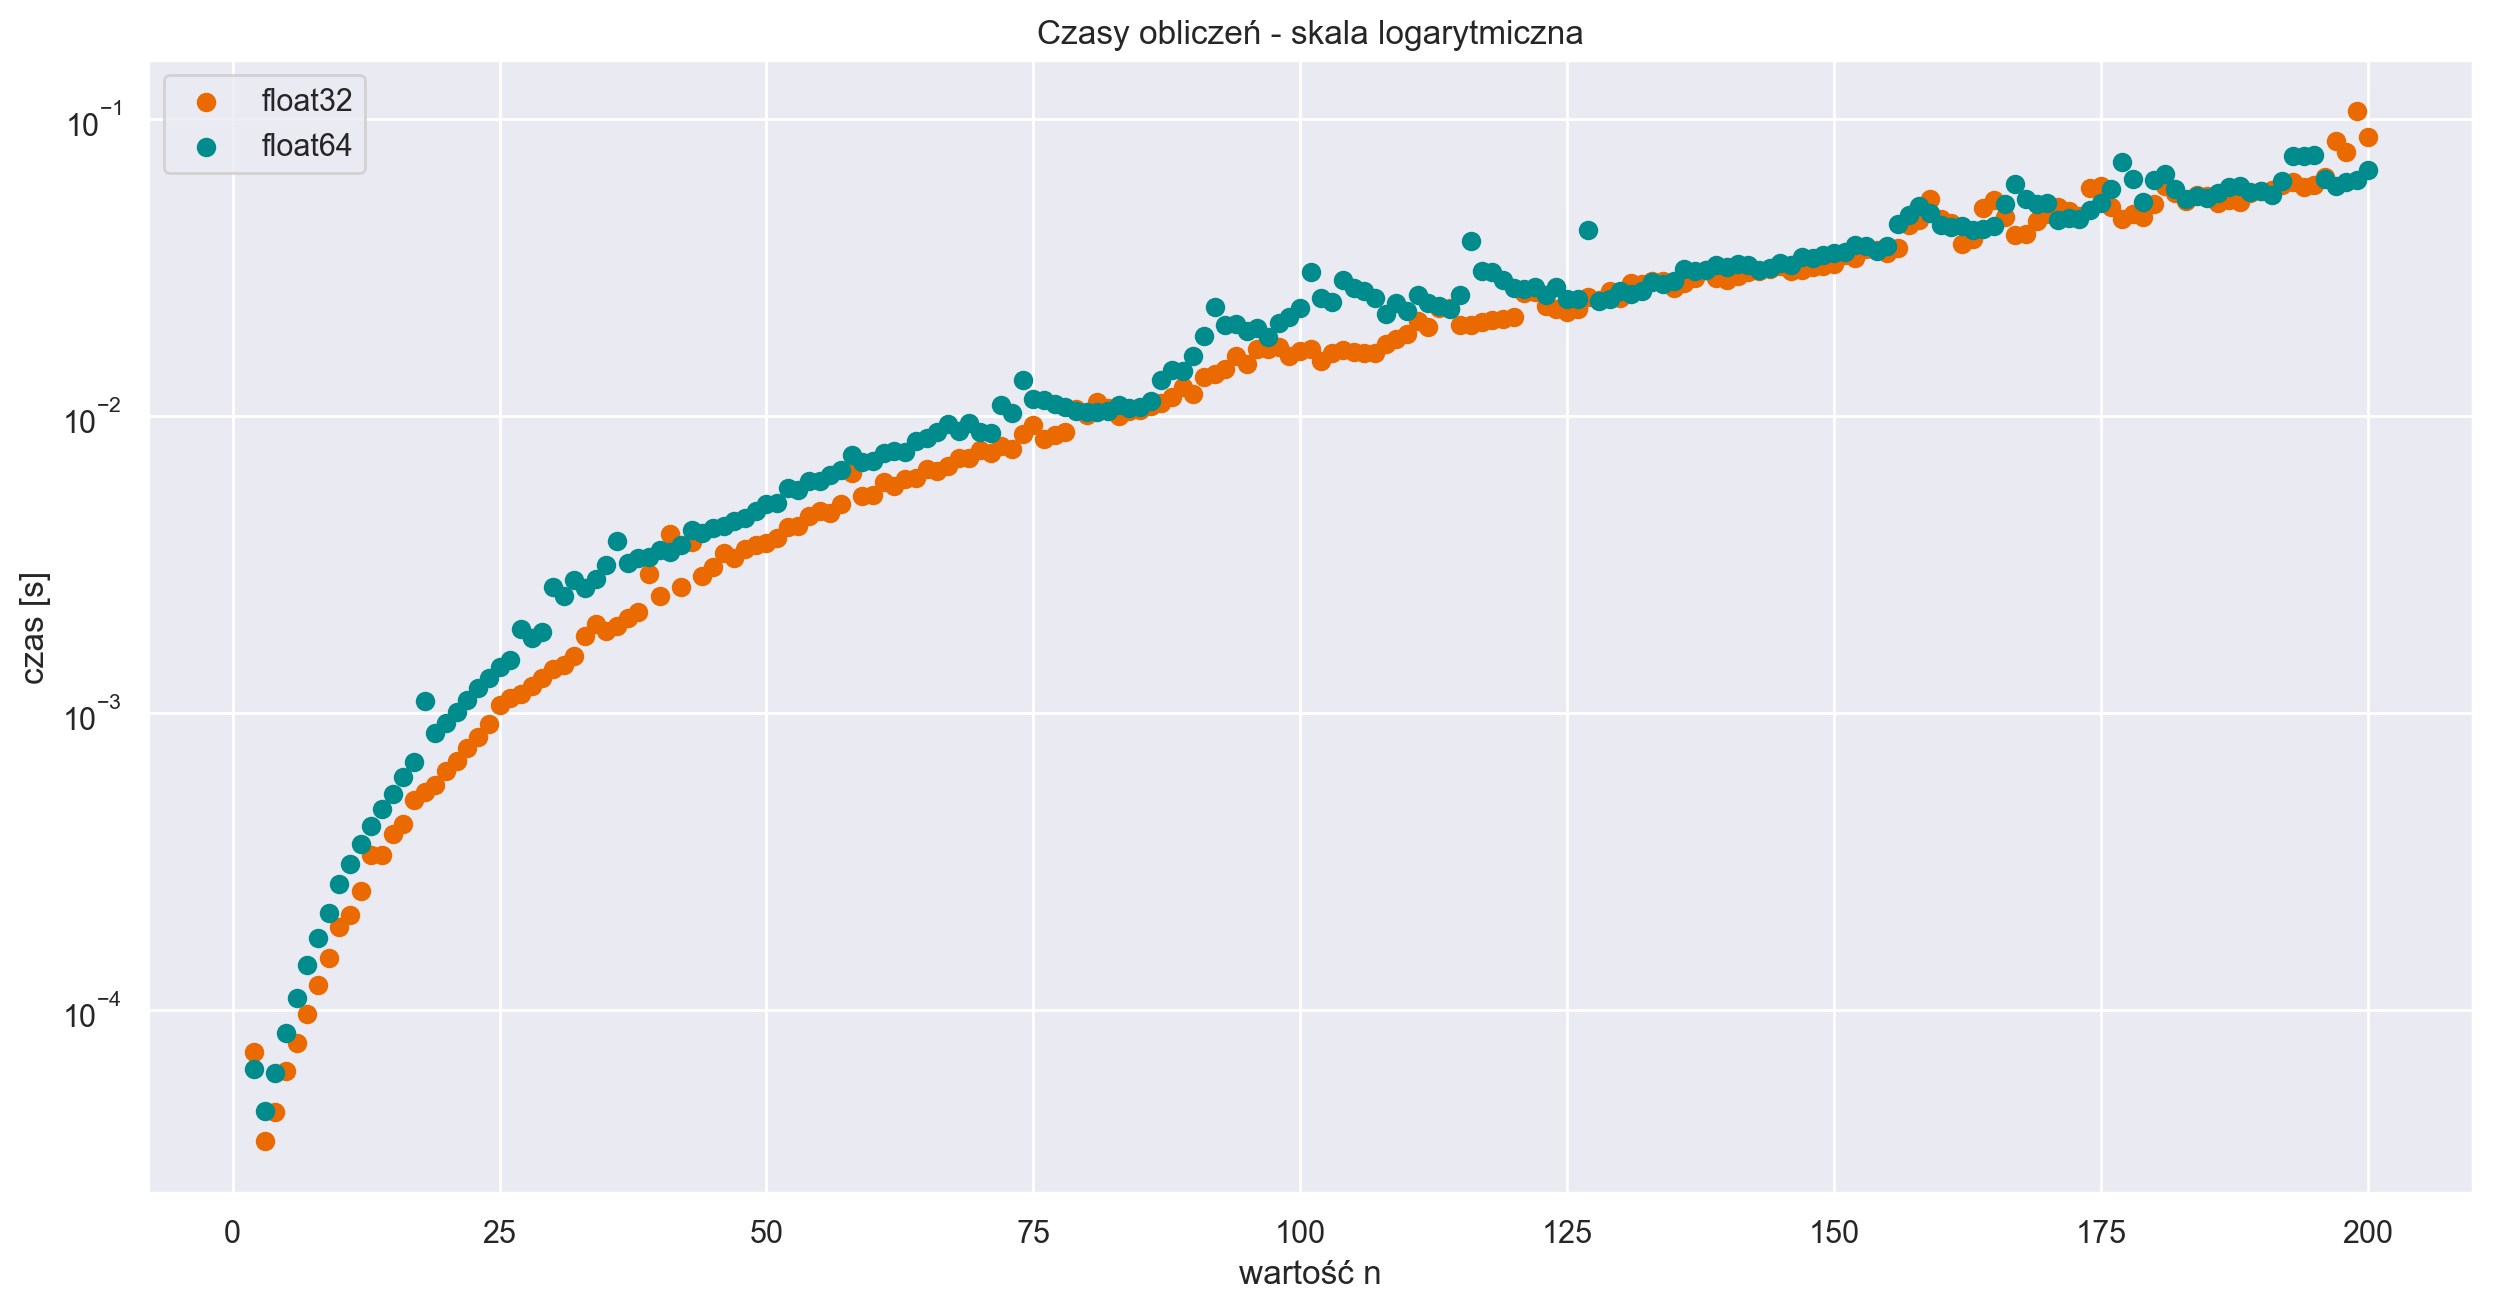

In [123]:
scatter(results1, 'times', 'Czasy obliczeń - skala logarytmiczna', 'czas [s]', 'log')

### Wybrane wartości - zestawienie

##### Pomocnicza funkcja

In [124]:
def create_summary_df(results, ns):
    err32 = []
    err64 = []
    times32 = []
    times64 = []

    err32_values = list(results['float32']['errors'].values())
    err64_values = list(results['float64']['errors'].values())
    times32_values = list(results['float32']['times'].values())
    times64_values = list(results['float64']['times'].values())

    min_n = min(ns)
    for n in ns_part:
        err32.append(err32_values[n - min_n])
        err64.append(err64_values[n - min_n])
        times32.append(times32_values[n - min_n])
        times64.append(times64_values[n - min_n])

    df = pd.DataFrame(
        list(zip(ns_part, err32, err64, times32, times64)), 
        columns=('n', 'błąd float32', 'błąd float64', 'czas float32 [s]', 'czas float64 [s]')
    )
    return df.set_index('n')

#### Zestawienie

In [125]:
min_n = 2
interval = 10

In [126]:
limit = 50

ns_part = list(ns)
ns_part = ns_part[:limit+1-min_n]
df1 = create_summary_df(results1, ns_part)
df1.to_excel('zad1-1.xlsx')
df1

,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
n,,,,
2,0.000000e+00,0.000000e+00,0.000121,0.000174
3,2.086163e-06,0.000000e+00,0.000072,0.000063
4,1.192093e-07,2.364775e-13,0.000036,0.000046
5,2.154112e-04,6.513567e-12,0.000045,0.000061
6,2.232707e-02,2.486656e-10,0.000062,0.000083
7,2.256898e-01,9.436947e-09,0.000078,0.000110
8,6.131389e+00,7.987404e-08,0.000097,0.000141
9,1.361608e+01,3.423918e-07,0.000149,0.000212
10,6.493102e+00,1.052929e-04,0.000189,0.000265


In [127]:
ns_part = list(ns)
ns_part = [ns_part[0], *ns_part[interval-min_n::interval]]
df2 = create_summary_df(results1, ns_part)
df2.to_excel('zad1-2.xlsx')
df2

,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
n,,,,
2,0.000000,0.000000,0.000121,0.000174
10,6.493102,0.000105,0.000189,0.000265
20,9.070498,403.455540,0.000637,0.000924
30,190.770279,73.066526,0.001401,0.002641
40,86.174049,89.587208,0.002463,0.003523
50,53630.695312,86.857402,0.003743,0.005053
60,735.694153,81.225439,0.005398,0.007040
70,94.787086,331.843103,0.007651,0.008828
80,34.238716,148.167204,0.010028,0.010335


# Zadanie 2

## Opis problemu
### (analogiczny do tego z zadania 1)

Elementy macierzy $A$ dane są wzorem:

$
\begin{cases} 
    a_{1, j} = \frac{2i}{j} & dla j \ge i \\ 
    a_{i, j} = a_{j, i} & dla j < i \\
\end{cases}
$

gdzie $i, j \in \{1, 2, ..., n\}$

## Tworzenie macierzy

### Implementacja funkcji, zgodnie z którą wypełnione są wartości macierzy

In [128]:
def fn(i: int, j: int) -> float:
    if j >= i:
        return 2 * i / j
    return fn(j, i)

###### Test

In [129]:
n = 4
A = create_matrix(fn, n, n)
A

array([[2.        , 1.        , 0.66666667, 0.5       ],
       [1.        , 2.        , 1.33333333, 1.        ],
       [0.66666667, 1.33333333, 2.        , 1.5       ],
       [0.5       , 1.        , 1.5       , 2.        ]])

## Rozwiązanie zadania

Resetujemy wyniki poprzednich obliczeń

In [130]:
times.clear()

Możemy ponownie skorzystać z kodu, który był w poprzednim zadaniu. Ponieważ nadpisaliśmy definicję funkcji `fn` generującej macierz $A$, nie musimy zmieniać nic w poprzedniej implementacji, ponieważ teraz do wygenerowania macierzy $A$ zostanie użyta nowa funkcja.

In [131]:
ns = range(2, 1001)
precs = {
    'float32': np.float32, 
    'float64': np.float64
}
results2 = calculate(ns, precs)
print_duration(times['total'])

========== float32 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań
Obliczono 200 układów równań
Obliczono 225 układów równań
Obliczono 250 układów równań
Obliczono 275 układów równań
Obliczono 300 układów równań
Obliczono 325 układów równań
Obliczono 350 układów równań
Obliczono 375 układów równań
Obliczono 400 układów równań
Obliczono 425 układów równań
Obliczono 450 układów równań
Obliczono 475 układów równań
Obliczono 500 układów równań
Obliczono 525 układów równań
Obliczono 550 układów równań
Obliczono 575 układów równań
Obliczono 600 układów równań
Obliczono 625 układów równań
Obliczono 650 układów równań
Obliczono 675 układów równań
Obliczono 700 układów równań
Obliczono 725 układów równań
Obliczono 750 układów równań
Obliczono 775 układów równań
Obliczono 800 układów równań
Obliczono 825 układów równań
Obliczono 850 uk

### Wykresy

Możemy ponownie użyć tej samej funkcji.

#### Błędy obliczeń

##### Skala liniowa

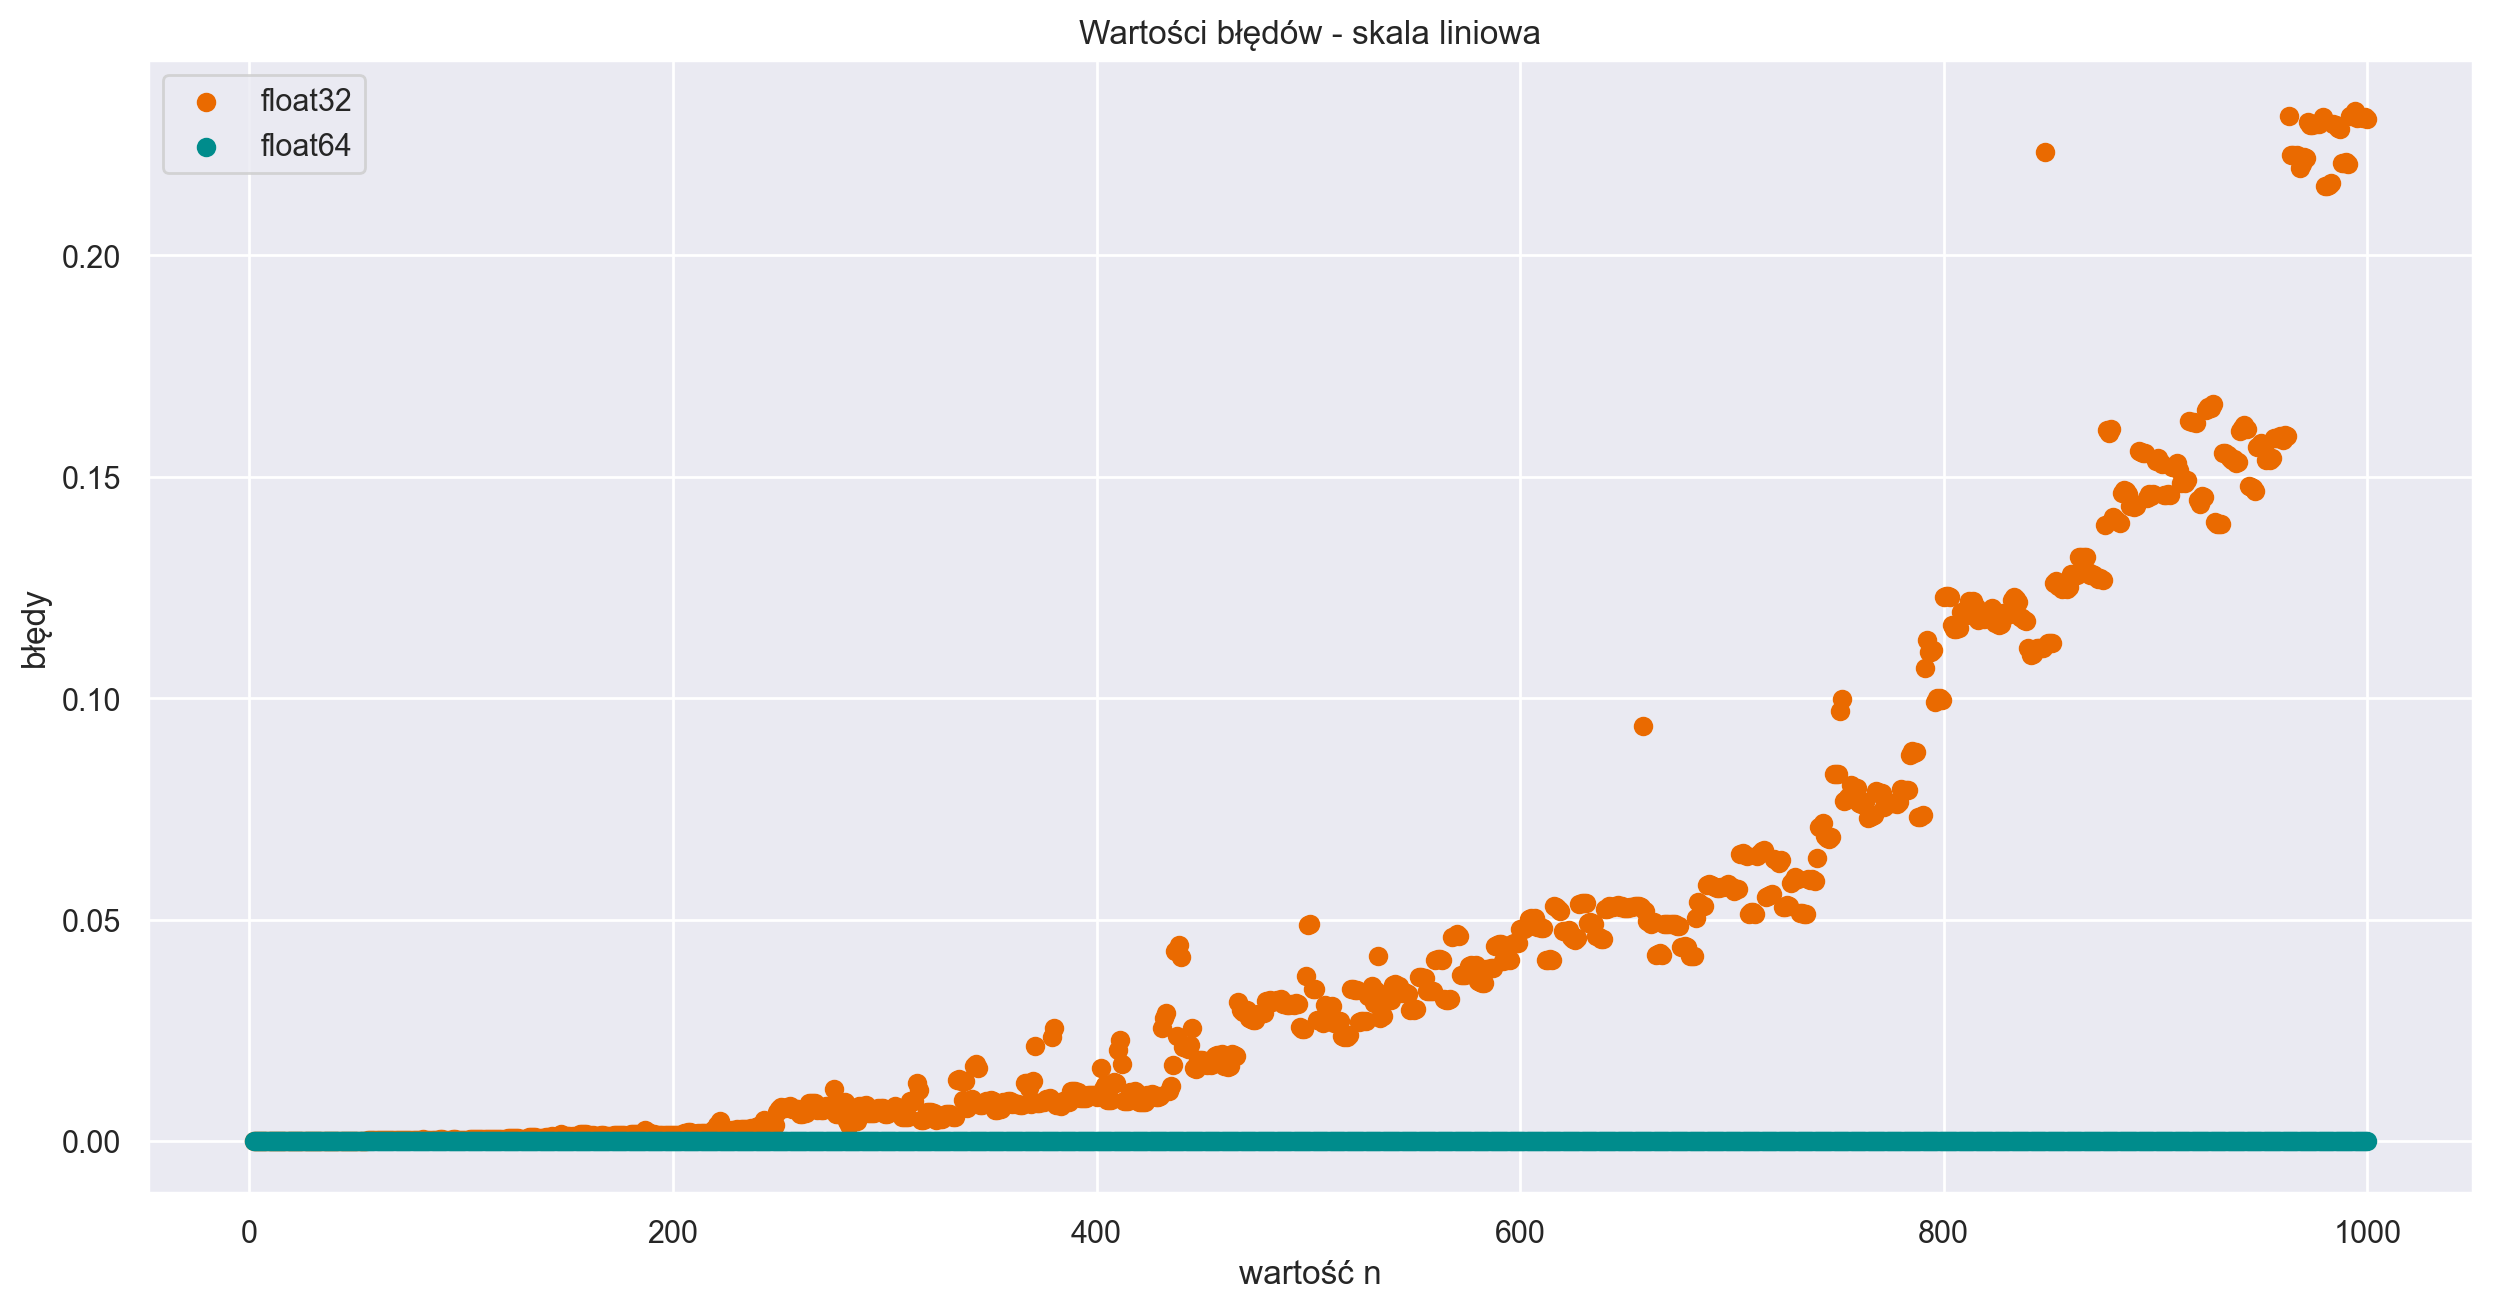

In [132]:
scatter(results2, 'errors', 'Wartości błędów - skala liniowa', 'błędy')

##### Skala logarytmiczna

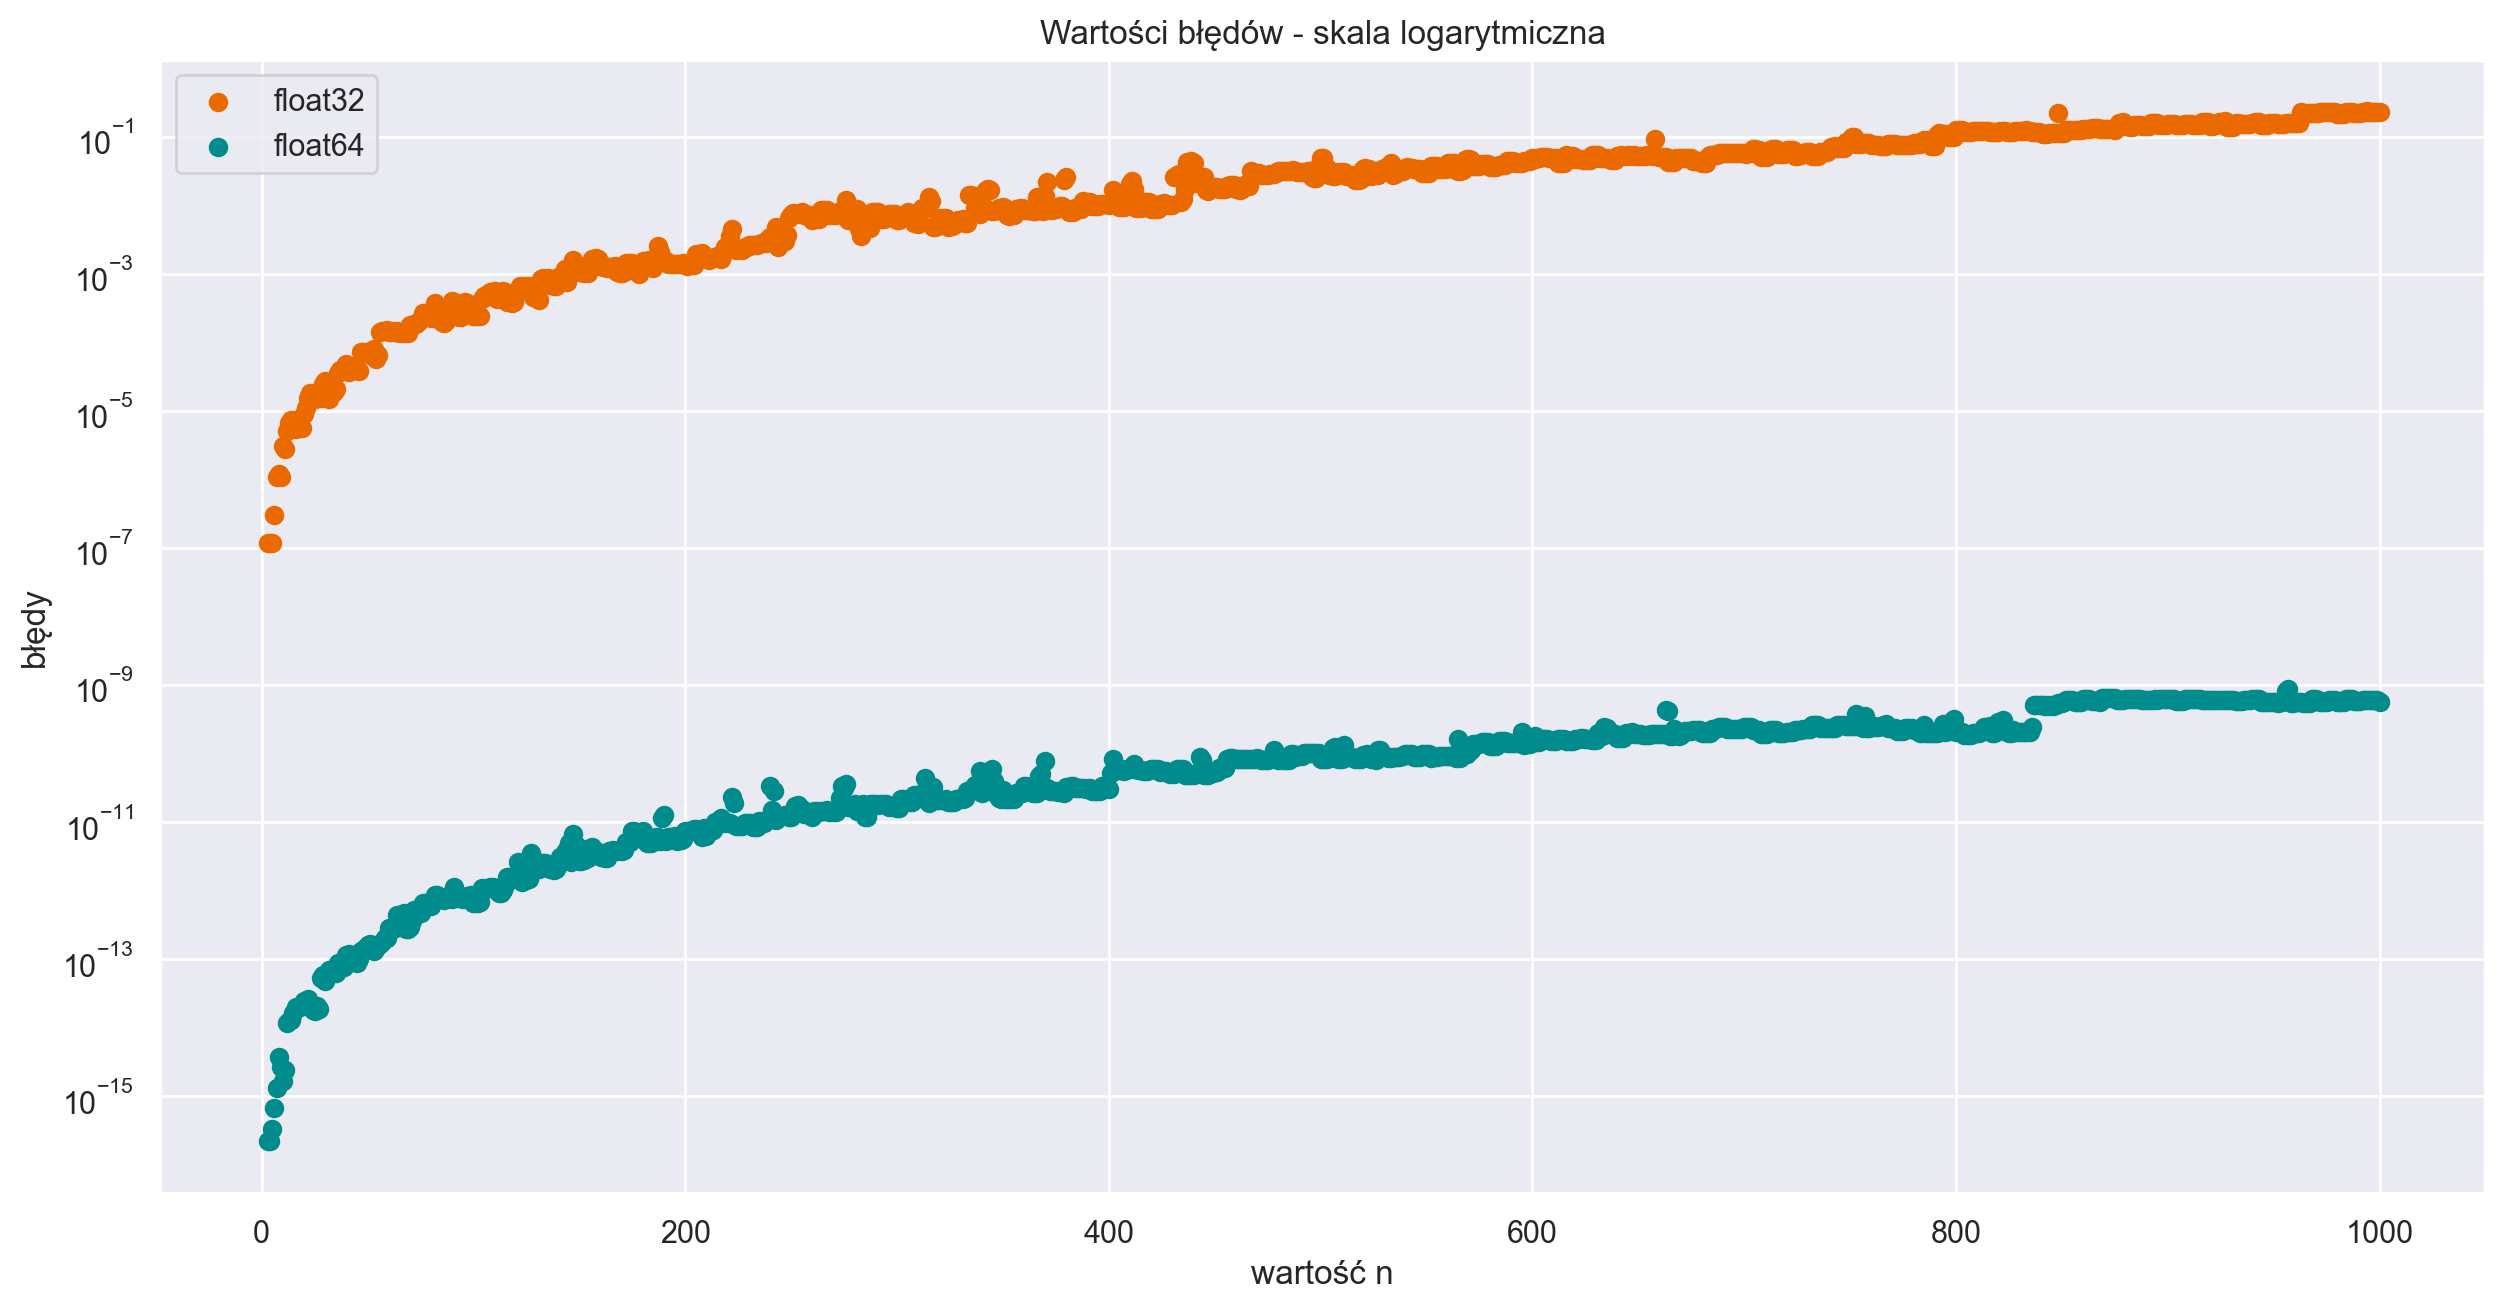

In [133]:
scatter(results2, 'errors', 'Wartości błędów - skala logarytmiczna', 'błędy', 'log')

#### Czasy obliczeń

##### Skala liniowa

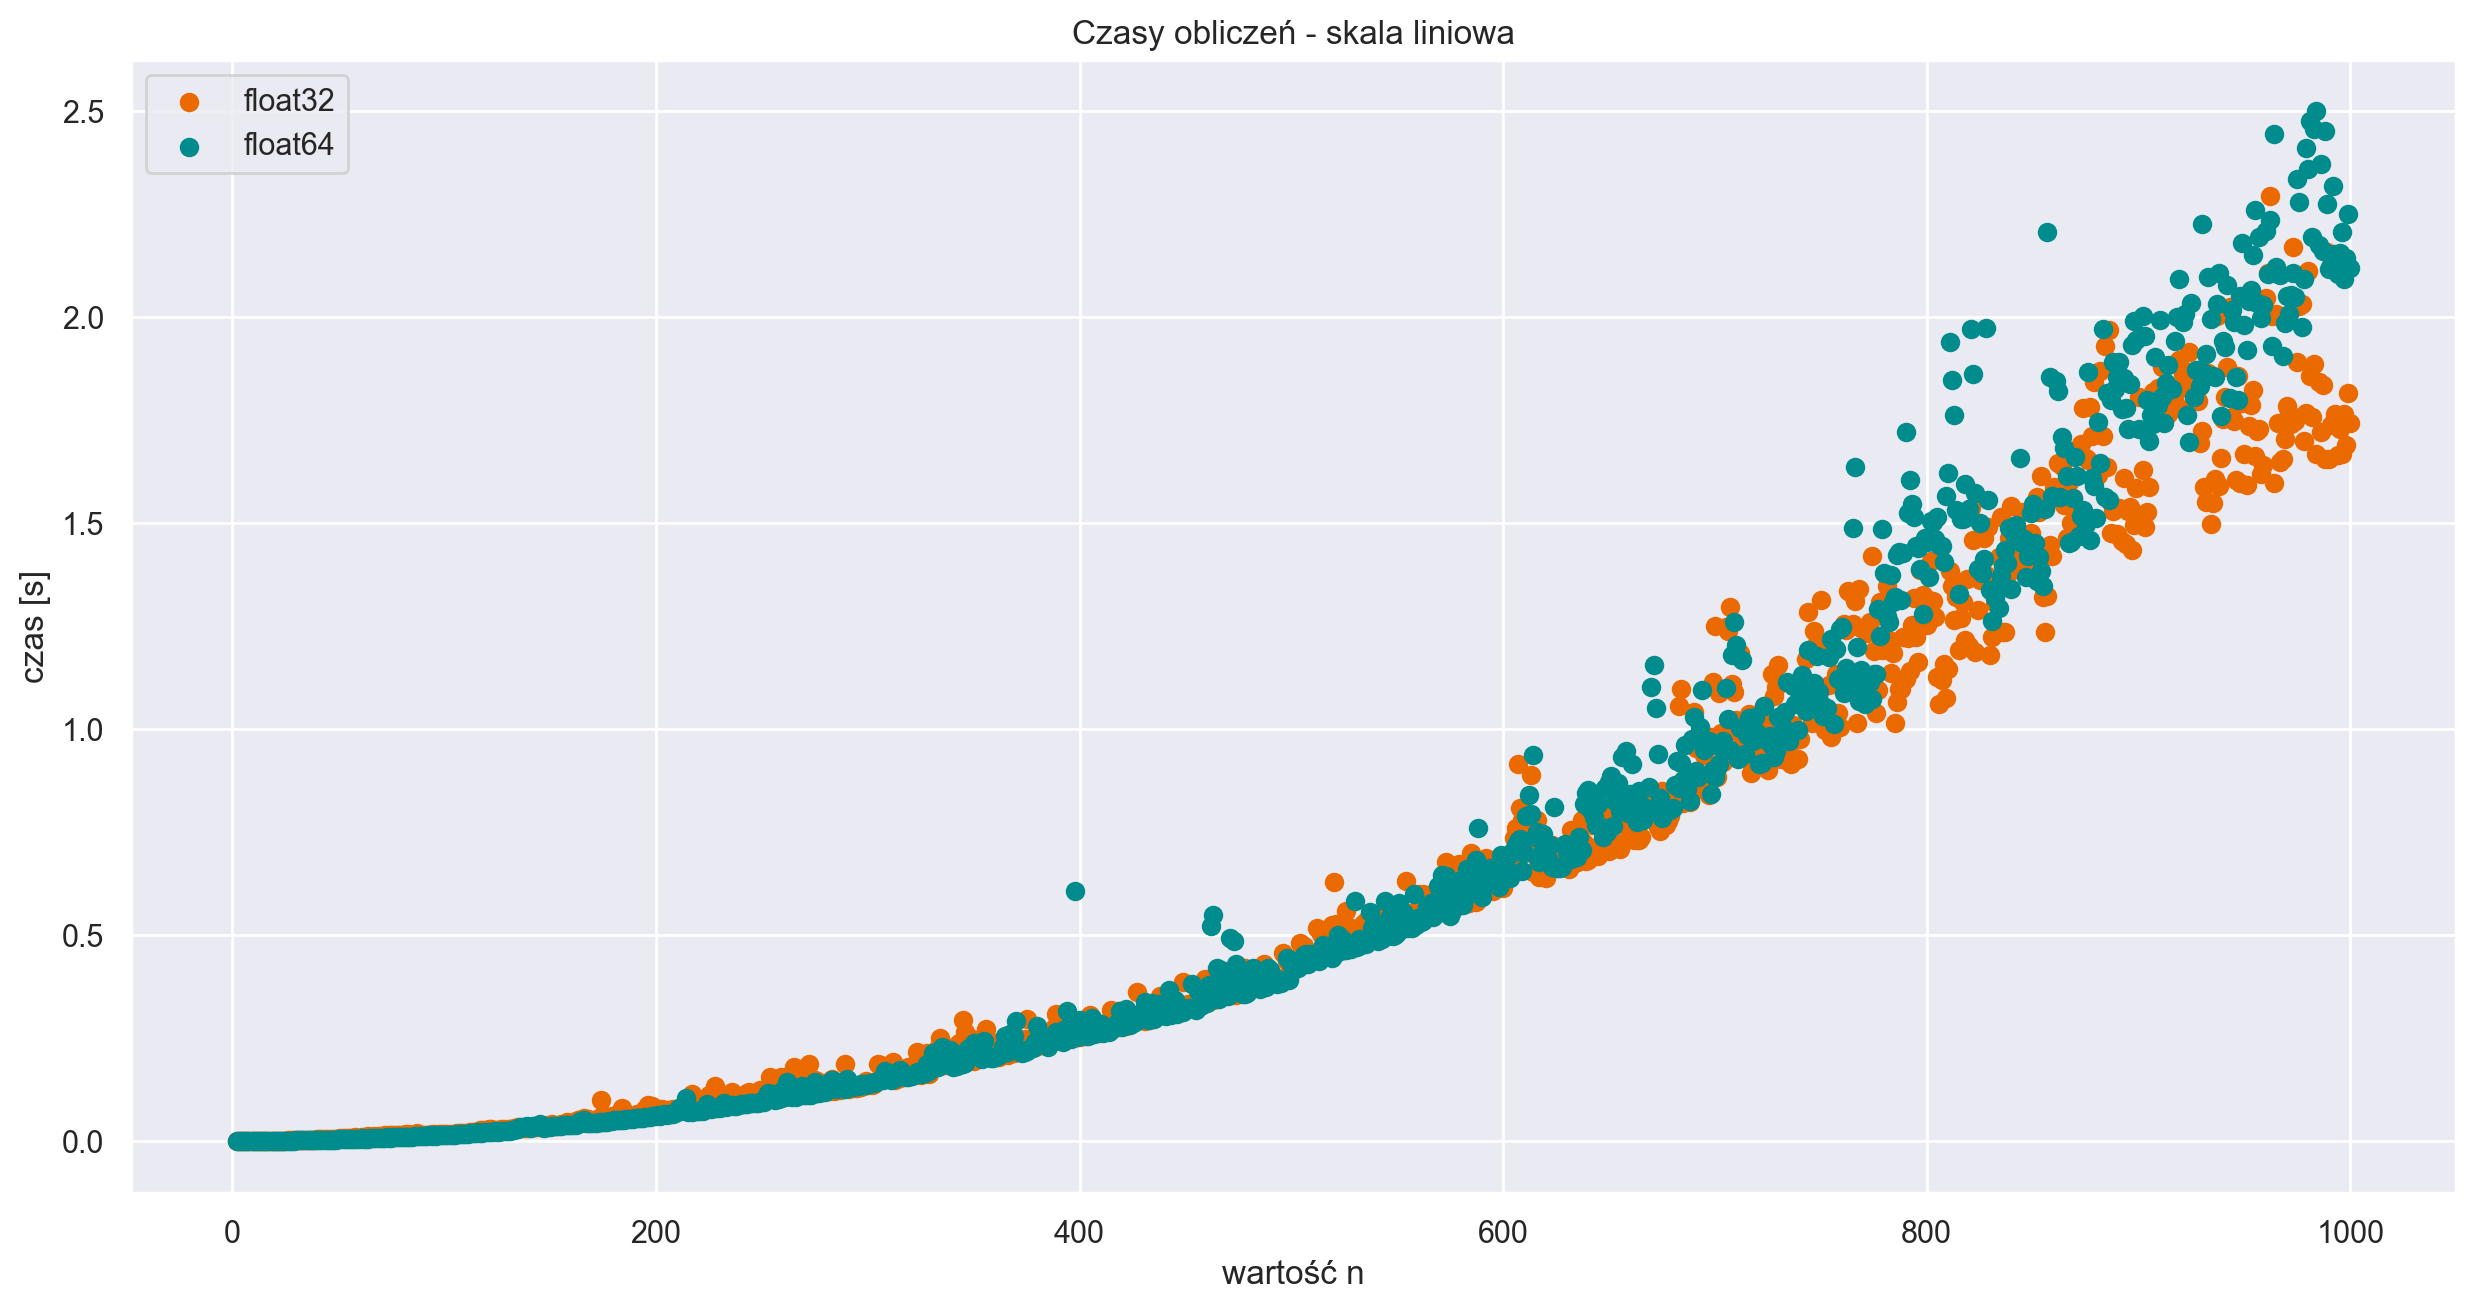

In [134]:
scatter(results2, 'times', 'Czasy obliczeń - skala liniowa', 'czas [s]')

##### Skala logarytmiczna

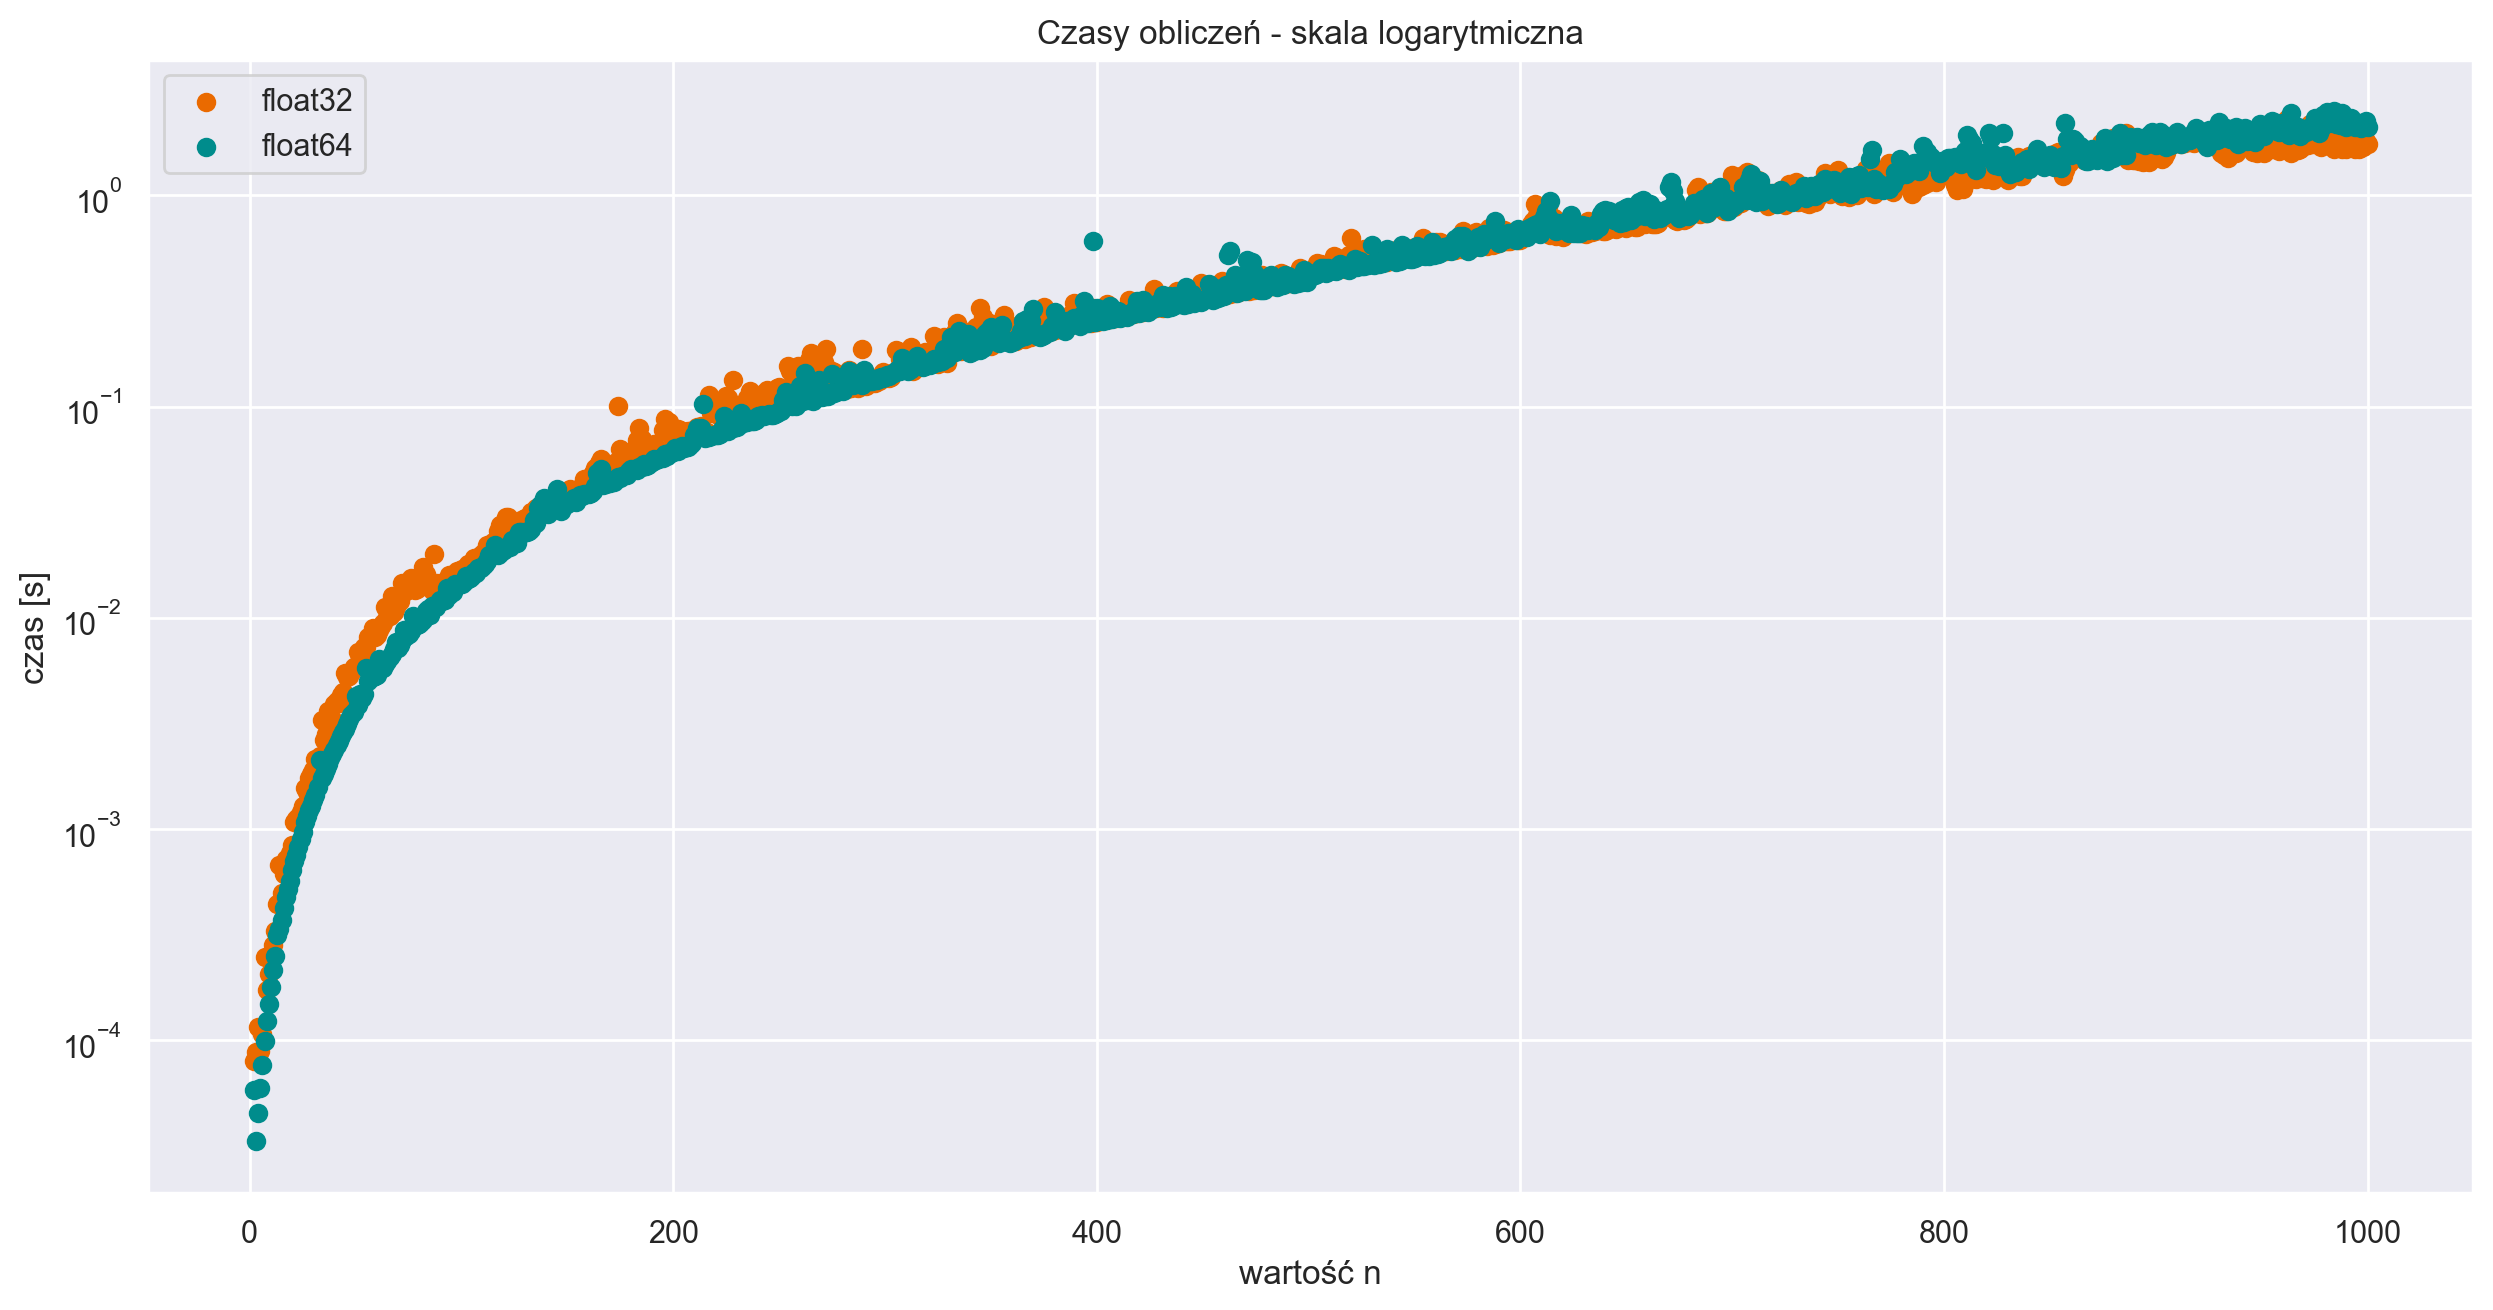

In [135]:
scatter(results2, 'times', 'Czasy obliczeń - skala logarytmiczna', 'czas [s]', 'log')

### Wybrane wartości - zestawienie

Ponownie wykorzystamy zaimplementowaną wcześniej funkcję pomocniczą, tworzącą zestawienie w postaci tabeli.

#### Zestawienie 

In [136]:
min_n = 2
interval = 10

In [137]:
limit = 50

ns_part = list(ns)
ns_part = ns_part[:limit+1-min_n]
df1 = create_summary_df(results2, ns_part)
df1.to_excel('zad2-1.xlsx')
df1

,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
n,,,,
2,0.000000e+00,0.000000e+00,0.000080,0.000058
3,1.192093e-07,2.220446e-16,0.000088,0.000033
4,1.192093e-07,2.220446e-16,0.000116,0.000045
5,1.192093e-07,3.330669e-16,0.000089,0.000059
6,2.980232e-07,6.661338e-16,0.000106,0.000077
7,1.072884e-06,1.332268e-15,0.000248,0.000099
8,1.192093e-06,3.774758e-15,0.000173,0.000123
9,1.072884e-06,2.664535e-15,0.000205,0.000148
10,3.099442e-06,1.665335e-15,0.000242,0.000179


In [138]:
ns_part = list(ns)
ns_part = [ns_part[0], *ns_part[interval-min_n::interval]]
df2 = create_summary_df(results2, ns_part)
df2.to_excel('zad2-2.xlsx')
df2

,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
n,,,,
2,0.000000,0.000000e+00,0.000080,0.000058
10,0.000003,1.665335e-15,0.000242,0.000179
20,0.000009,2.464695e-14,0.000842,0.000639
30,0.000027,4.862777e-14,0.001903,0.001374
40,0.000048,1.145750e-13,0.003920,0.002375
...,...,...,...,...
960,0.158314,5.663189e-10,2.046288,2.208221
970,0.222140,6.146783e-10,1.783211,2.051385
980,0.215633,5.718499e-10,2.112195,2.358279


### Współczynniki uwarunkowania

#### Funkcja, obliczająca współczynnik uwarunkowania macierzy $A$

In [139]:
def norm(A):
    n = len(A)
    return max(sum(A[i, j] for j in range(n)) for i in range(n))

def conditioning_factor(A):
    A_inv = np.linalg.inv(A)
    return norm(A_inv) * norm(A)

### Porównanie uwarunkowania dla macierzy $A$ z zadania 1 i zadania 2

#### Pomocnicze funkcje, tworzące odpowiednie macierze

In [140]:
# Matrix from the 1st exercise
def create_A1(n):
    a = lambda i, j: 1 if i == 1 else 1 / (i + j - 1)
    return create_matrix(a, n, n)
    
# Matrix from the 2nd exercise
def create_A2(n):
    a = lambda i, j: 2 * i / j if j >= i else a(j, i)
    return create_matrix(a, n, n)

#### Zestawienie wartości współczynników uwarunkowania

In [141]:
min_n = 2
max_n = 1000
ns = list(range(min_n, max_n + 1))

cond_fact1 = [conditioning_factor(create_A1(n)) for n in ns]
cond_fact2 = [conditioning_factor(create_A2(n)) for n in ns]

cond_df = pd.DataFrame(zip(cond_fact1, cond_fact2), columns=['Zadanie 1', 'Zadanie 2'], index=ns)
cond_df.to_excel('zad2-cond.xlsx')
cond_df

,Zadanie 1,Zadanie 2
2,8.000000e+00,1.000000
3,2.160000e+02,1.444444
4,2.880000e+03,1.833333
5,2.800000e+04,2.233333
6,2.268000e+05,2.644444
...,...,...
996,1.036692e+20,402.938552
997,1.185927e+21,403.342997
998,5.030733e+19,403.747272
999,3.037849e+20,404.151676


In [142]:
cond_df[10-min_n::10].to_excel('zad2-cond-2.xlsx')

####  Porównanie wartości współczynników uwarunkowania na wykresach

##### Pomocnicza funkcja

In [143]:
def conditioning_factors_plot(df, title, scale=None):
    fig, ax = plt.subplots(figsize=(15, 7.5))
    if scale: ax.set_yscale(scale)
    plt.scatter(x=df.index.tolist(), y=df['Zadanie 1'], c='#EA6A00', label='Zadanie 1')
    plt.scatter(x=df.index.tolist(), y=df['Zadanie 2'], c='#008C8C', label='Zadanie 2')
    plt.title(title)
    plt.xlabel('wartość n')
    plt.ylabel('współczynnik uwarunkowania')
    plt.legend()
    plt.show()

##### Wykresy

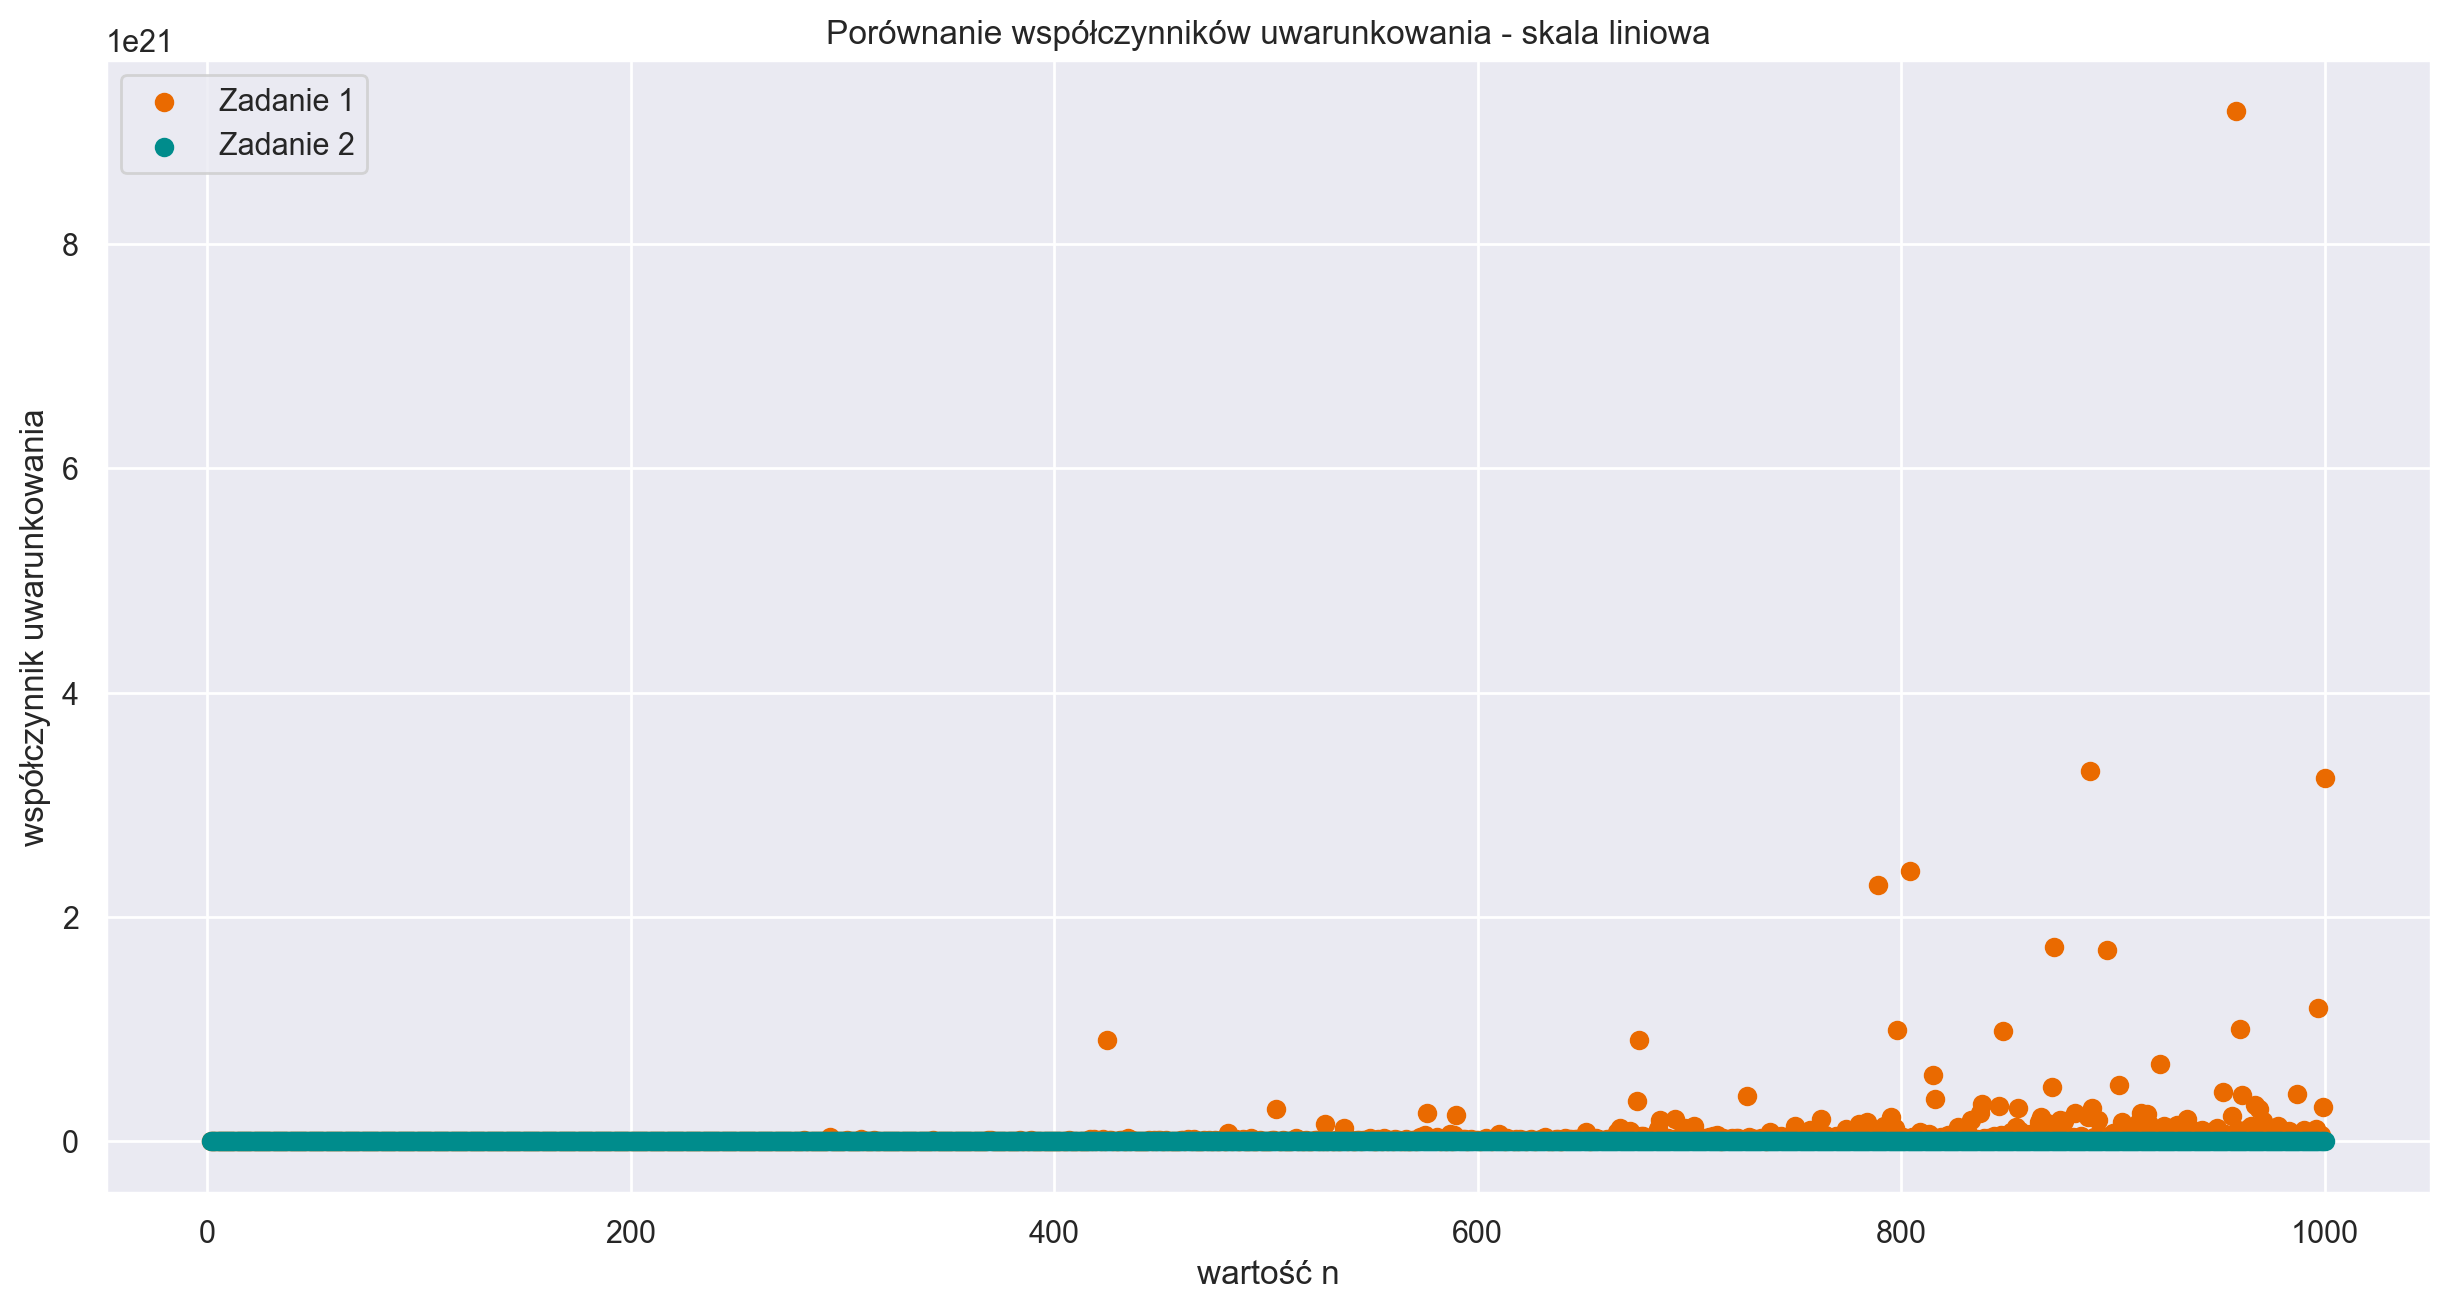

In [144]:
conditioning_factors_plot(cond_df, 'Porównanie współczynników uwarunkowania - skala liniowa')

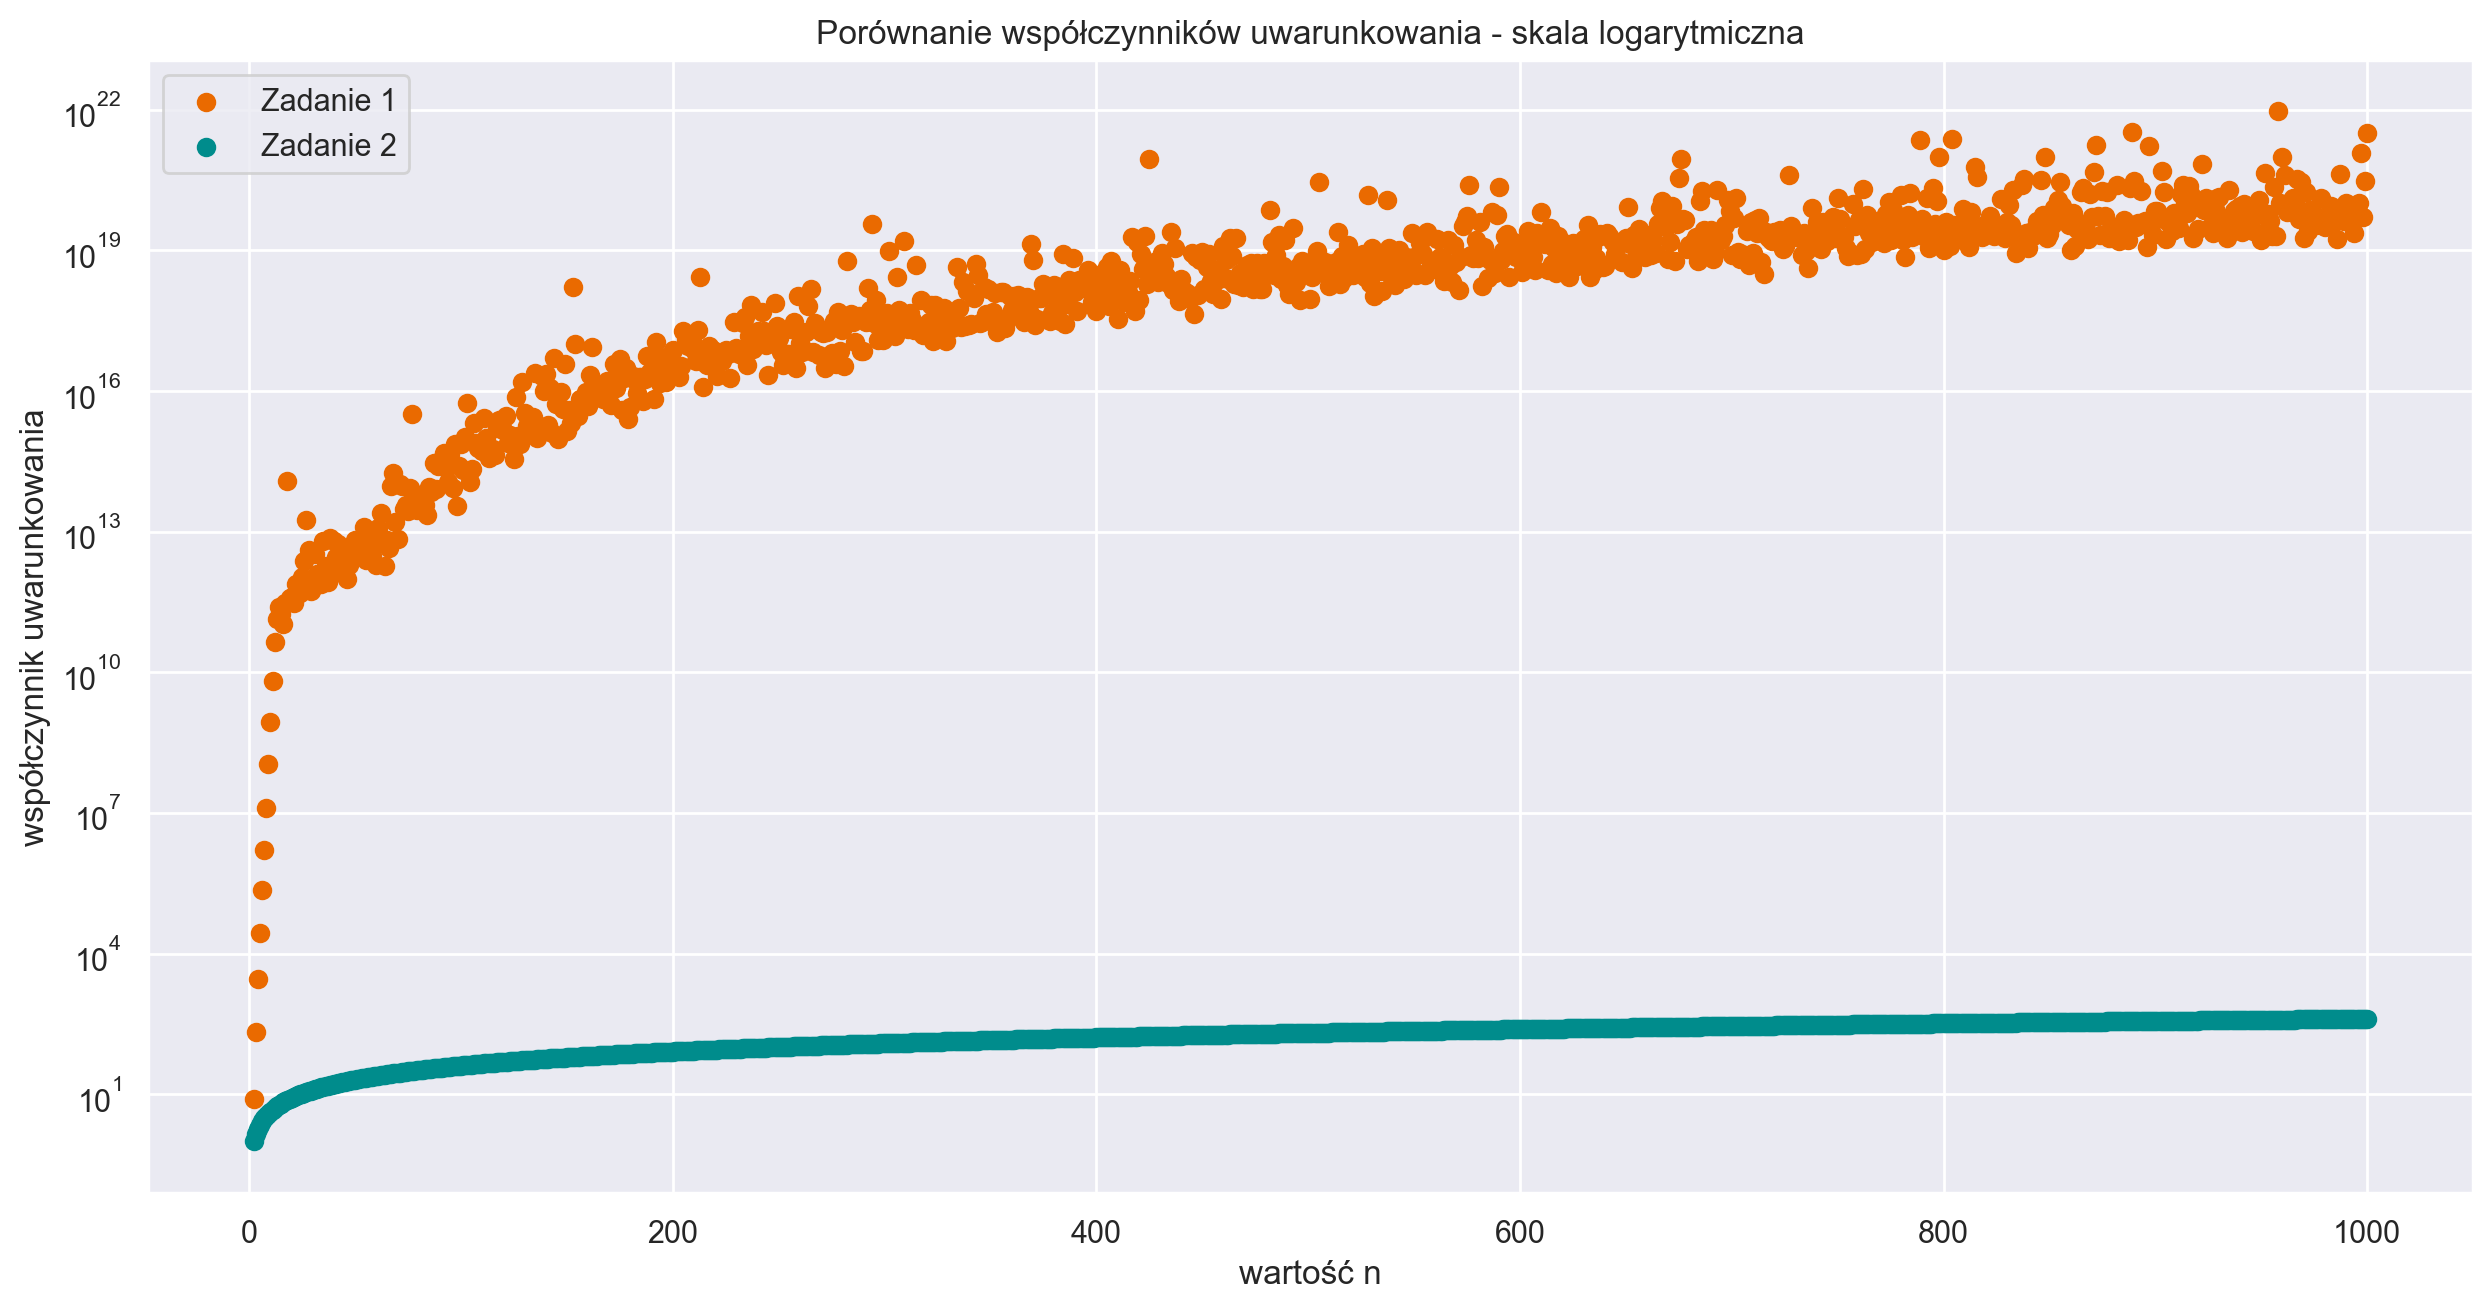

In [145]:
conditioning_factors_plot(cond_df, 'Porównanie współczynników uwarunkowania - skala logarytmiczna', 'log')

# Zadanie 3

## Opis problemu

Elementy macierzy $A$ dane są wzorem:

$
\begin{cases} 
    a_{i, i} = k \\ 
    a_{i, i + 1} = \frac{1}{i + m} \\
    a_{i, i - 1} = \frac{k}{1 + m + i} & dla & i > 1 \\
    a_{i, j} = 0 & dla & j < i - 1 & oraz & j > i + 1 \\
\end{cases}
$

gdzie $i, j \in \{1, 2, ..., n\}$

W zadaniu indywidualnym otrzymałem następujące parametry:

$k=8$

$m=3$

## Tworzenie macierzy

### Implementacja funkcji, zgodnie z którą wypełnione są elementy macierzy $A$

In [146]:
k = 8
m = 3

def fn(i: int, j: int) -> float:
    if j == i: return k
    if j == i + 1: return 1 / (i + m)
    if j == i - 1: return k / (1 + m + i)
    return 0

###### Test

In [147]:
n = 5
A = create_matrix(fn, n, n)
A

array([[8.        , 0.25      , 0.        , 0.        , 0.        ],
       [1.33333333, 8.        , 0.2       , 0.        , 0.        ],
       [0.        , 1.14285714, 8.        , 0.16666667, 0.        ],
       [0.        , 0.        , 1.        , 8.        , 0.14285714],
       [0.        , 0.        , 0.        , 0.88888889, 8.        ]])

## Rozwiązanie zadania

### Rozwiązywanie metodą eliminacji Gaussa
#### (tak, jak w poprzednich zadaniach)

Resetujemy wyniki poprzednich obliczeń

In [148]:
times.clear()

Ponownie korzystamy z wcześniejszego kodu.

In [149]:
ns = range(2, 1001)
precs = {
    'float32': np.float32, 
    'float64': np.float64
}
results3_gauss = calculate(ns, precs)
print_duration(times['total'])

========== float32 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań
Obliczono 200 układów równań
Obliczono 225 układów równań
Obliczono 250 układów równań
Obliczono 275 układów równań
Obliczono 300 układów równań
Obliczono 325 układów równań
Obliczono 350 układów równań
Obliczono 375 układów równań
Obliczono 400 układów równań
Obliczono 425 układów równań
Obliczono 450 układów równań
Obliczono 475 układów równań
Obliczono 500 układów równań
Obliczono 525 układów równań
Obliczono 550 układów równań
Obliczono 575 układów równań
Obliczono 600 układów równań
Obliczono 625 układów równań
Obliczono 650 układów równań
Obliczono 675 układów równań
Obliczono 700 układów równań
Obliczono 725 układów równań
Obliczono 750 układów równań
Obliczono 775 układów równań
Obliczono 800 układów równań
Obliczono 825 układów równań
Obliczono 850 uk

### Wykresy

Możemy ponownie użyć tej samej funkcji.

#### Błędy obliczeń

##### Skala liniowa

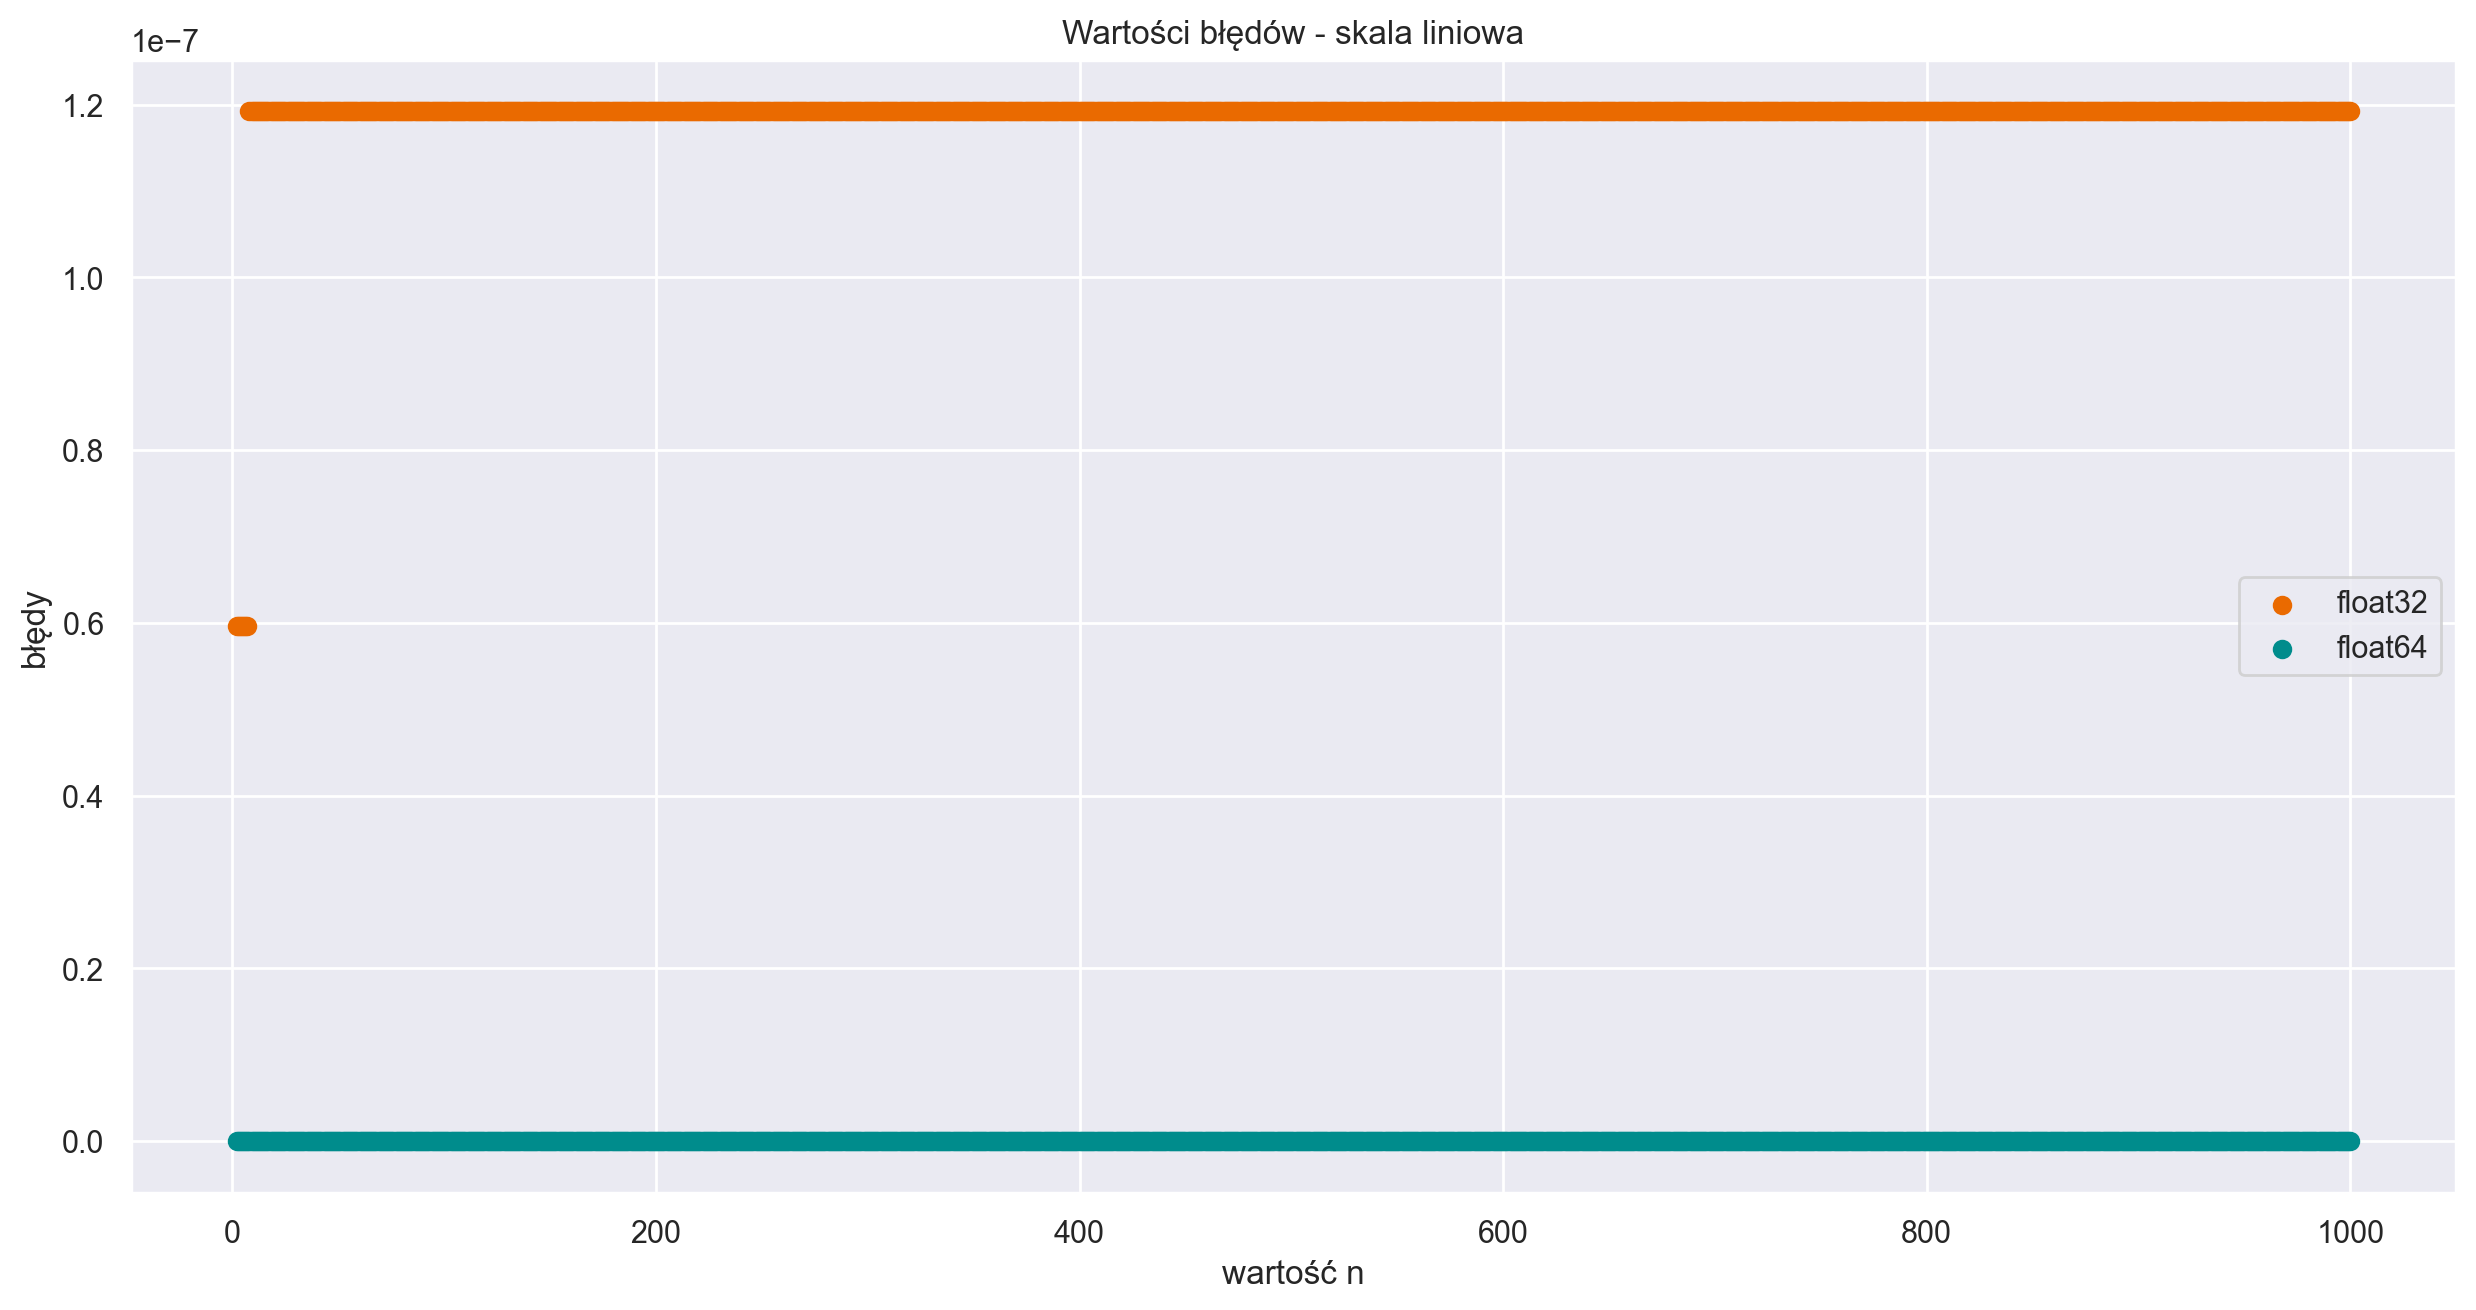

In [150]:
scatter(results3_gauss, 'errors', 'Wartości błędów - skala liniowa', 'błędy')

##### Skala logarytmiczna

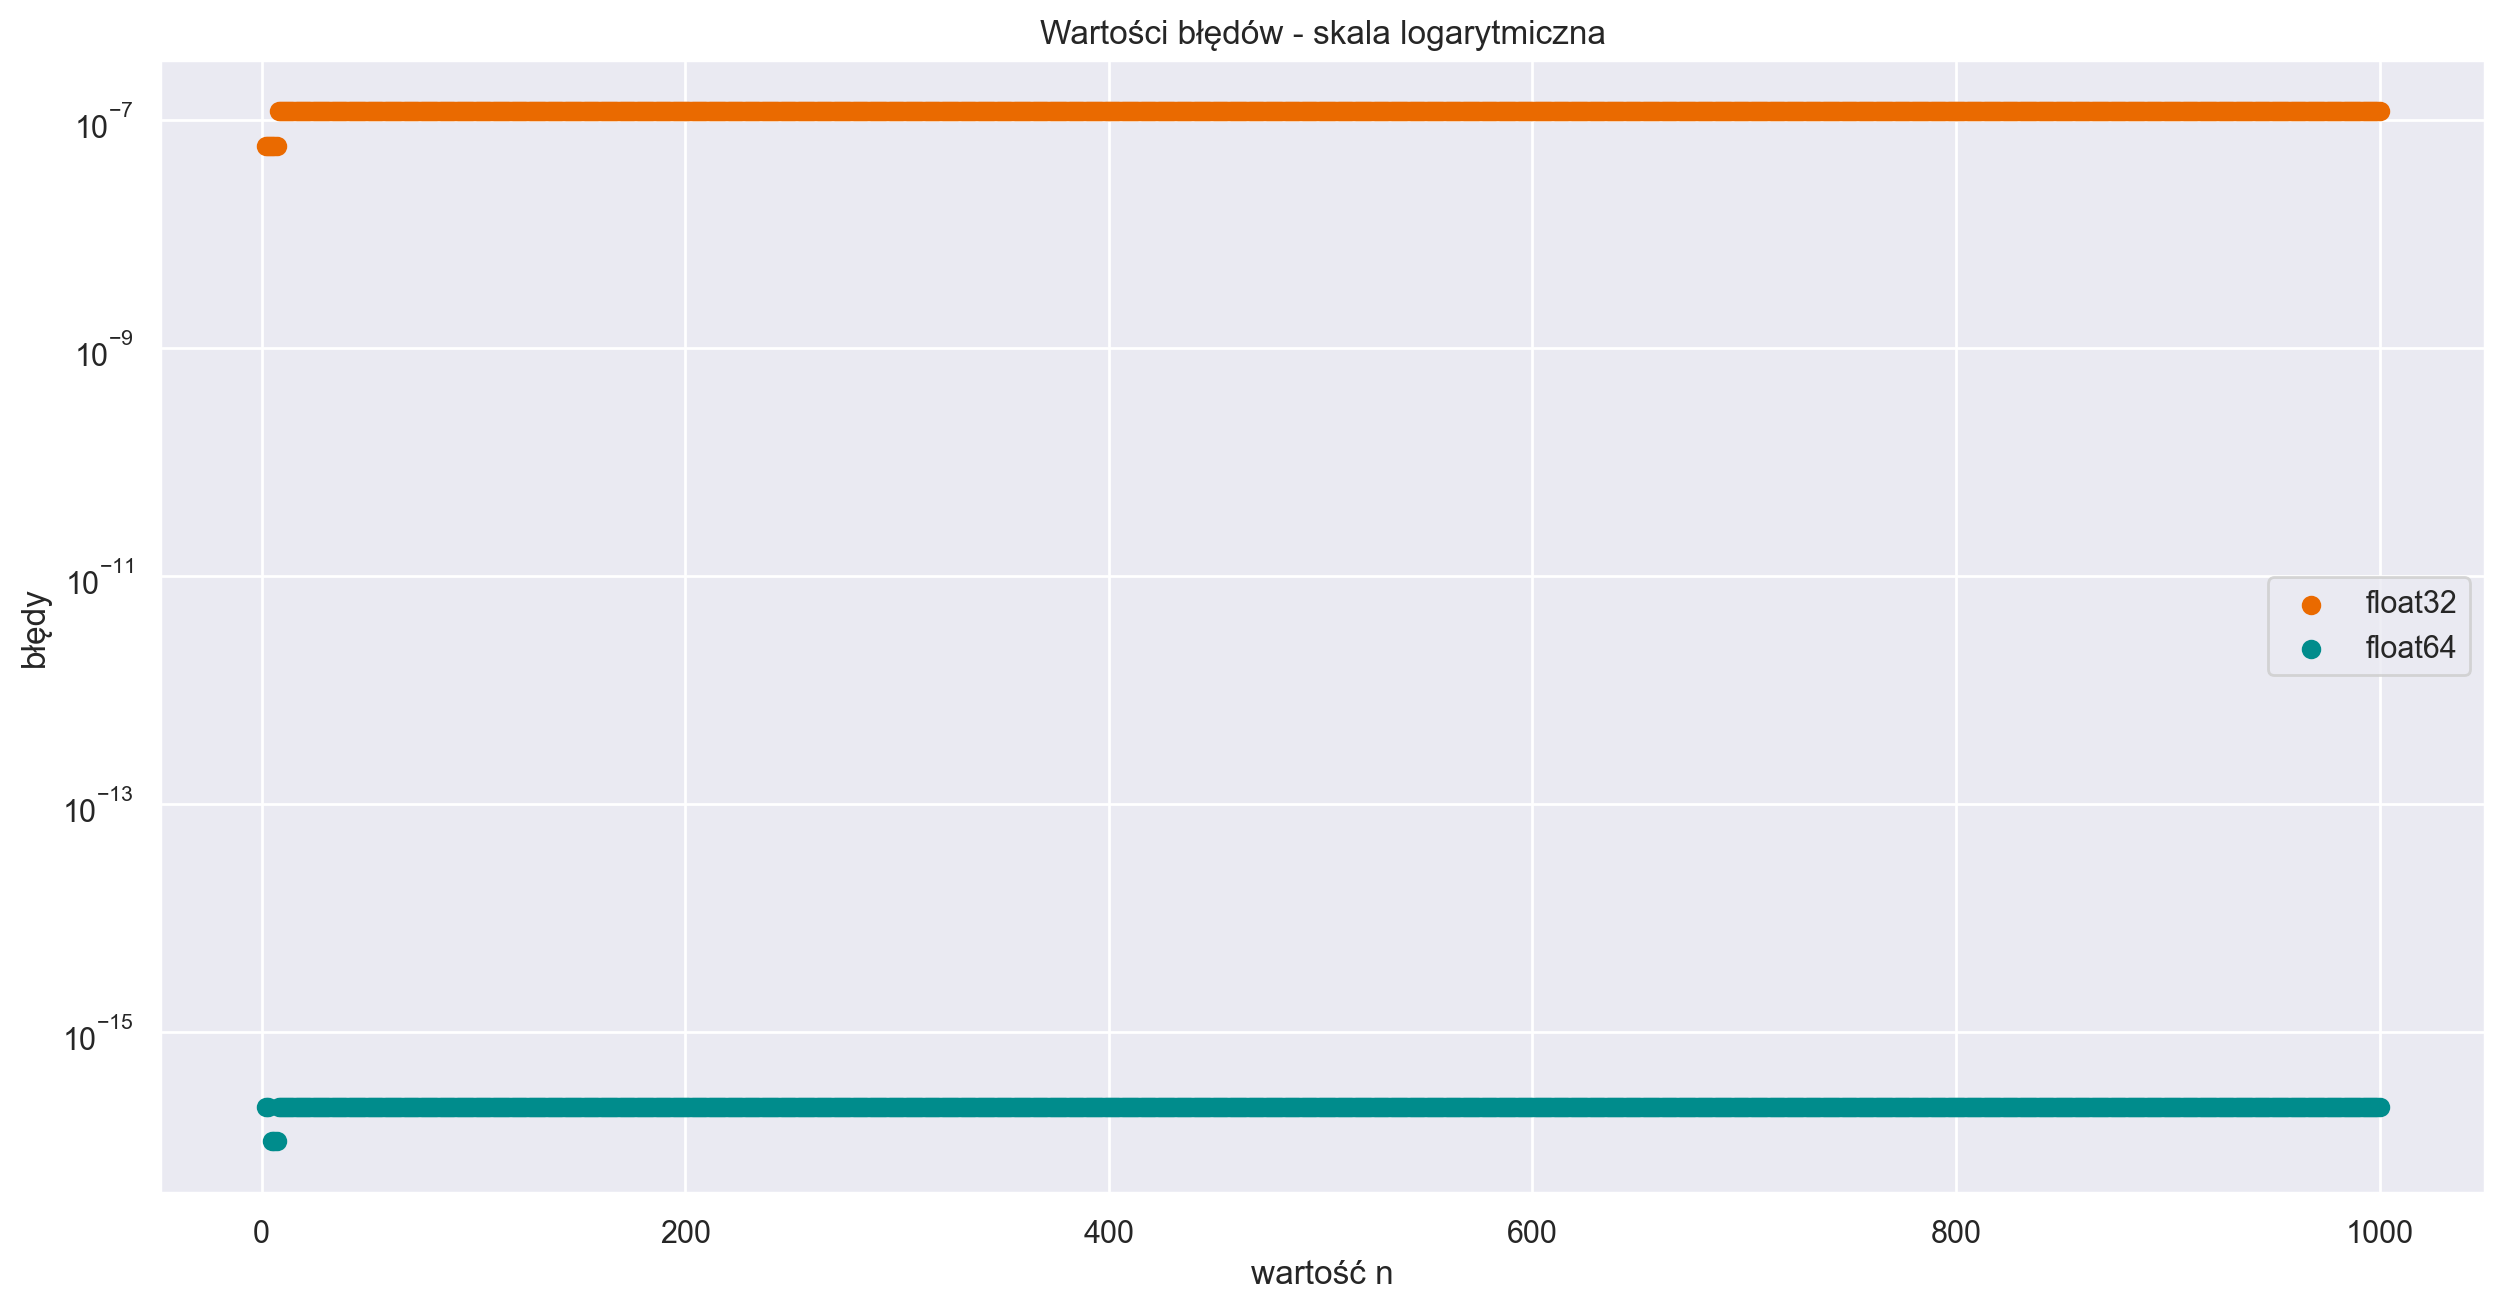

In [151]:
scatter(results3_gauss, 'errors', 'Wartości błędów - skala logarytmiczna', 'błędy', 'log')

#### Czasy obliczeń

##### Skala liniowa

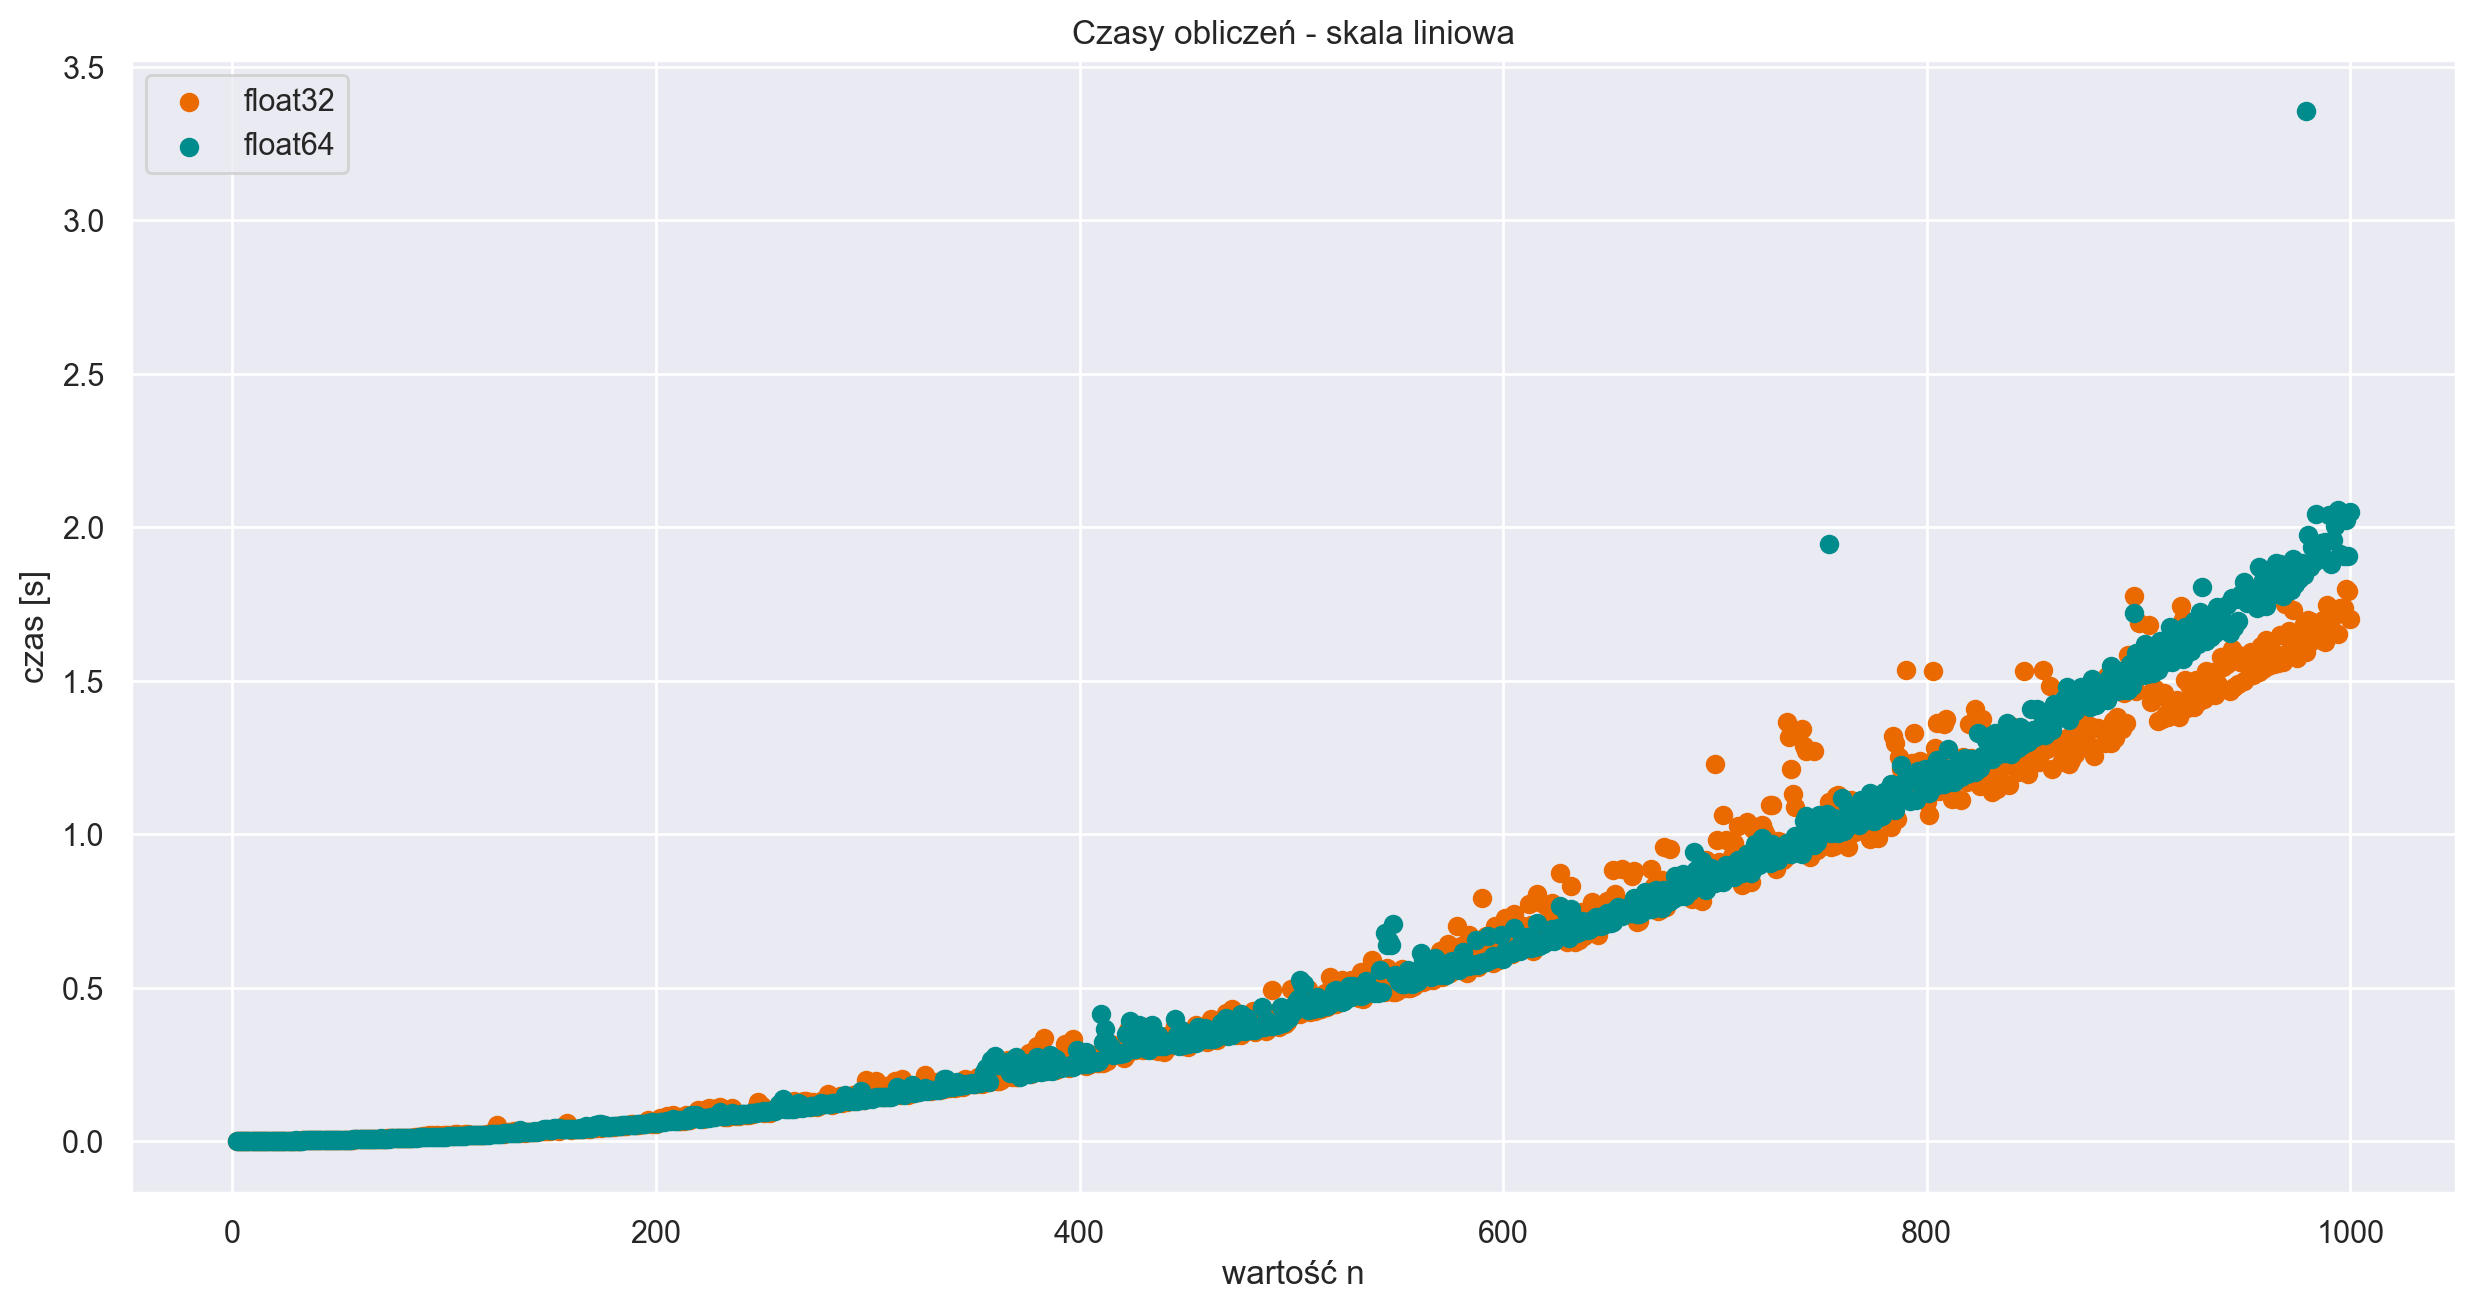

In [152]:
scatter(results3_gauss, 'times', 'Czasy obliczeń - skala liniowa', 'czas [s]')

##### Skala logarytmiczna

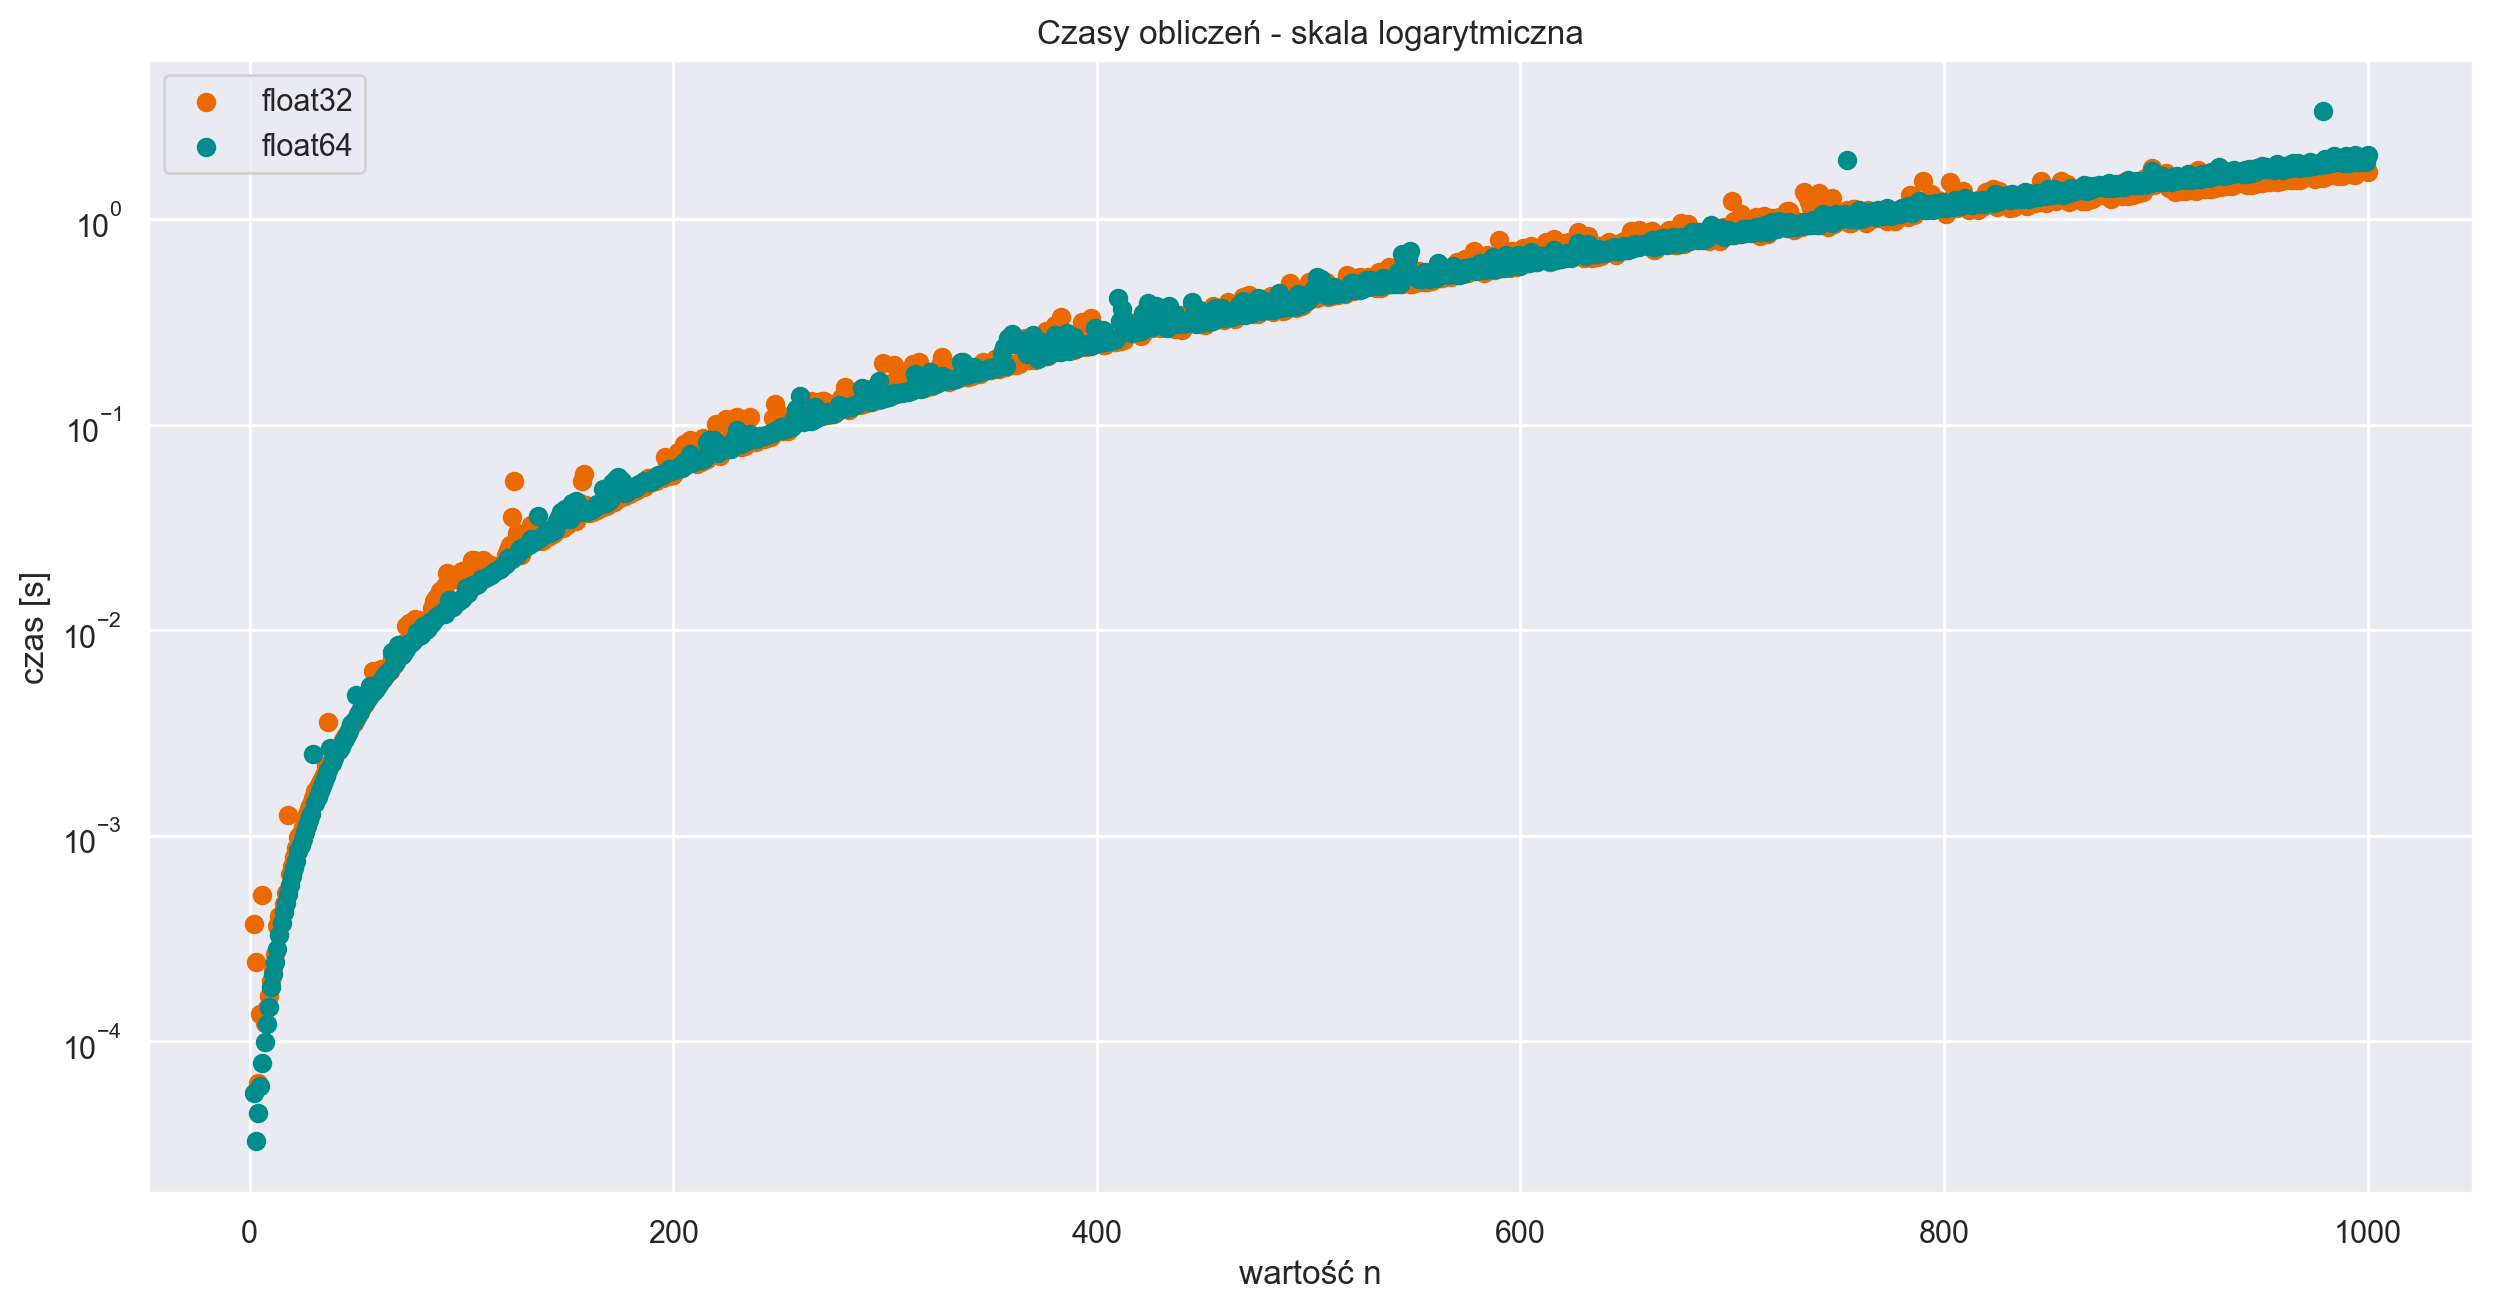

In [153]:
scatter(results3_gauss, 'times', 'Czasy obliczeń - skala logarytmiczna', 'czas [s]', 'log')

### Wybrane wartości - zestawienie

Ponownie wykorzystamy zaimplementowaną wcześniej funkcję pomocniczą, tworzącą zestawienie w postaci tabeli.

#### Zestawienie 

In [154]:
min_n = 2
interval = 10

In [155]:
limit = 50

ns_part = list(ns)
ns_part = ns_part[:limit+1-min_n]
df1 = create_summary_df(results3_gauss, ns_part)
df1.to_excel('zad3-1.xlsx')
df1

,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
n,,,,
2,5.960464e-08,2.220446e-16,0.000372,0.000056
3,5.960464e-08,2.220446e-16,0.000242,0.000033
4,5.960464e-08,0.000000e+00,0.000063,0.000045
5,5.960464e-08,1.110223e-16,0.000136,0.000060
6,5.960464e-08,1.110223e-16,0.000517,0.000078
7,5.960464e-08,1.110223e-16,0.000122,0.000099
8,1.192093e-07,2.220446e-16,0.000145,0.000122
9,1.192093e-07,2.220446e-16,0.000166,0.000147
10,1.192093e-07,2.220446e-16,0.000197,0.000184


In [156]:
ns_part = list(ns)
ns_part = [ns_part[0], *ns_part[interval-min_n::interval]]
df2 = create_summary_df(results3_gauss, ns_part)
df2.to_excel('zad3-2.xlsx')
df2

,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
n,,,,
2,5.960464e-08,2.220446e-16,0.000372,0.000056
10,1.192093e-07,2.220446e-16,0.000197,0.000184
20,1.192093e-07,2.220446e-16,0.000713,0.000637
30,1.192093e-07,2.220446e-16,0.001521,0.002501
40,1.192093e-07,2.220446e-16,0.002574,0.002383
...,...,...,...,...
960,1.192093e-07,2.220446e-16,1.633250,1.743112
970,1.192093e-07,2.220446e-16,1.648869,1.797336
980,1.192093e-07,2.220446e-16,1.697297,1.974095


### Rozwiązywanie metodą Thomasa
#### (Metodą przeznaczoną do macierzy trójdiagonalnej)

#### Implementacja algorytmu

##### Dla macierzy $A$ o wymiarach $n\times n$

In [157]:
@timed(
    save_fn=lambda A, *args, **kwargs: len(A),
    save_dict=times
)
def thomas(A: np.ndarray, B: np.ndarray, dtype=np.float64) -> np.ndarray:
    n = len(A)
    C = np.zeros(n, dtype)
    C[0] = A[0, 0]
    X = np.zeros(n, dtype)
    X[0] = B[0]

    for i in range(1, n):
        factor = A[i, i - 1] / C[i - 1]
        C[i] = A[i, i] - factor * A[i - 1, i]
        X[i] = B[i] - factor * X[i - 1]
        
    X[n - 1] = X[n - 1] / C[n - 1]
    for i in range(n - 2, -1, -1):
        X[i] = (X[i] - A[i, i + 1] * X[i + 1]) / C[i]

    return X

#### Dla zmodyfikowanej reprezentacji macierzy $A$ w postaci tablicy $n\times 3$

In [158]:
@timed(
    save_fn=lambda A, *args, **kwargs: len(A),
    save_dict=times
)
def thomas_column(A: np.ndarray, B: np.ndarray, dtype=np.float64) -> np.ndarray:
    n = len(A)
    C = np.zeros(n, dtype)
    C[0] = A[0, 1]
    X = np.zeros(n, dtype)
    X[0] = B[0]

    for i in range(1, n):
        factor = A[i, 0] / C[i - 1]
        C[i] = A[i, 1] - factor * A[i - 1, 2]
        X[i] = B[i] - factor * X[i - 1]
        
    X[n - 1] = X[n - 1] / C[n - 1]
    for i in range(n - 2, -1, -1):
        X[i] = (X[i] - A[i, 2] * X[i + 1]) / C[i]

    return X

###### Test

In [159]:
random.seed(0)

n = 5
A = create_matrix(fn, n, n)
X = create_vector(lambda i: 1 if random.random() > .5 else -1, n)
B = A @ X
A_column = create_thomas_matrix(fn, n)

In [160]:
X_res = thomas(A, B)
X, X_res

(array([ 1.,  1., -1., -1.,  1.]), array([ 1.,  1., -1., -1.,  1.]))

In [161]:
X_res = thomas_column(A_column, B)
X, X_res

(array([ 1.,  1., -1., -1.,  1.]), array([ 1.,  1., -1., -1.,  1.]))

#### Wyznaczanie rozwiązań

Resetujemy wyniki poprzednich obliczeń

In [162]:
times.clear()

Ponownie korzystamy z wcześniejszego kodu.

In [163]:
ns = range(2, 1001)
precs = {
    'float32': np.float32, 
    'float64': np.float64
}
results3_thomas = calculate(ns, precs, calc_method=thomas_column, create_matrix_method=create_thomas_matrix)
print_duration(times['total'])

========== float32 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań
Obliczono 200 układów równań
Obliczono 225 układów równań
Obliczono 250 układów równań
Obliczono 275 układów równań
Obliczono 300 układów równań
Obliczono 325 układów równań
Obliczono 350 układów równań
Obliczono 375 układów równań
Obliczono 400 układów równań
Obliczono 425 układów równań
Obliczono 450 układów równań
Obliczono 475 układów równań
Obliczono 500 układów równań
Obliczono 525 układów równań
Obliczono 550 układów równań
Obliczono 575 układów równań
Obliczono 600 układów równań
Obliczono 625 układów równań
Obliczono 650 układów równań
Obliczono 675 układów równań
Obliczono 700 układów równań
Obliczono 725 układów równań
Obliczono 750 układów równań
Obliczono 775 układów równań
Obliczono 800 układów równań
Obliczono 825 układów równań
Obliczono 850 uk

### Wykresy

Możemy ponownie użyć tej samej funkcji.

#### Błędy obliczeń

##### Skala liniowa

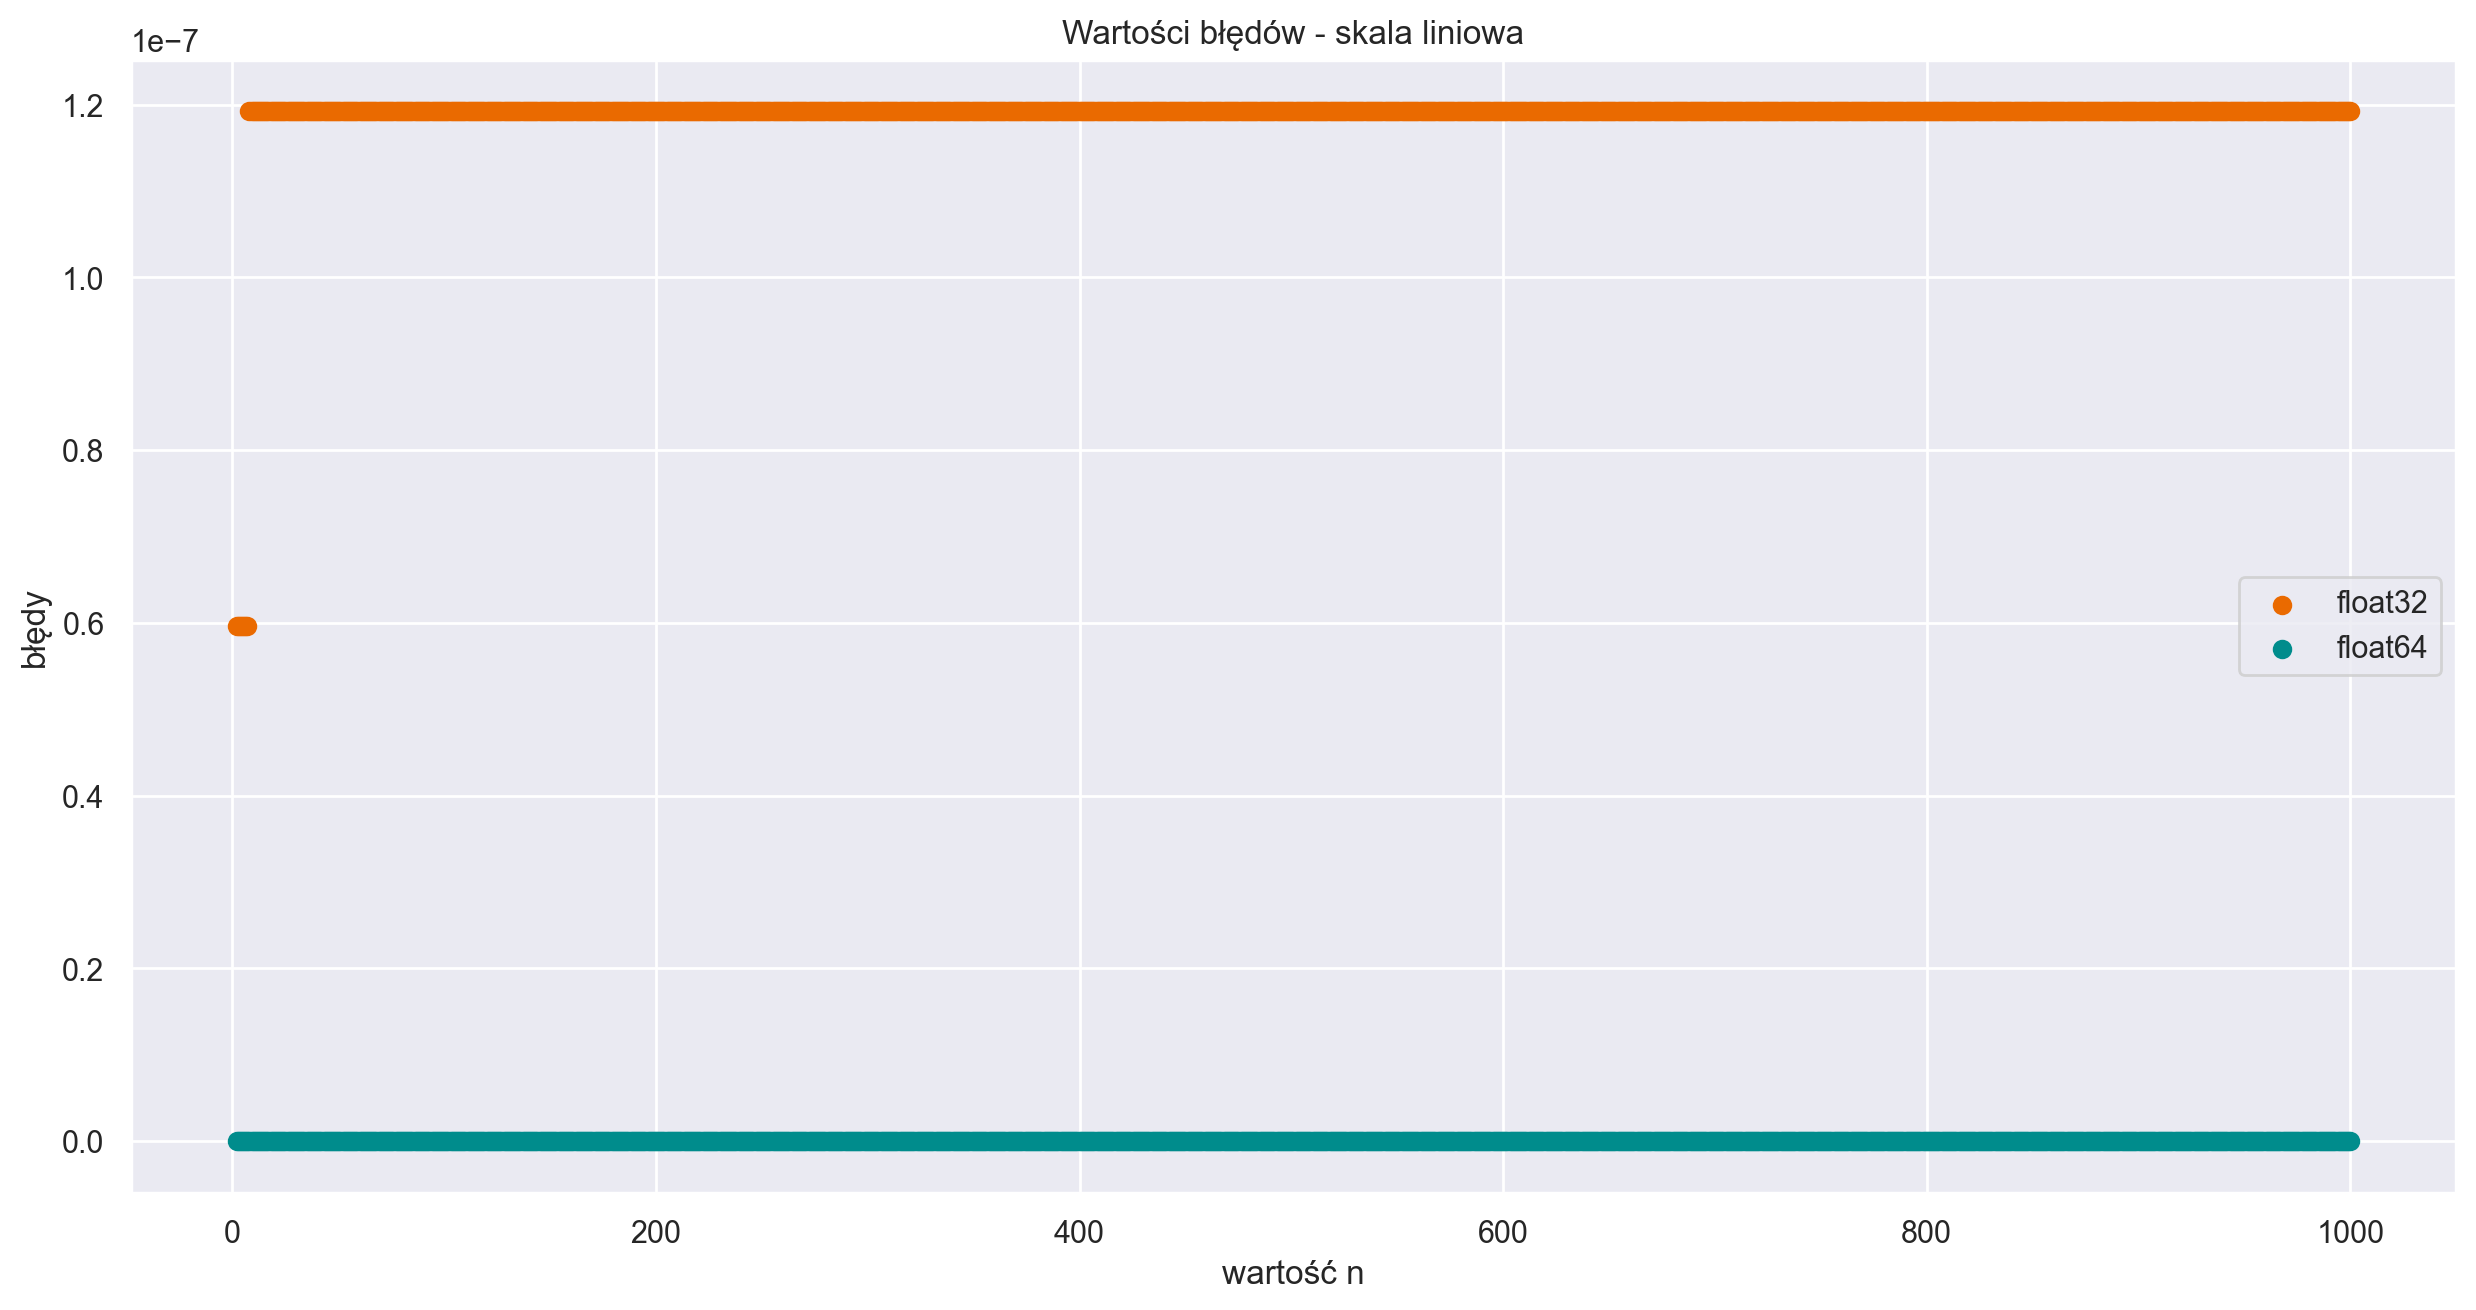

In [164]:
scatter(results3_thomas, 'errors', 'Wartości błędów - skala liniowa', 'błędy')

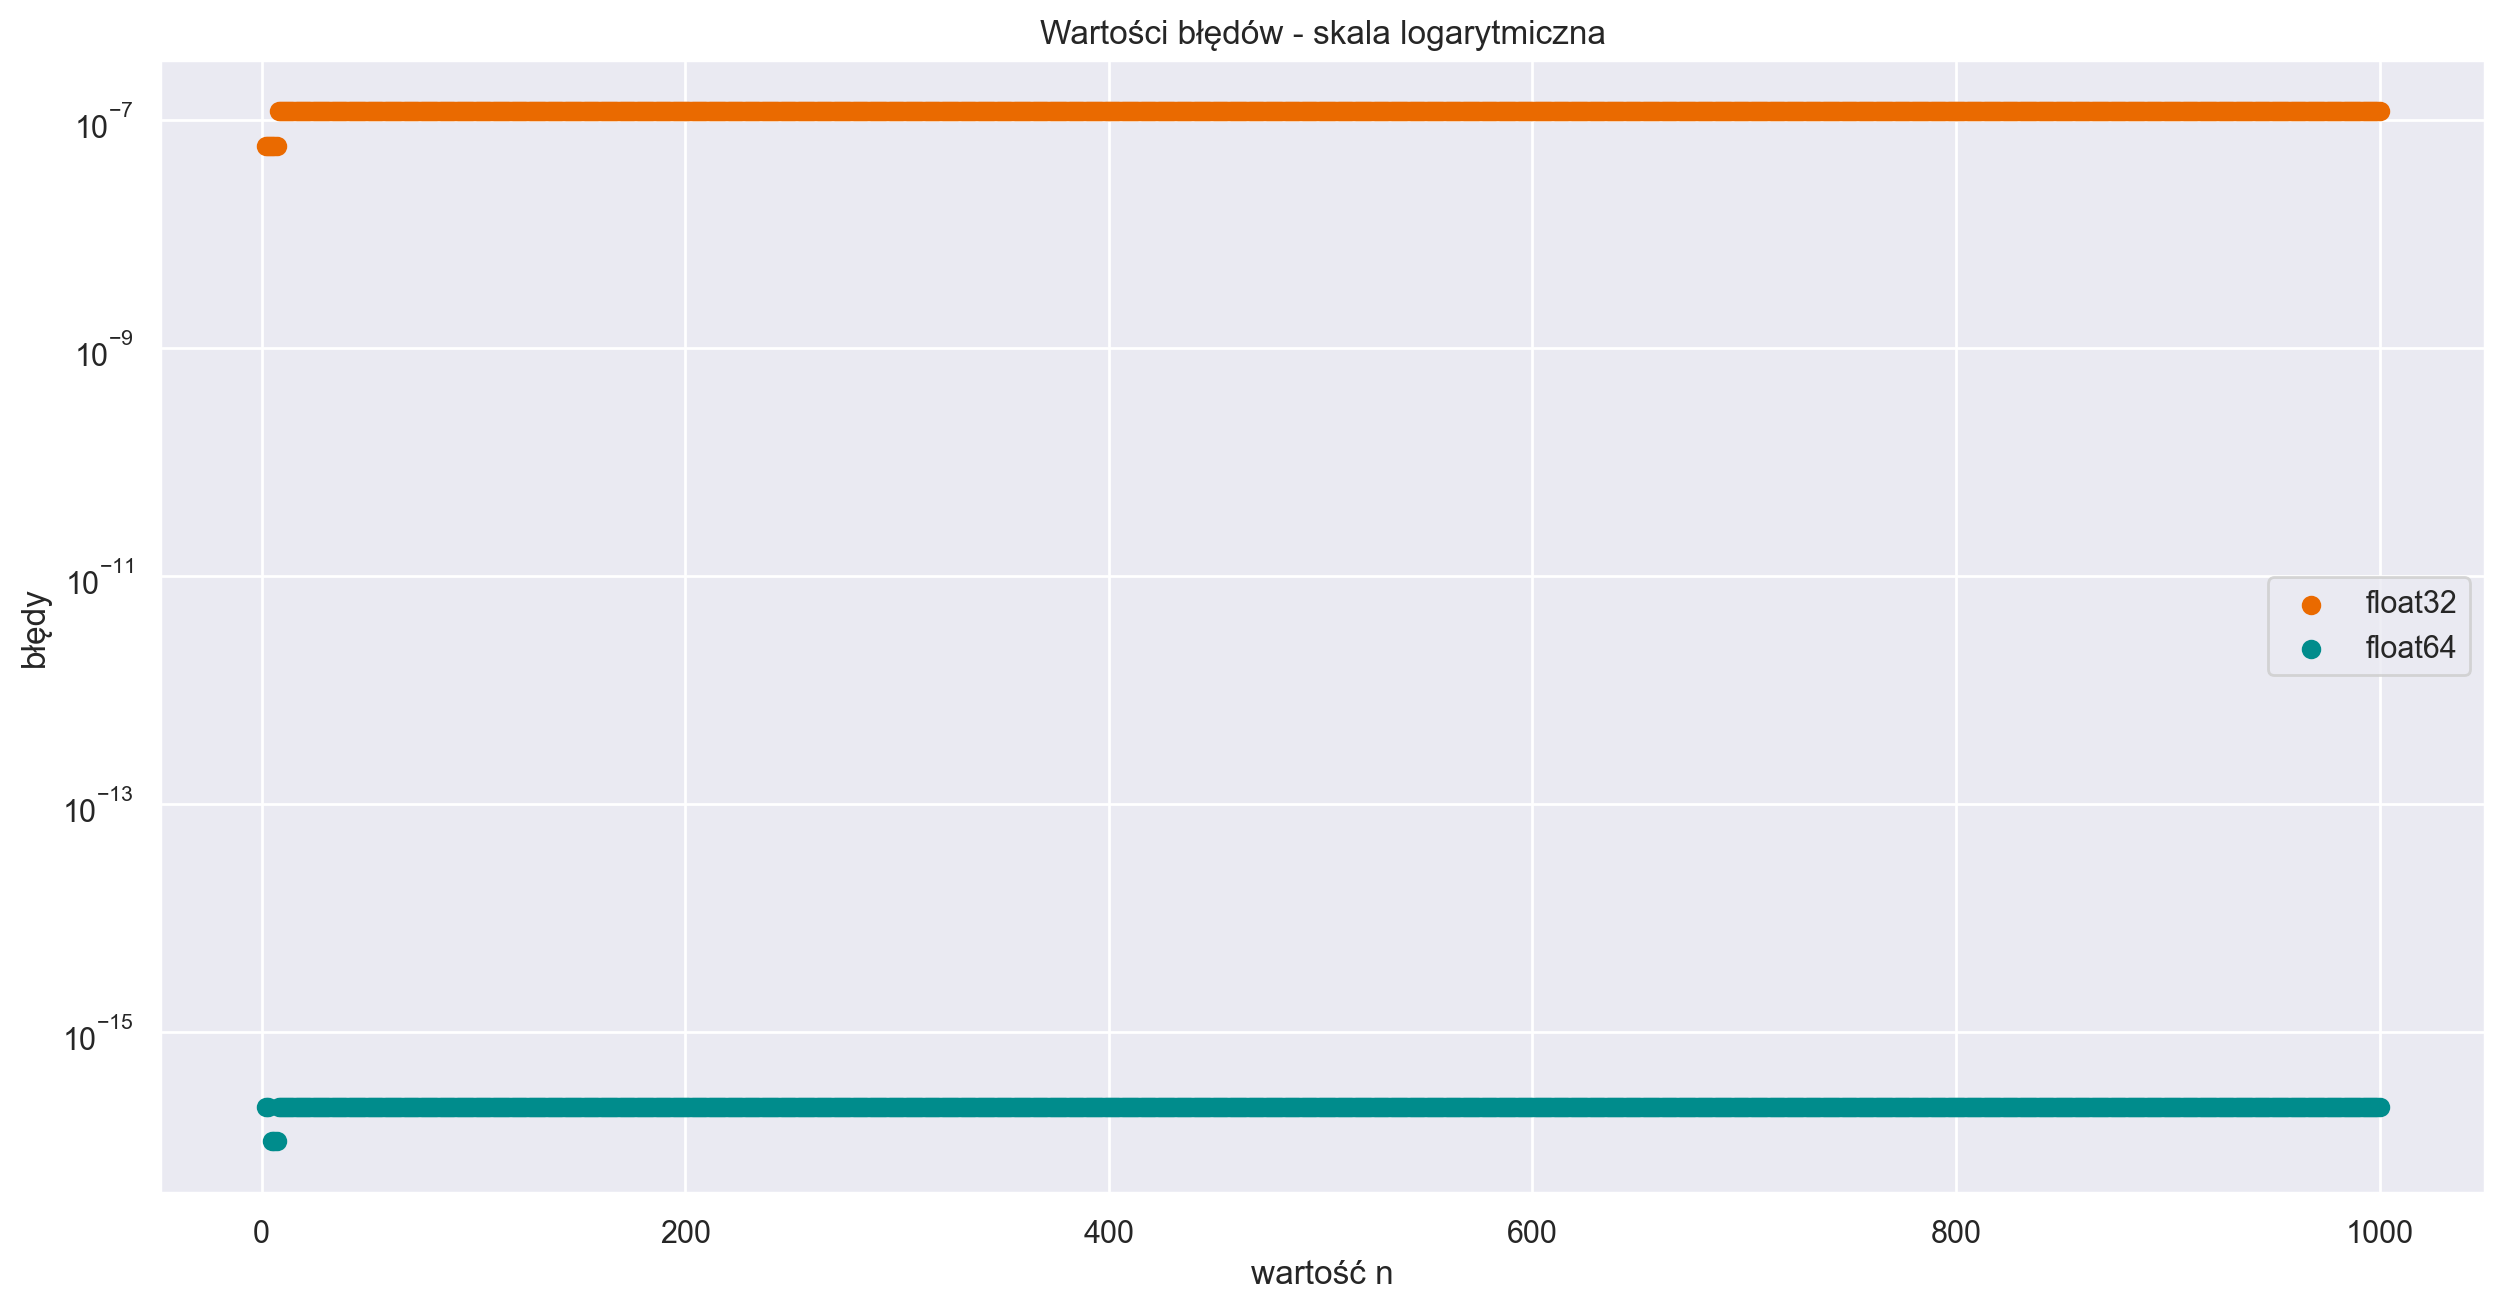

In [165]:
scatter(results3_thomas, 'errors', 'Wartości błędów - skala logarytmiczna', 'błędy', 'log')

#### Czasy obliczeń

##### Skala liniowa

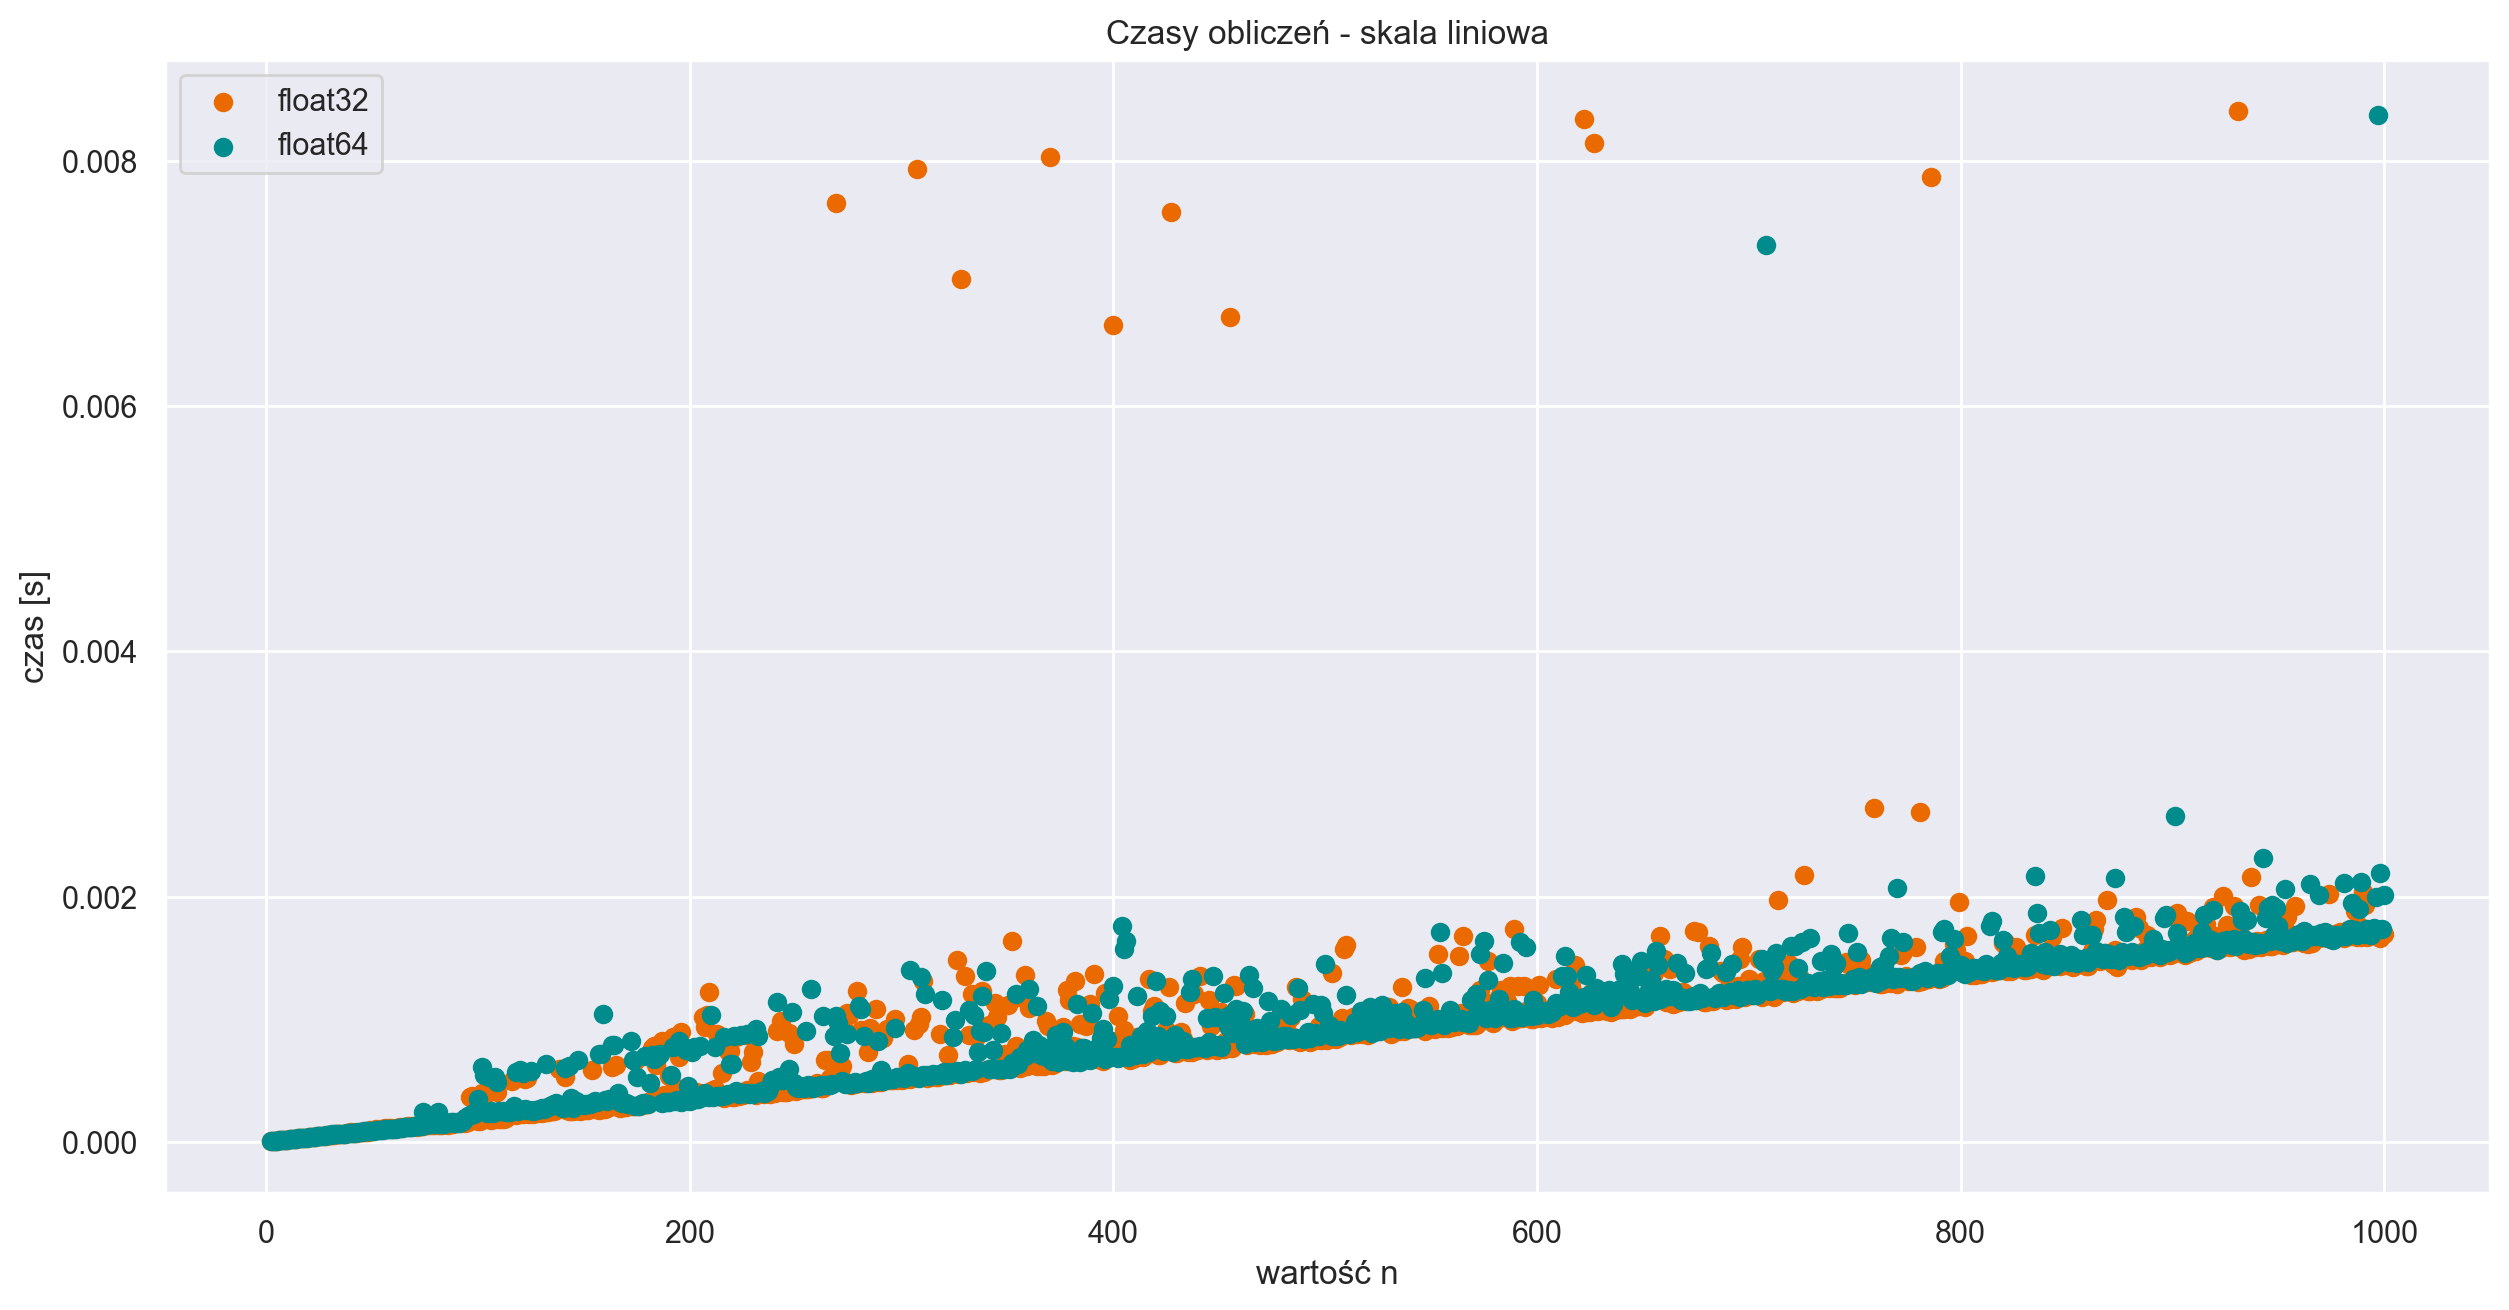

In [166]:
scatter(results3_thomas, 'times', 'Czasy obliczeń - skala liniowa', 'czas [s]')

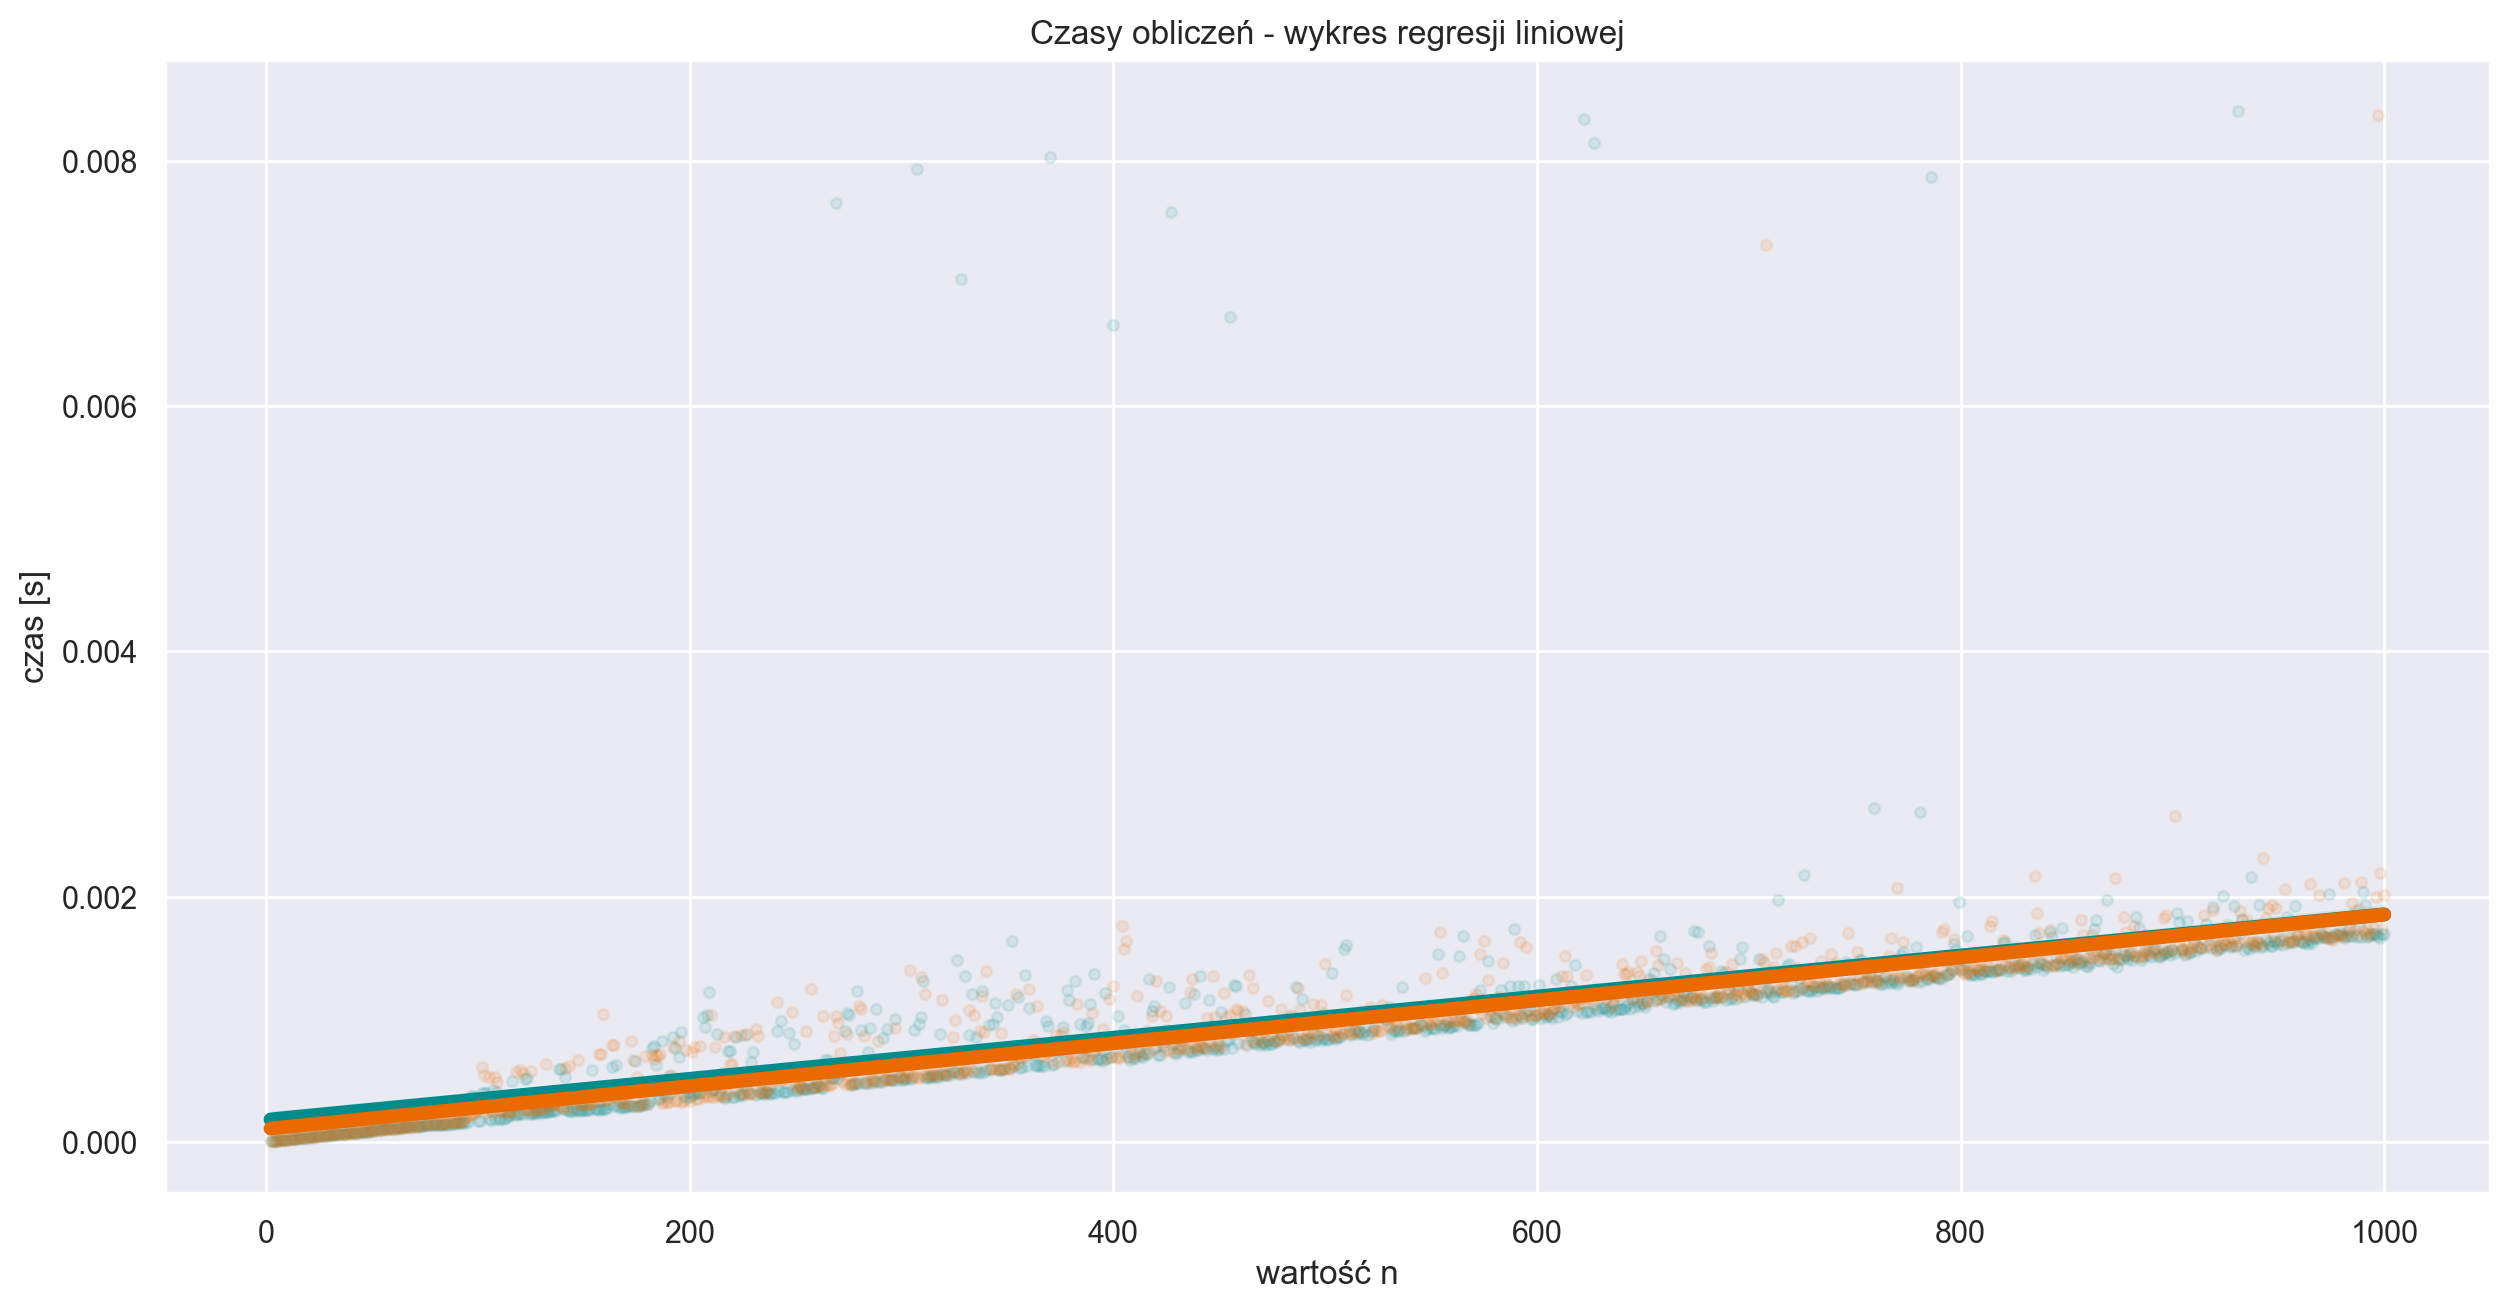

In [167]:
thomas_times32 = results3_thomas['float32']['times']
thomas_times64 = results3_thomas['float64']['times']

plt.figure(figsize=(15, 7.5))
plt.xlabel('wartość n')
plt.ylabel('czas [s]')
plt.title('Czasy obliczeń - wykres regresji liniowej')
colors = '#008C8C', '#EA6A00'
for i, (x, y) in enumerate(map(list, (t.keys(), t.values())) for t in (thomas_times32, thomas_times64)):
    sns.regplot(x=x, y=y, scatter_kws={'s': 15, 'alpha': .1}, line_kws={'linewidth': 5}, color=colors[i])

##### Skala logarytmiczna

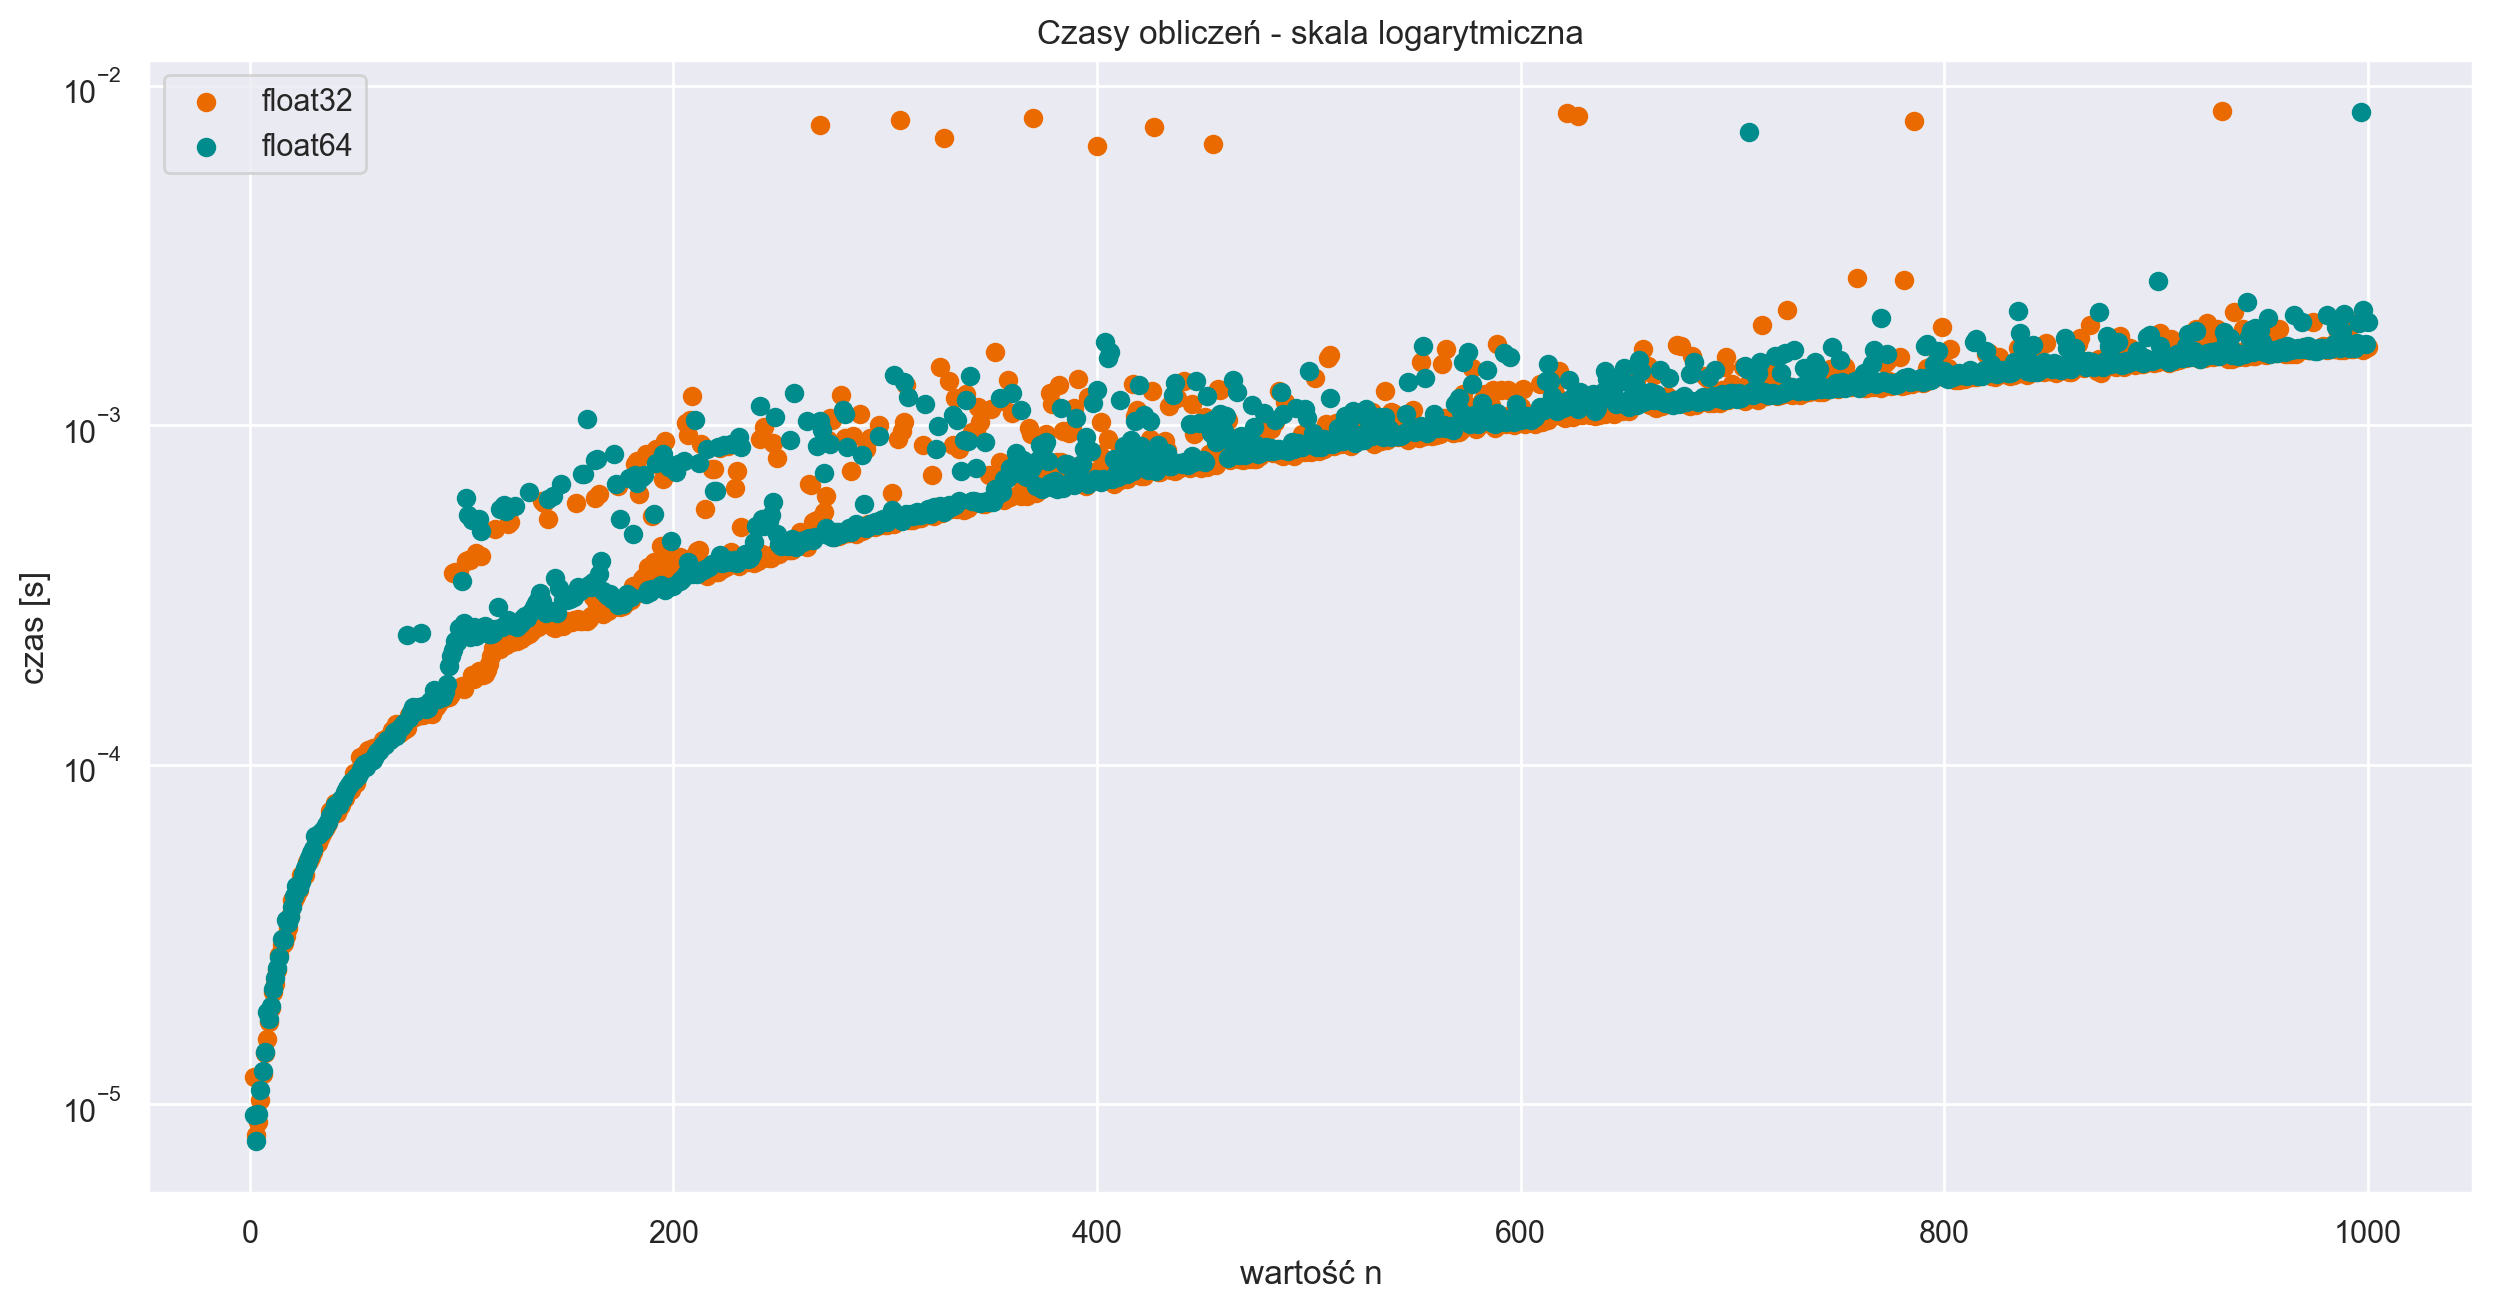

In [168]:
scatter(results3_thomas, 'times', 'Czasy obliczeń - skala logarytmiczna', 'czas [s]', 'log')

In [169]:
results3_thomas['float32']['times']

{2: 1.1999974958598614e-05,
 3: 8.100003469735384e-06,
 4: 8.90000956133008e-06,
 5: 1.0299962013959885e-05,
 6: 1.2300035450607538e-05,
 7: 1.4199991710484028e-05,
 8: 1.5600002370774746e-05,
 9: 1.7499958630651236e-05,
 10: 1.9200029782950878e-05,
 11: 2.1499989088624716e-05,
 12: 2.2599997464567423e-05,
 13: 2.4800014216452837e-05,
 14: 2.7499976567924023e-05,
 15: 2.9399991035461426e-05,
 16: 2.9799994081258774e-05,
 17: 3.1400006264448166e-05,
 18: 3.300001844763756e-05,
 19: 3.579998156055808e-05,
 20: 4.010001430287957e-05,
 21: 3.99000127799809e-05,
 22: 4.1199964471161366e-05,
 23: 4.280003486201167e-05,
 24: 4.730001091957092e-05,
 25: 4.680000711232424e-05,
 26: 4.75000124424696e-05,
 27: 5.15999854542315e-05,
 28: 5.219999002292752e-05,
 29: 5.370000144466758e-05,
 30: 5.540001438930631e-05,
 31: 5.760003114119172e-05,
 32: 5.889998283237219e-05,
 33: 6.0999998822808266e-05,
 34: 6.240000948309898e-05,
 35: 6.440002471208572e-05,
 36: 6.580003537237644e-05,
 37: 6.749999010

### Wybrane wartości - zestawienie

Ponownie wykorzystamy zaimplementowaną wcześniej funkcję pomocniczą, tworzącą zestawienie w postaci tabeli.

#### Zestawienie 

In [170]:
min_n = 2
interval = 10

In [171]:
limit = 50

ns_part = list(ns)
ns_part = ns_part[:limit+1-min_n]
df1 = create_summary_df(results3_thomas, ns_part)
df1.to_excel('zad3-3.xlsx')
df1

,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
n,,,,
2,5.960464e-08,2.220446e-16,0.000012,0.000009
3,5.960464e-08,2.220446e-16,0.000008,0.000008
4,5.960464e-08,0.000000e+00,0.000009,0.000009
5,5.960464e-08,1.110223e-16,0.000010,0.000011
6,5.960464e-08,1.110223e-16,0.000012,0.000013
7,5.960464e-08,1.110223e-16,0.000014,0.000014
8,1.192093e-07,2.220446e-16,0.000016,0.000019
9,1.192093e-07,2.220446e-16,0.000017,0.000018
10,1.192093e-07,2.220446e-16,0.000019,0.000020


In [172]:
ns_part = list(ns)
ns_part = [ns_part[0], *ns_part[interval-min_n::interval]]
df2 = create_summary_df(results3_thomas, ns_part)
df2.to_excel('zad3-4.xlsx')
df2

,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
n,,,,
2,5.960464e-08,2.220446e-16,0.000012,0.000009
10,1.192093e-07,2.220446e-16,0.000019,0.000020
20,1.192093e-07,2.220446e-16,0.000040,0.000038
30,1.192093e-07,2.220446e-16,0.000055,0.000057
40,1.192093e-07,2.220446e-16,0.000077,0.000076
...,...,...,...,...
960,1.192093e-07,2.220446e-16,0.001641,0.001695
970,1.192093e-07,2.220446e-16,0.001696,0.001701
980,1.192093e-07,2.220446e-16,0.001689,0.001676


### Porównanie metody Gaussa i Thomasa

#### Pomocnicza funkcja

In [173]:
def compare_results(attr, ns, results, columns):
    min_n = min(ns)
    all_rows = list(zip(*(res[attr].values() for res in results)))
    rows = [all_rows[n - min_n] for n in ns]
    return pd.DataFrame(rows, index=ns, columns=columns)

#### Zapisanie interesujących wartości

In [174]:
gauss32 = results3_gauss['float32']
gauss64 = results3_gauss['float64']
thomas32 = results3_thomas['float32']
thomas64 = results3_thomas['float64']

min_n = 2
max_n = 1000
ns_beginning = list(range(2, 51))
ns_interval = [min_n, *range(10, max_n + 1, 10)]

#### Pomocnicza funkcja do rysowania wykresów

In [175]:
def comparison_scatter_plot(df, ylabel, title):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df)
    plt.xlabel('wartość n')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

#### Porównanie błędów

In [176]:
df_errors1 = compare_results(
    'errors', 
    ns_beginning, 
    (gauss32, thomas32, gauss64, thomas64), 
    ('gauss32', 'thomas32', 'gauss64', 'thomas64')
)

df_errors2 = compare_results(
    'errors', 
    ns_interval, 
    (gauss32, thomas32, gauss64, thomas64), 
    ('gauss32', 'thomas32', 'gauss64', 'thomas64')
)

df_errors1.to_excel('zad3-comparison-errors-1.xlsx')
df_errors2.to_excel('zad3-comparison-errors-2.xlsx')

In [177]:
df_errors1

,gauss32,thomas32,gauss64,thomas64
2,5.960464e-08,5.960464e-08,2.220446e-16,2.220446e-16
3,5.960464e-08,5.960464e-08,2.220446e-16,2.220446e-16
4,5.960464e-08,5.960464e-08,0.000000e+00,0.000000e+00
5,5.960464e-08,5.960464e-08,1.110223e-16,1.110223e-16
6,5.960464e-08,5.960464e-08,1.110223e-16,1.110223e-16
7,5.960464e-08,5.960464e-08,1.110223e-16,1.110223e-16
8,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
9,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
10,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
11,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16


In [178]:
df_errors2

,gauss32,thomas32,gauss64,thomas64
2,5.960464e-08,5.960464e-08,2.220446e-16,2.220446e-16
10,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
20,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
30,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
40,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
...,...,...,...,...
960,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
970,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
980,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16
990,1.192093e-07,1.192093e-07,2.220446e-16,2.220446e-16


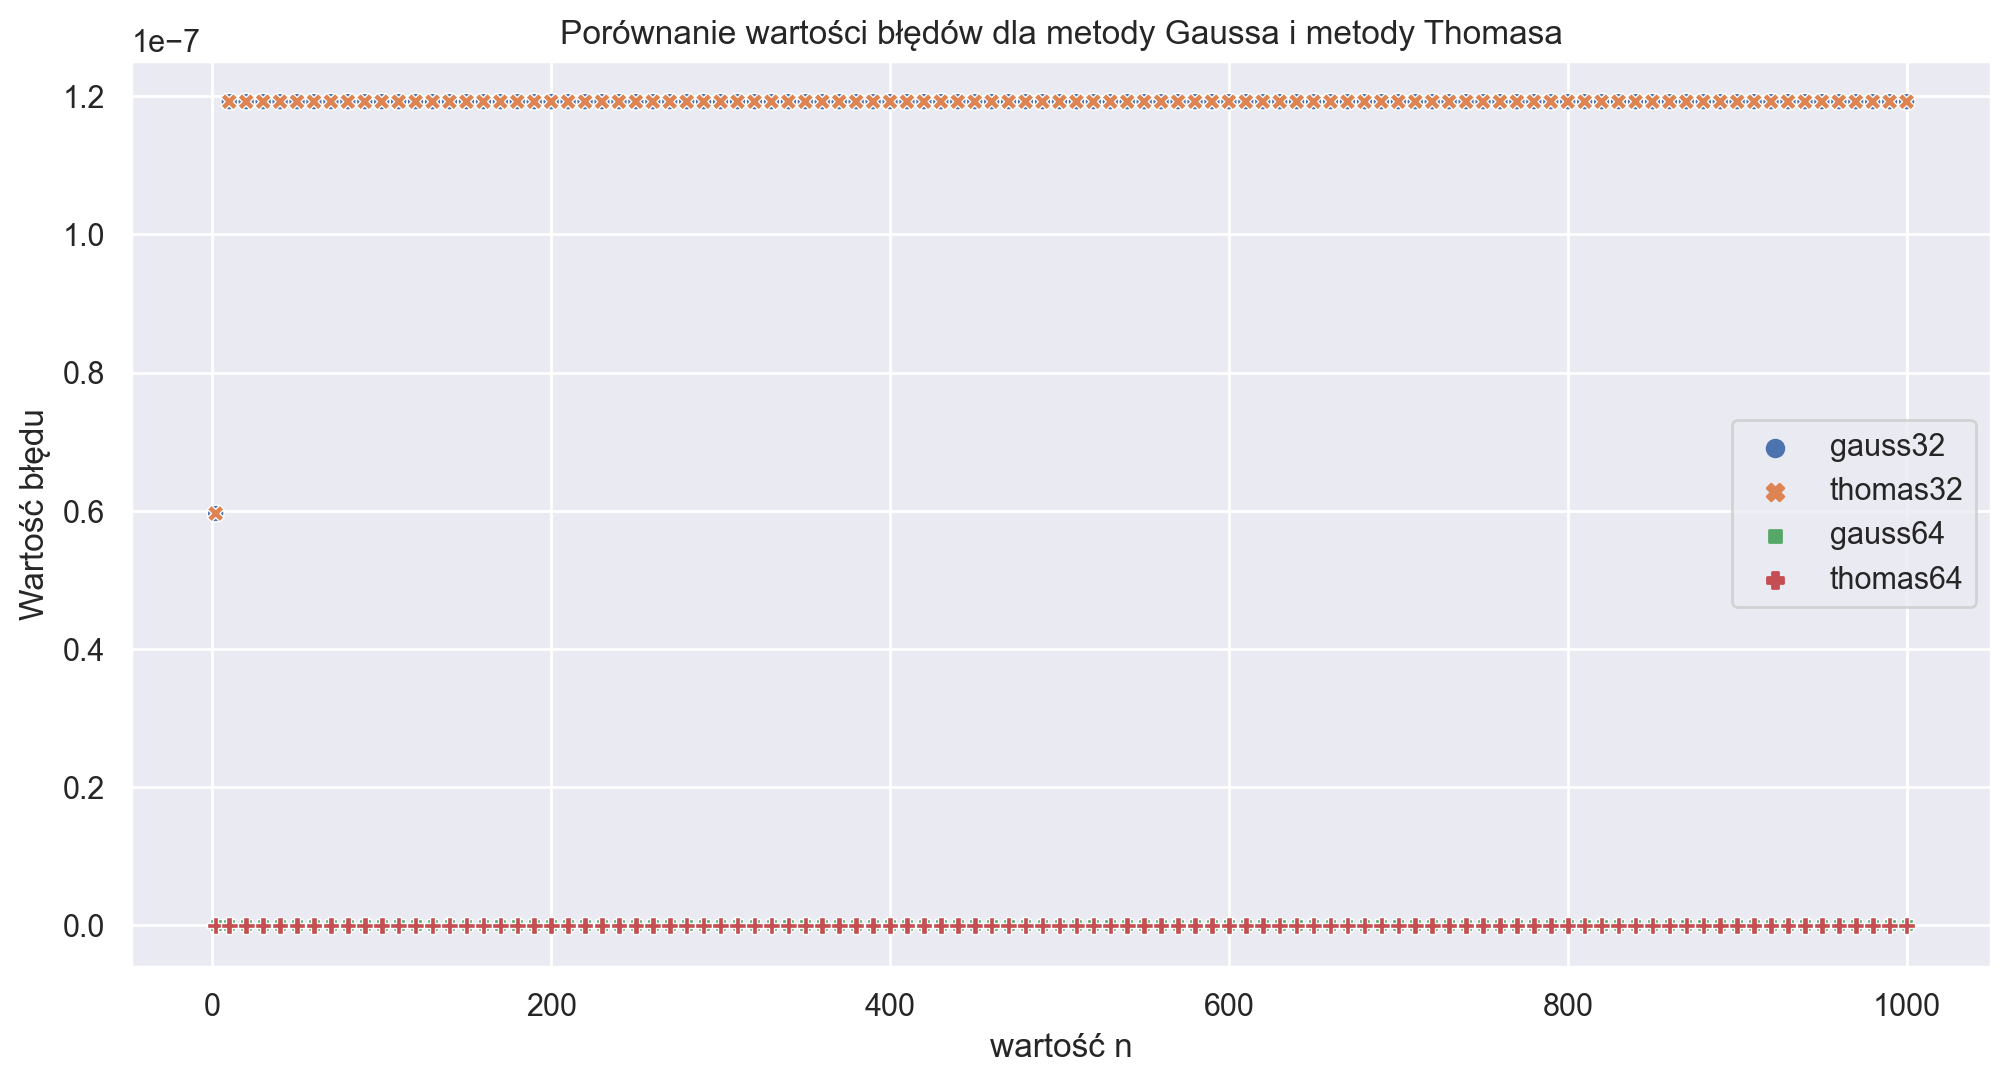

In [181]:
comparison_scatter_plot(
    df_errors2,
    ylabel='Wartość błędu', 
    title='Porównanie wartości błędów dla metody Gaussa i metody Thomasa'
)

#### Porównanie czasów

In [182]:
df_times1 = compare_results(
    'times', 
    ns_beginning, 
    (gauss32, thomas32, gauss64, thomas64), 
    ('gauss32', 'thomas32', 'gauss64', 'thomas64')
)

df_times2 = compare_results(
    'times', 
    ns_interval, 
    (gauss32, thomas32, gauss64, thomas64), 
    ('gauss32', 'thomas32', 'gauss64', 'thomas64')
)

df_times1.to_excel('zad3-comparison-times-1.xlsx')
df_times2.to_excel('zad3-comparison-times-2.xlsx')

In [183]:
df_times1

,gauss32,thomas32,gauss64,thomas64
2,0.000372,0.000012,0.000056,0.000009
3,0.000242,0.000008,0.000033,0.000008
4,0.000063,0.000009,0.000045,0.000009
5,0.000136,0.000010,0.000060,0.000011
6,0.000517,0.000012,0.000078,0.000013
7,0.000122,0.000014,0.000099,0.000014
8,0.000145,0.000016,0.000122,0.000019
9,0.000166,0.000017,0.000147,0.000018
10,0.000197,0.000019,0.000184,0.000020
11,0.000228,0.000021,0.000211,0.000022


In [184]:
df_times2

,gauss32,thomas32,gauss64,thomas64
2,0.000372,0.000012,0.000056,0.000009
10,0.000197,0.000019,0.000184,0.000020
20,0.000713,0.000040,0.000637,0.000038
30,0.001521,0.000055,0.002501,0.000057
40,0.002574,0.000077,0.002383,0.000076
...,...,...,...,...
960,1.633250,0.001641,1.743112,0.001695
970,1.648869,0.001696,1.797336,0.001701
980,1.697297,0.001689,1.974095,0.001676
990,1.687633,0.002037,2.038462,0.001721


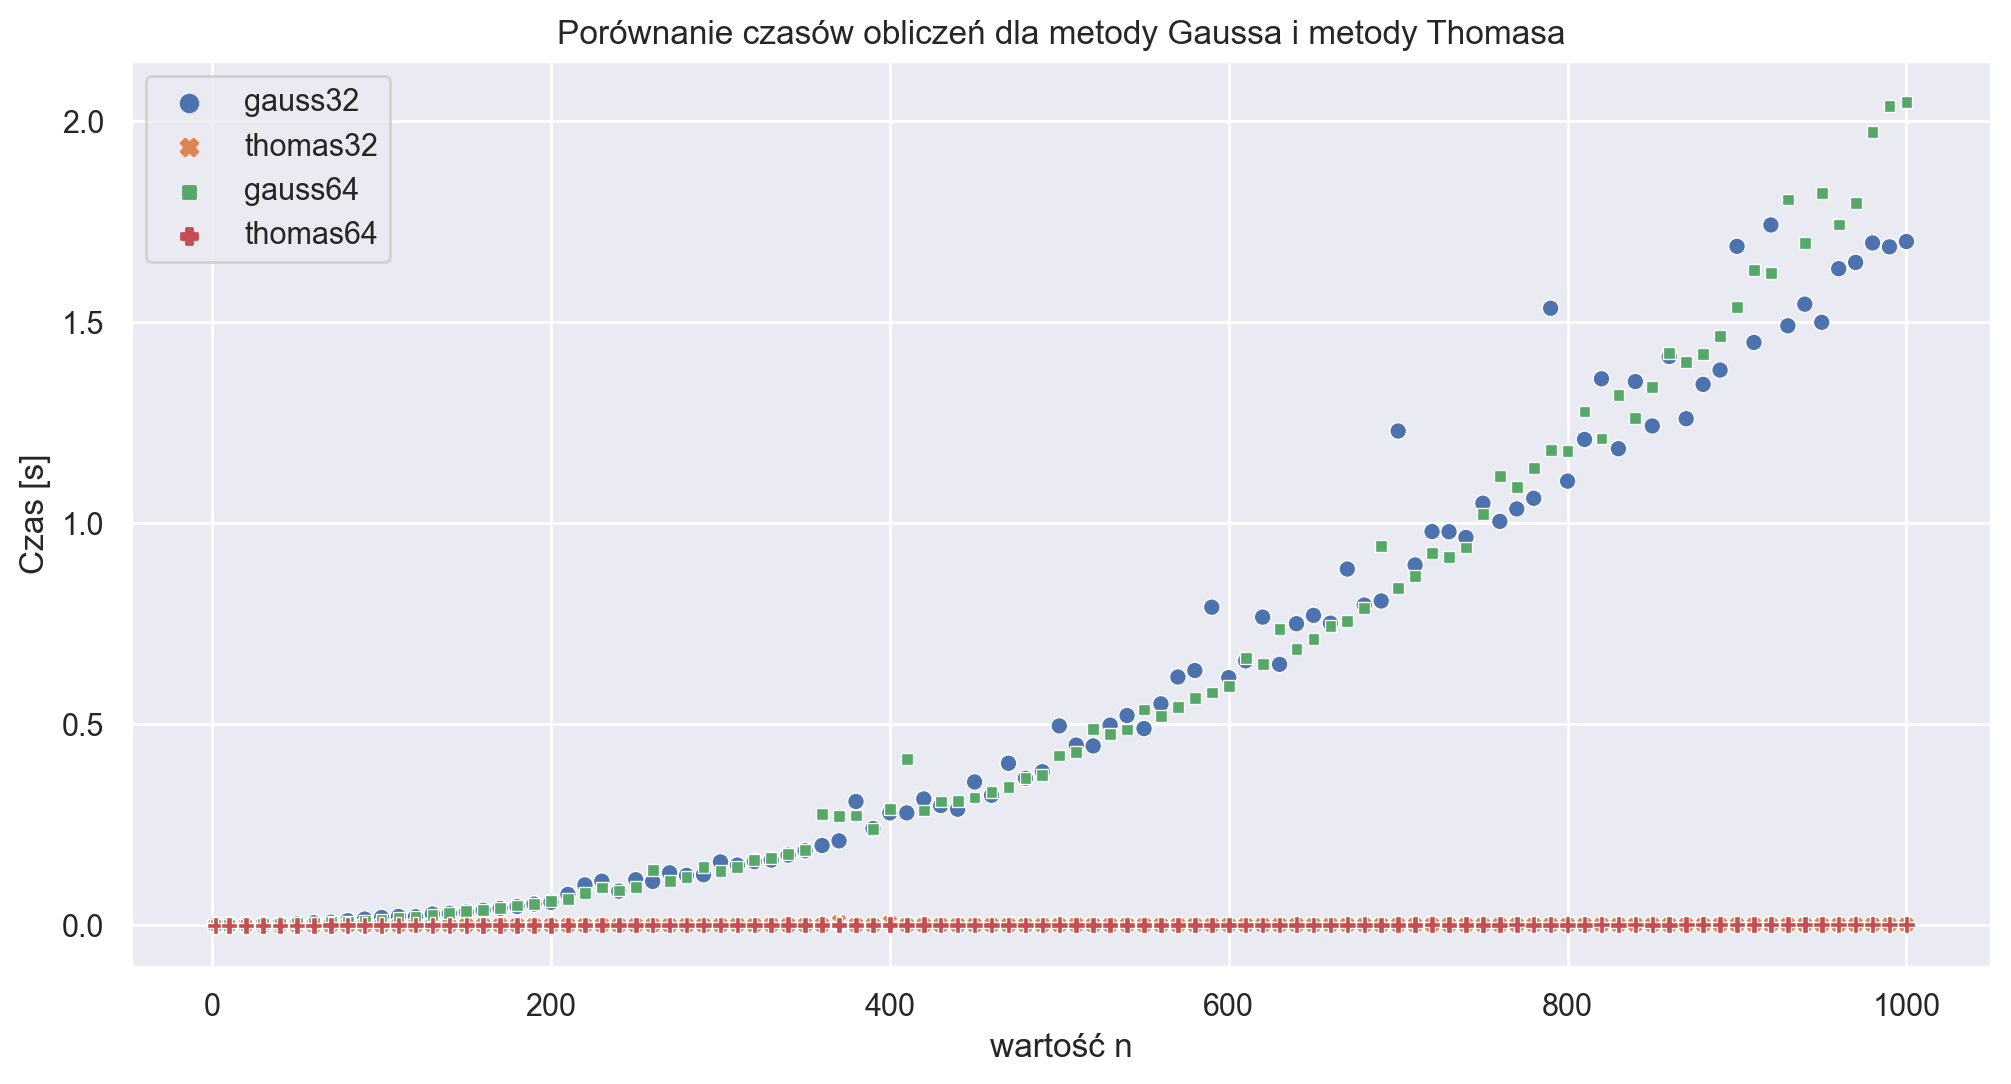

In [185]:
comparison_scatter_plot(
    df_times2,
    ylabel='Czas [s]', 
    title='Porównanie czasów obliczeń dla metody Gaussa i metody Thomasa'
)